In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [2]:
df = pd.read_csv("weatherAUS.csv")
pd.set_option("display.max_columns", None)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [3]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [4]:
df.isnull().sum()*100/len(df)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

In [5]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [6]:
def randomsampleimputation(df, variable):
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [7]:
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

In [8]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2689263927.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr(method = "spearman")


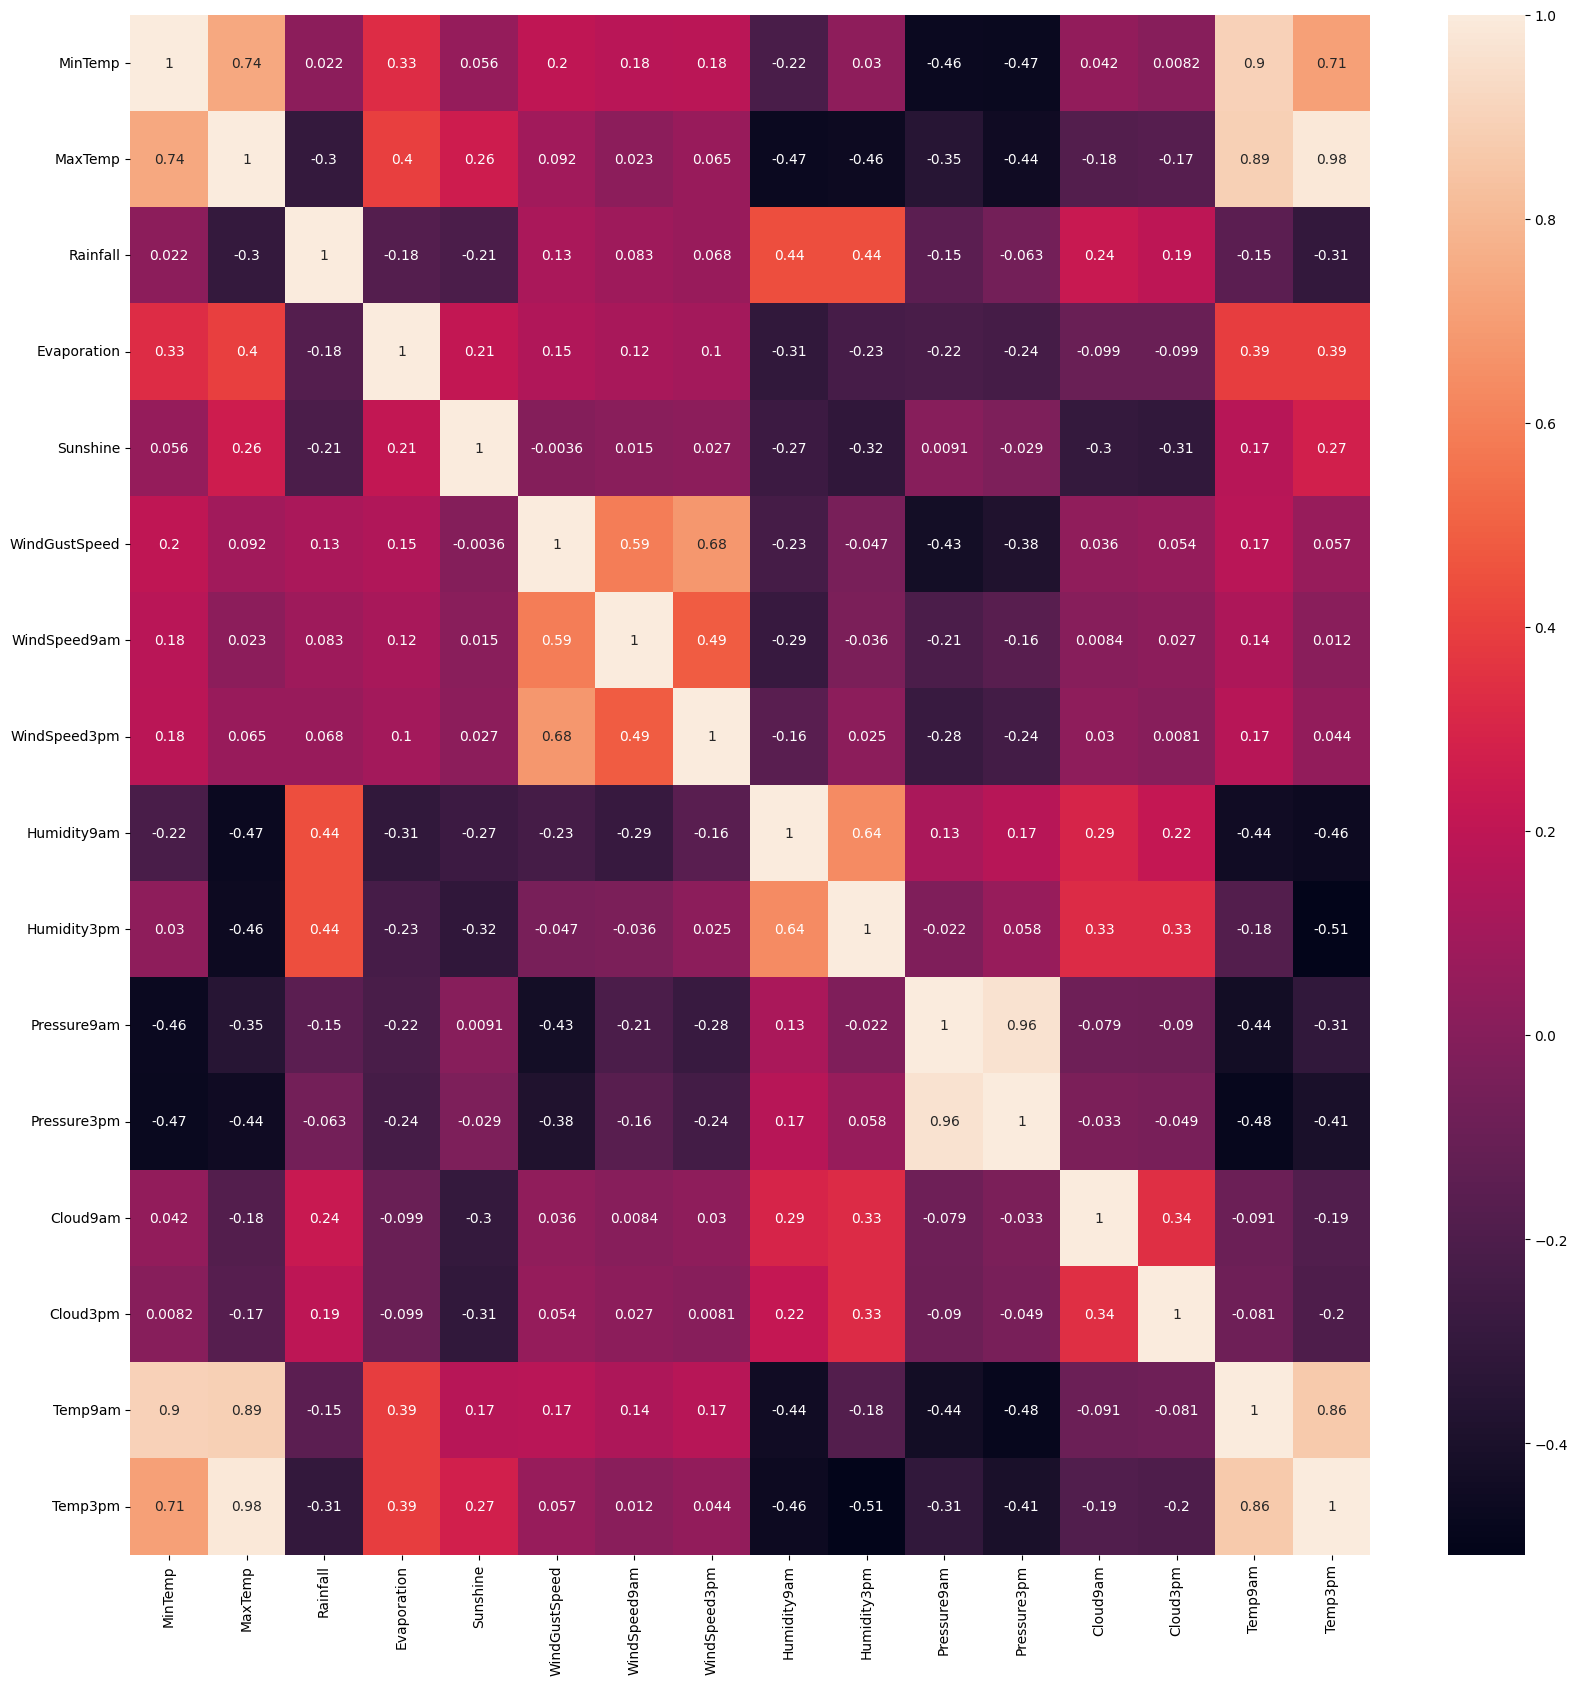

In [9]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


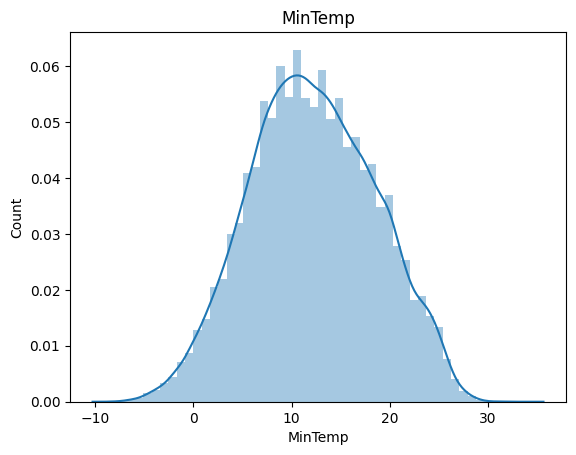

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


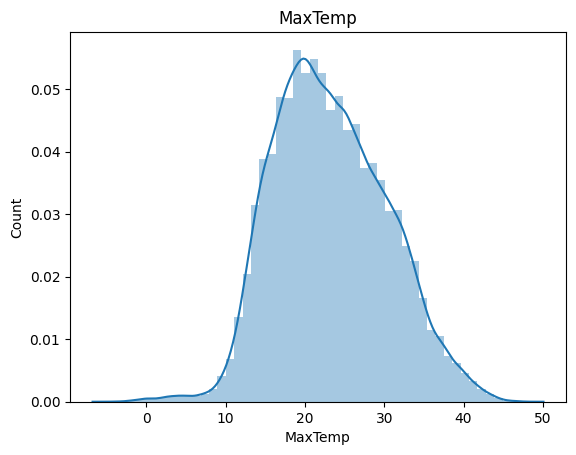

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


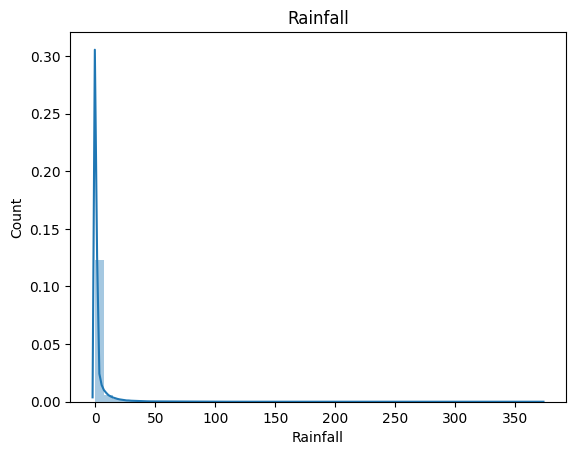

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


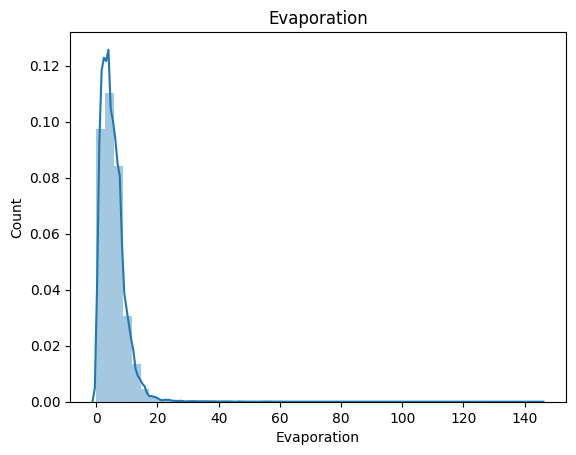

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


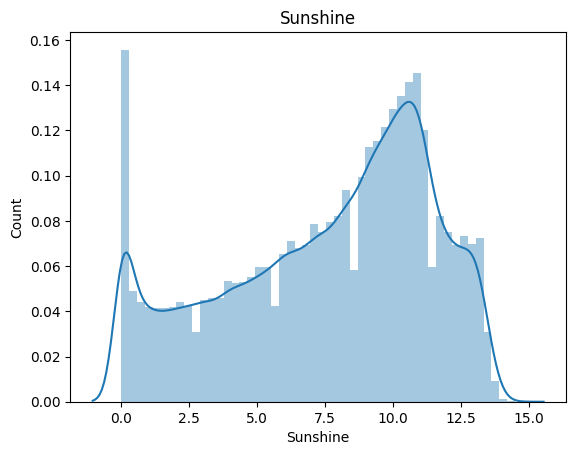

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


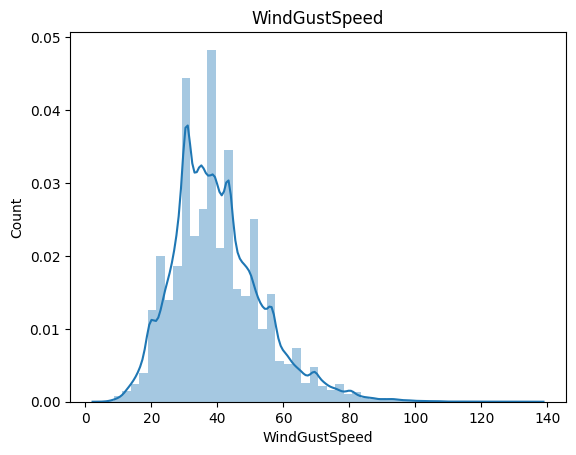

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


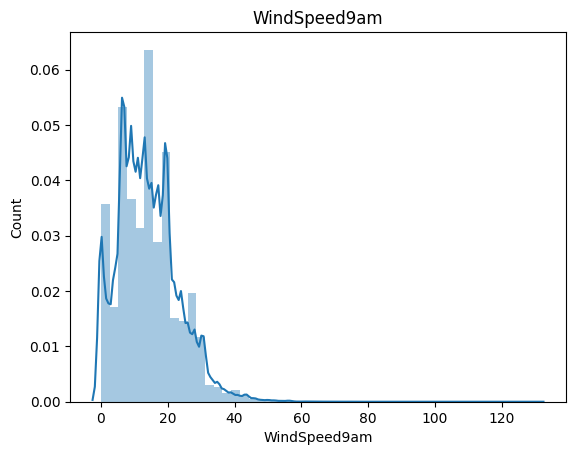

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


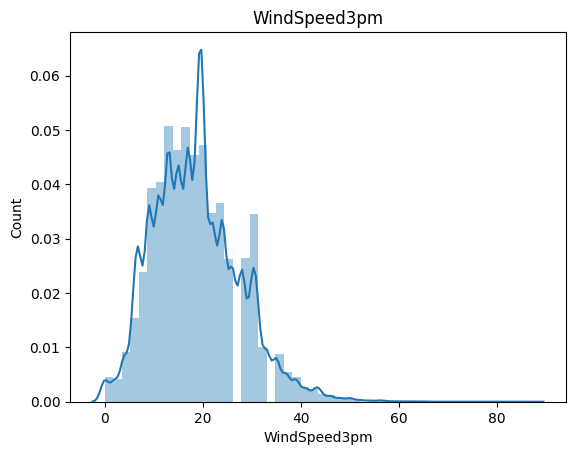

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


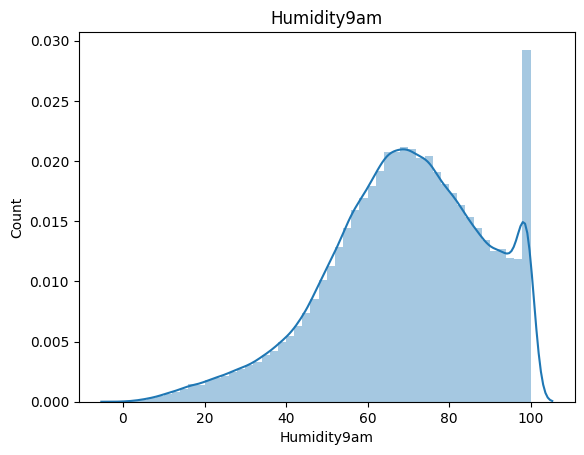

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


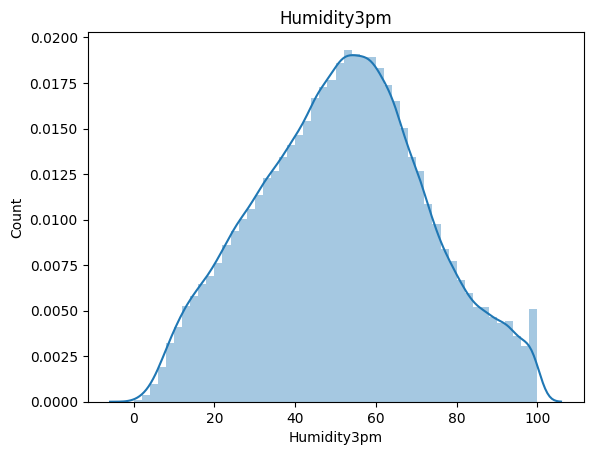

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


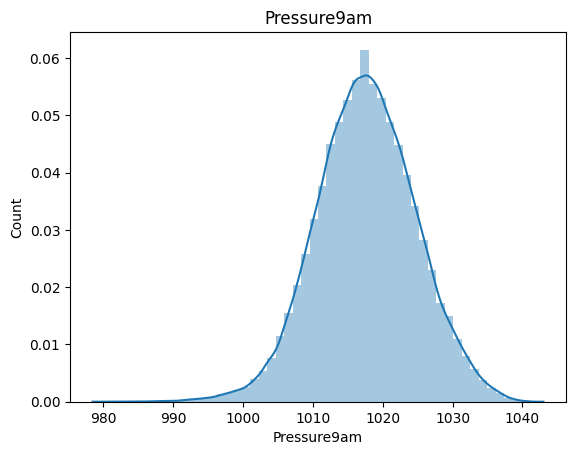

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


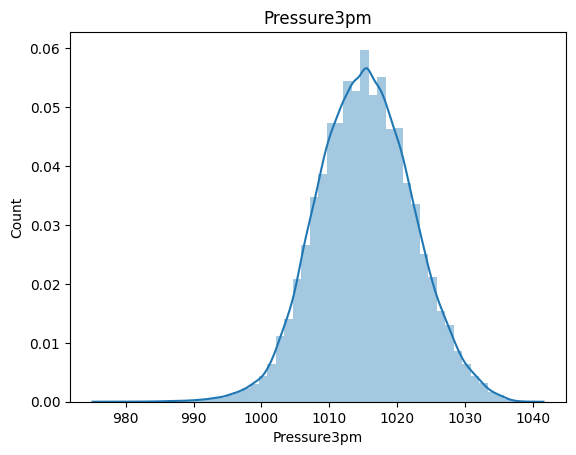

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


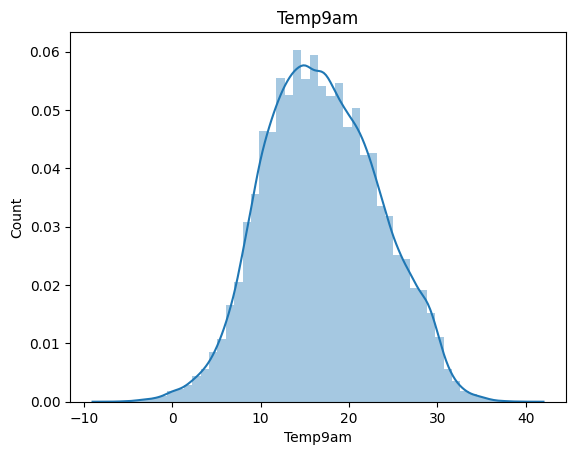

<Figure size 1500x1500 with 0 Axes>

C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


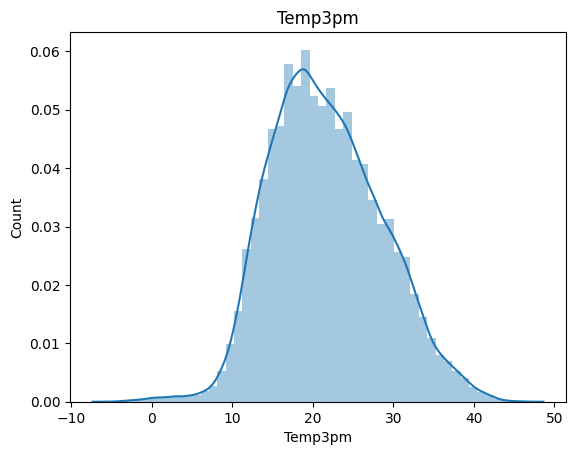

<Figure size 1500x1500 with 0 Axes>

In [10]:
for feature in continuous_feature:
    data=df.copy()
    sns.distplot(df[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

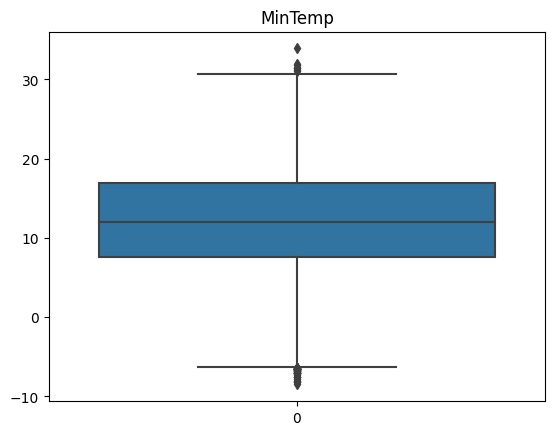

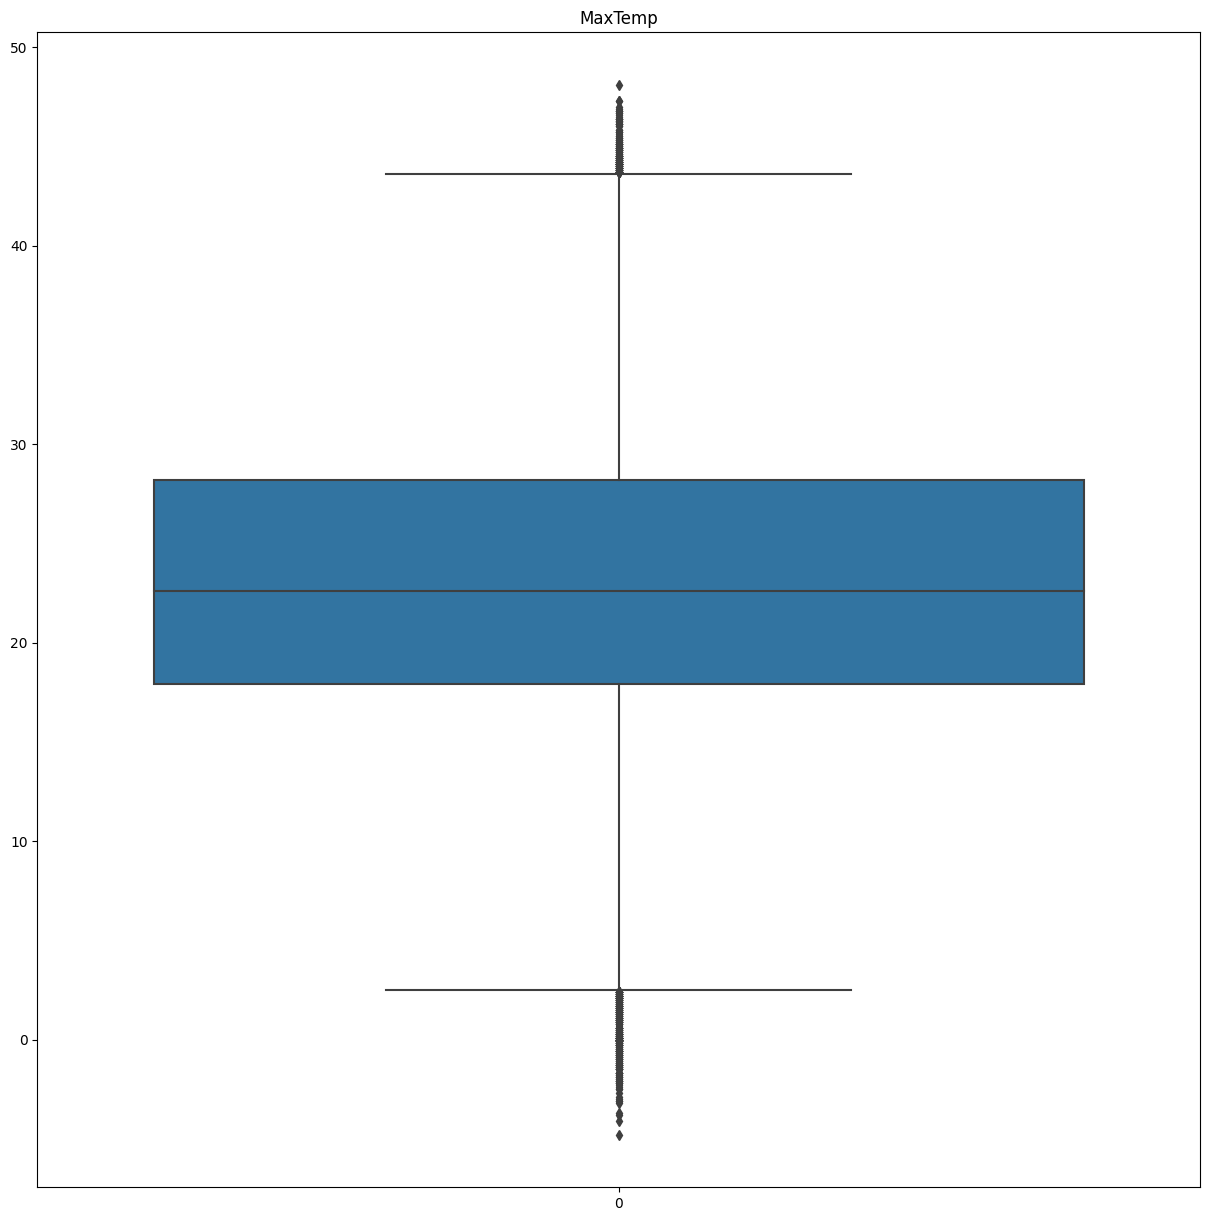

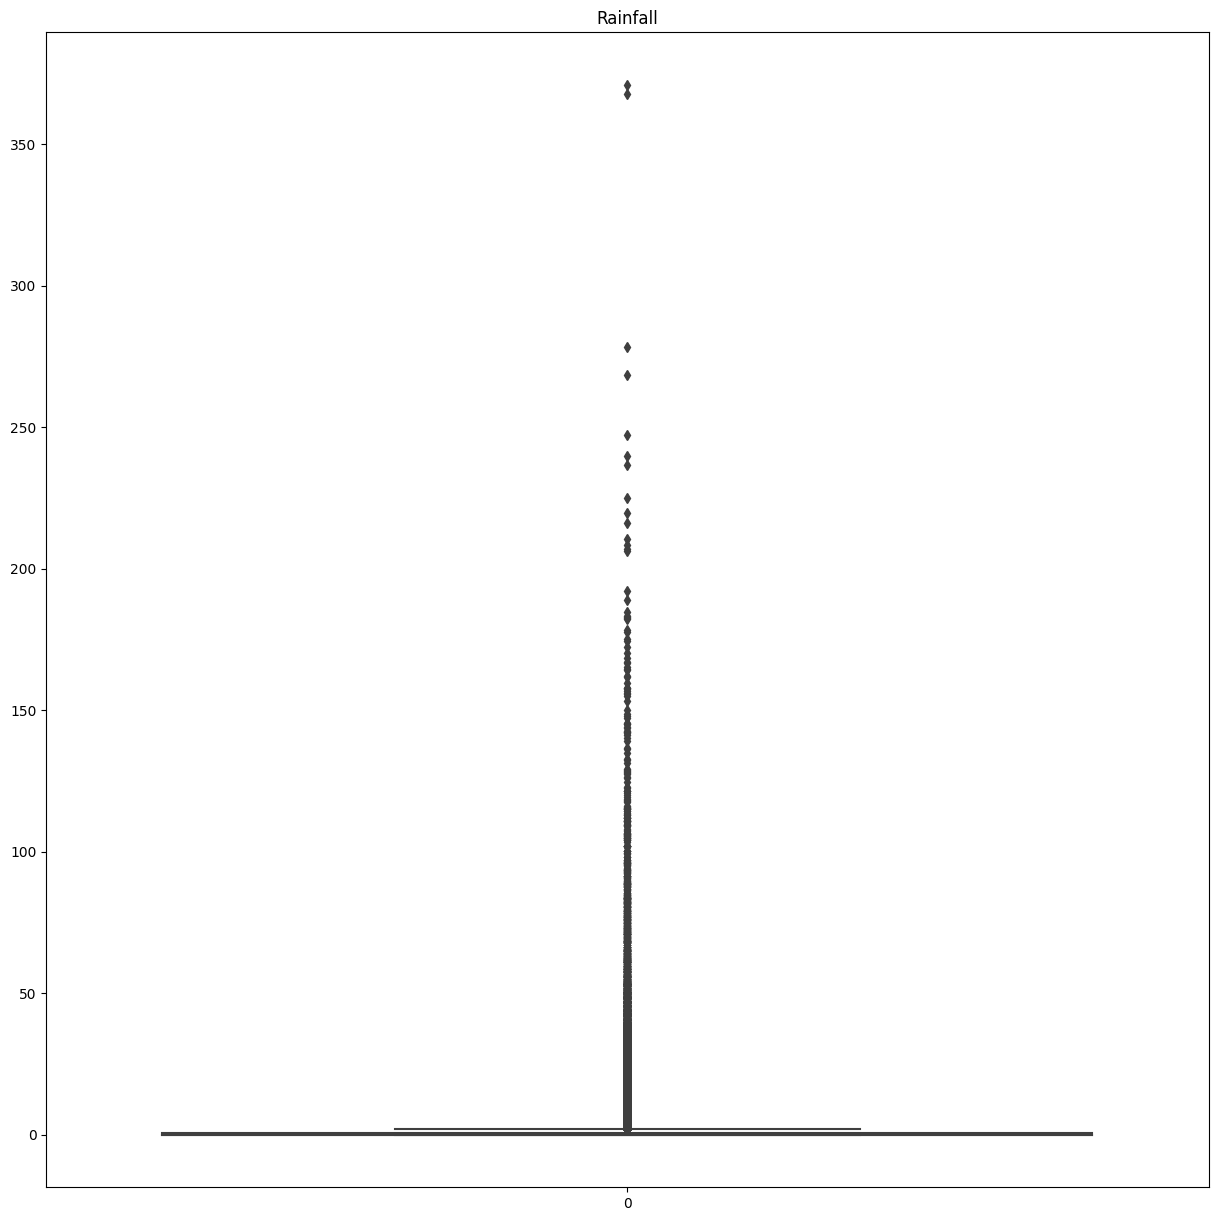

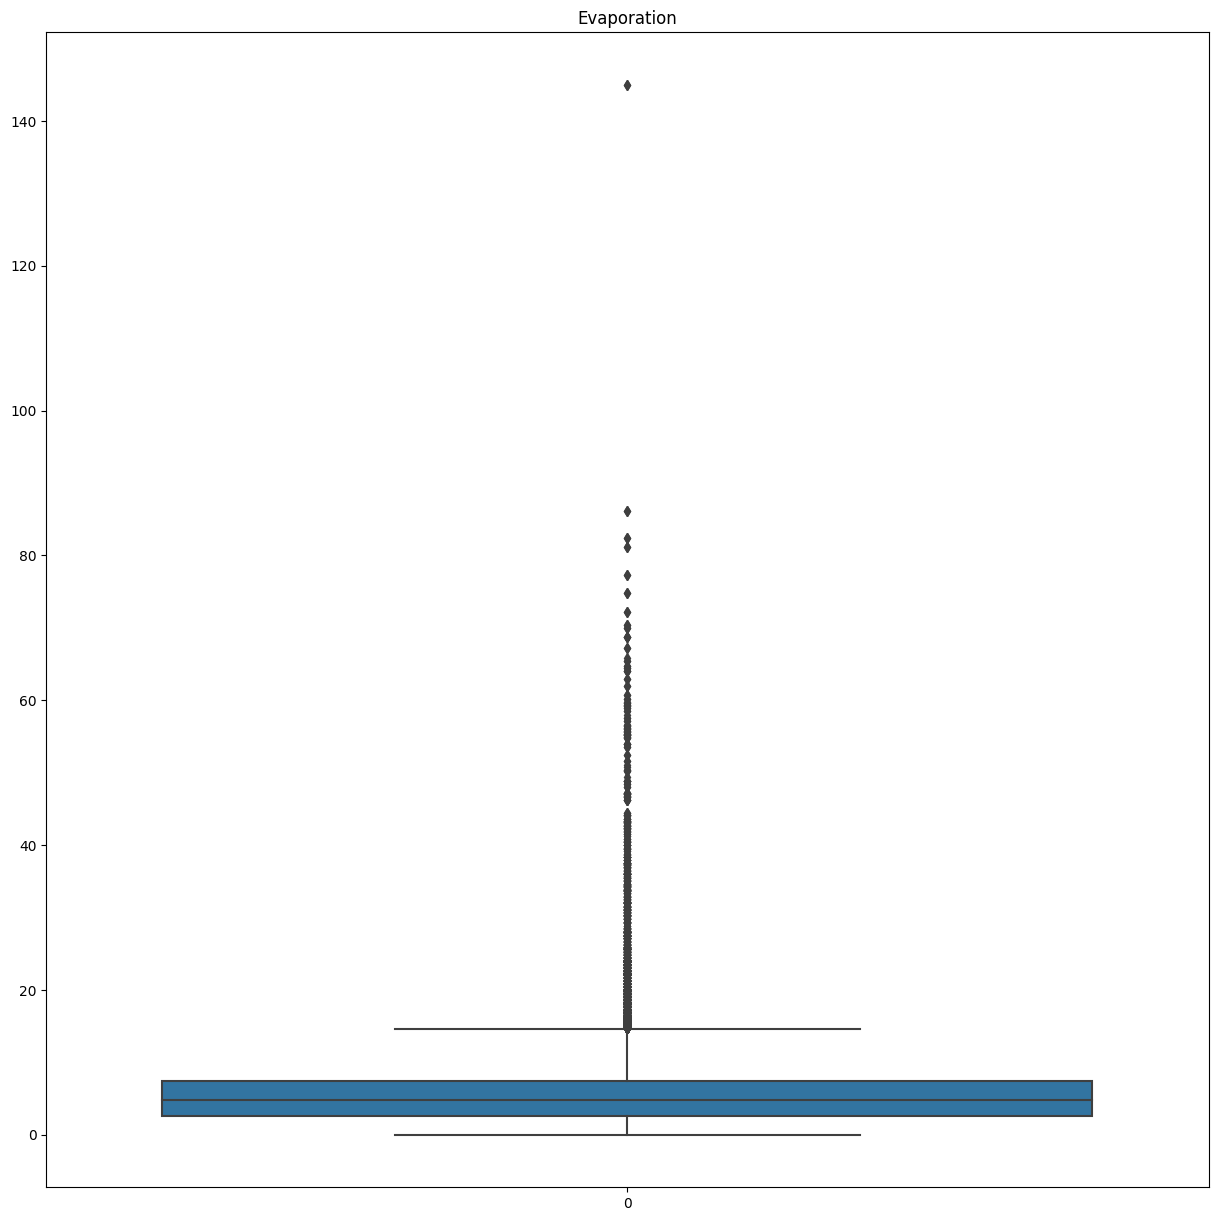

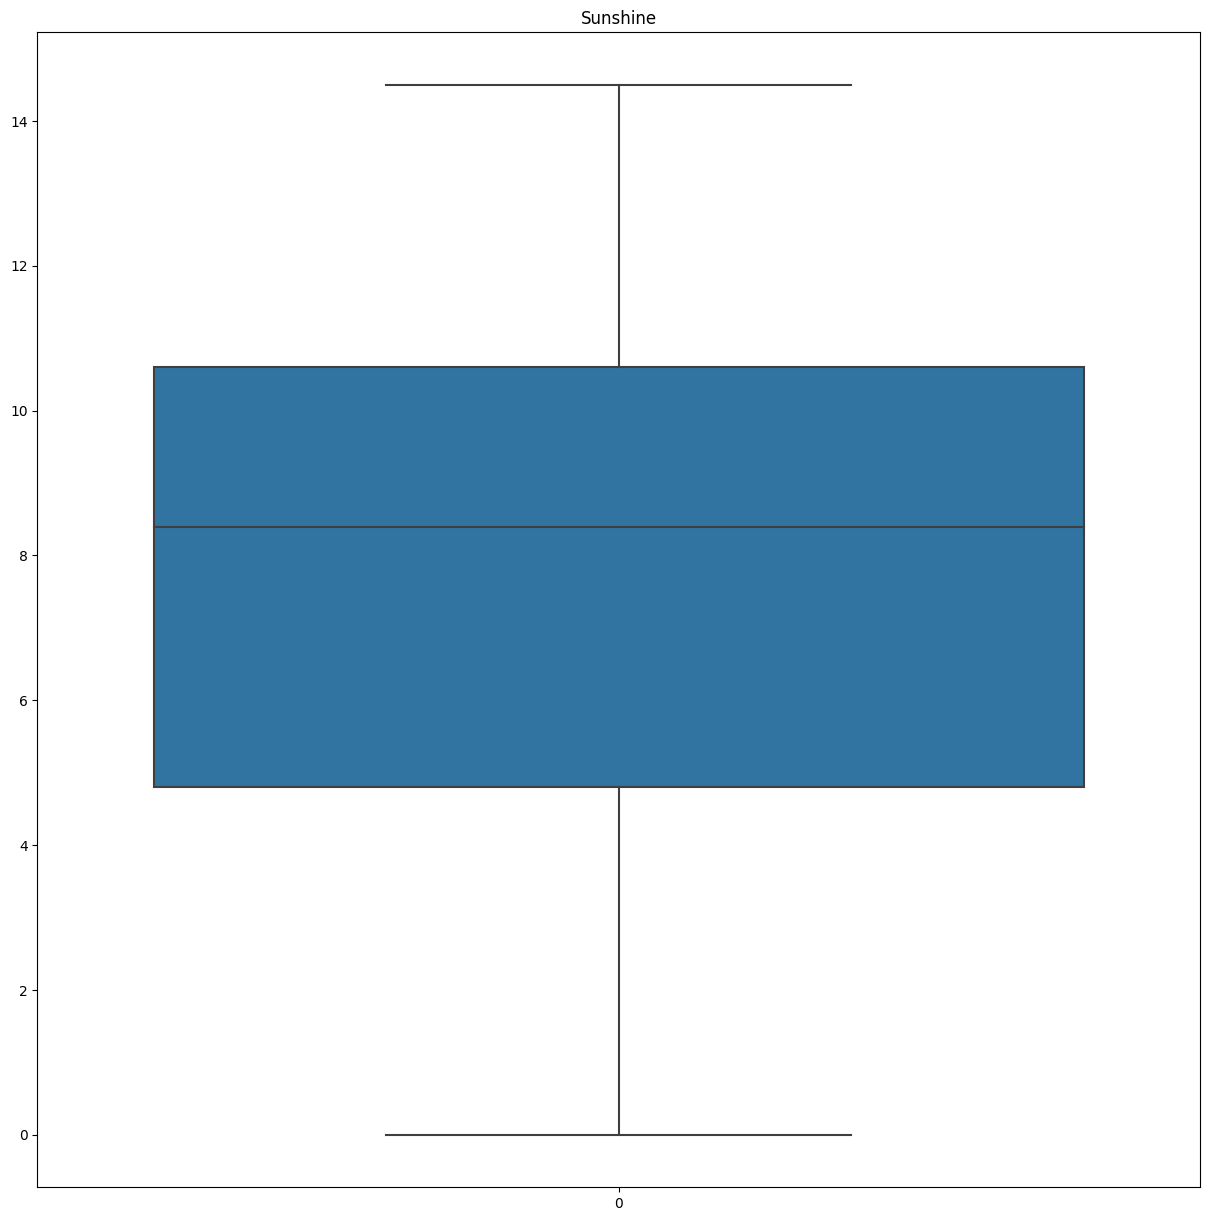

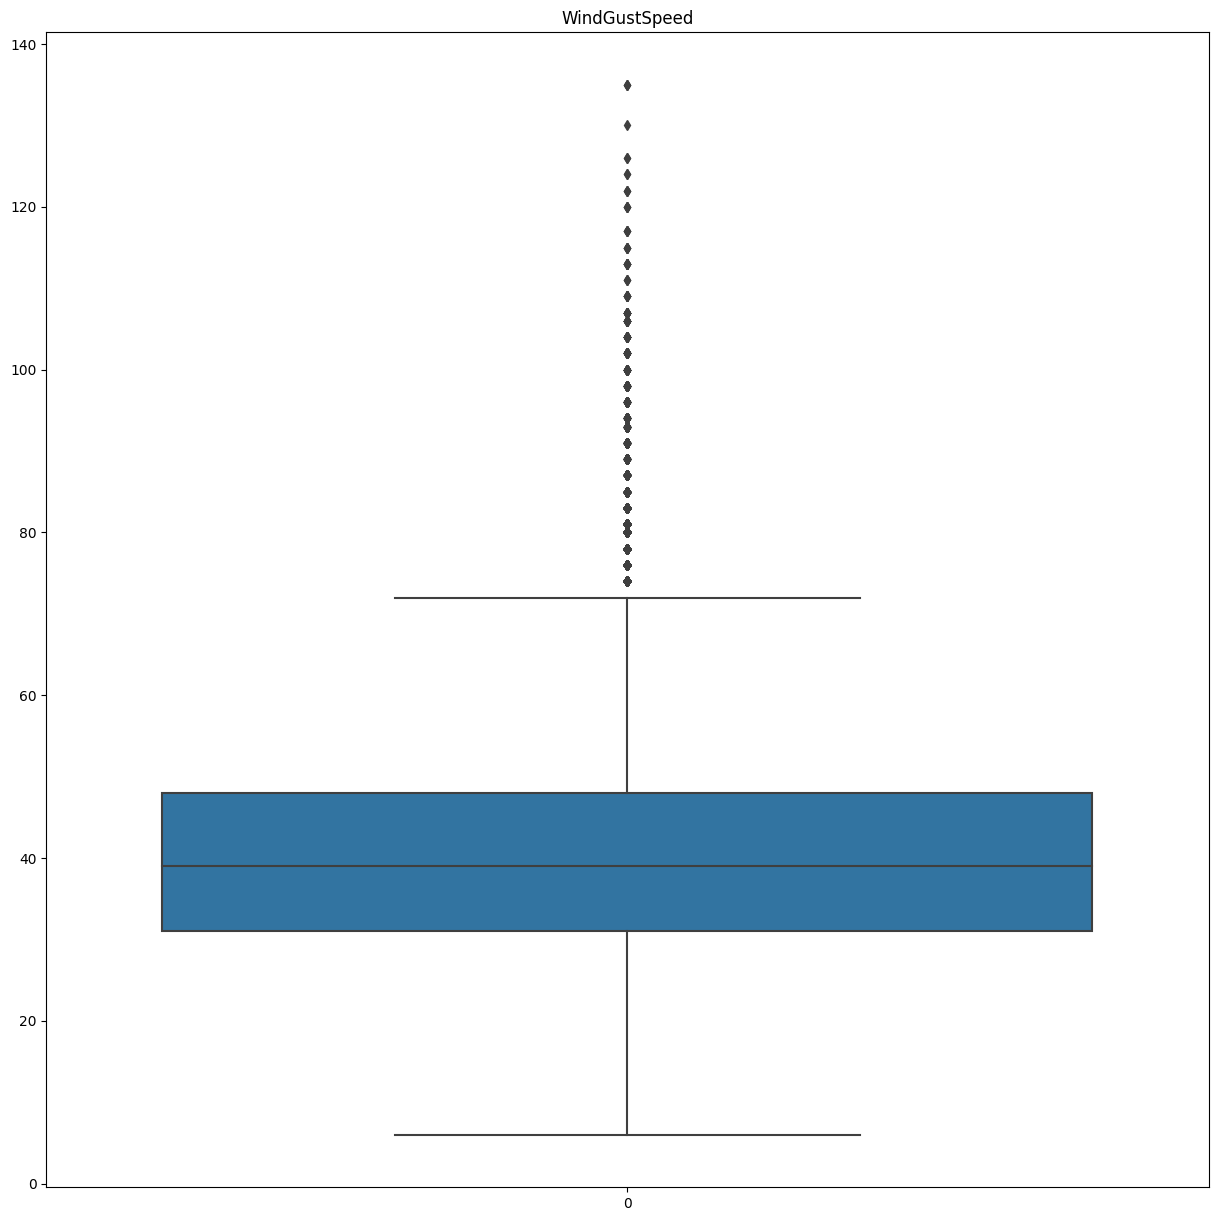

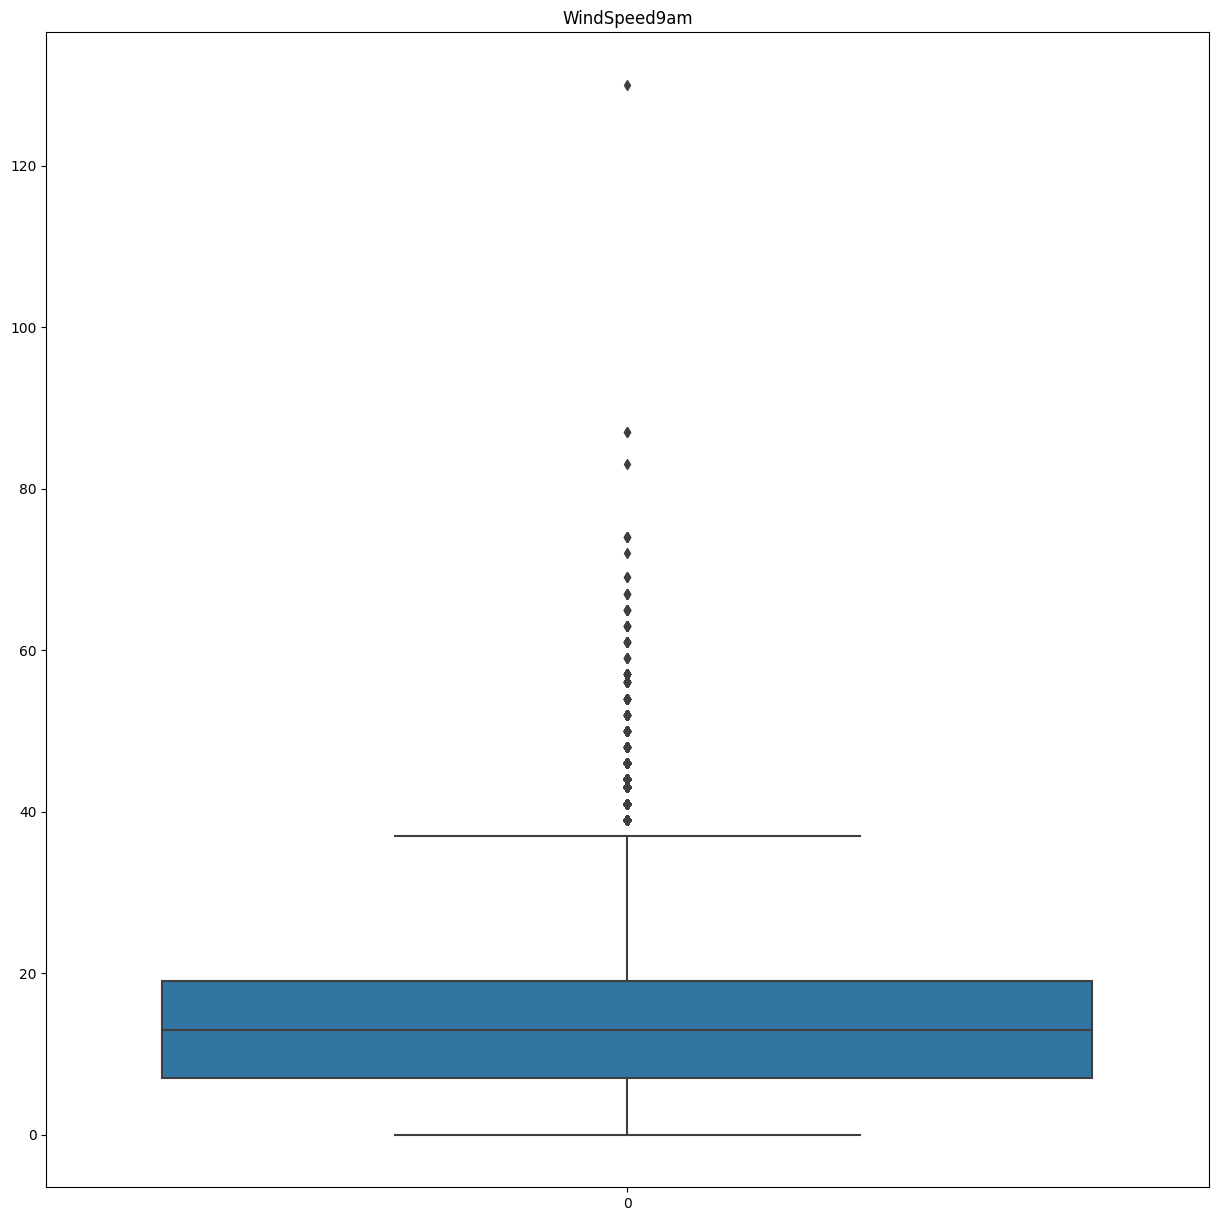

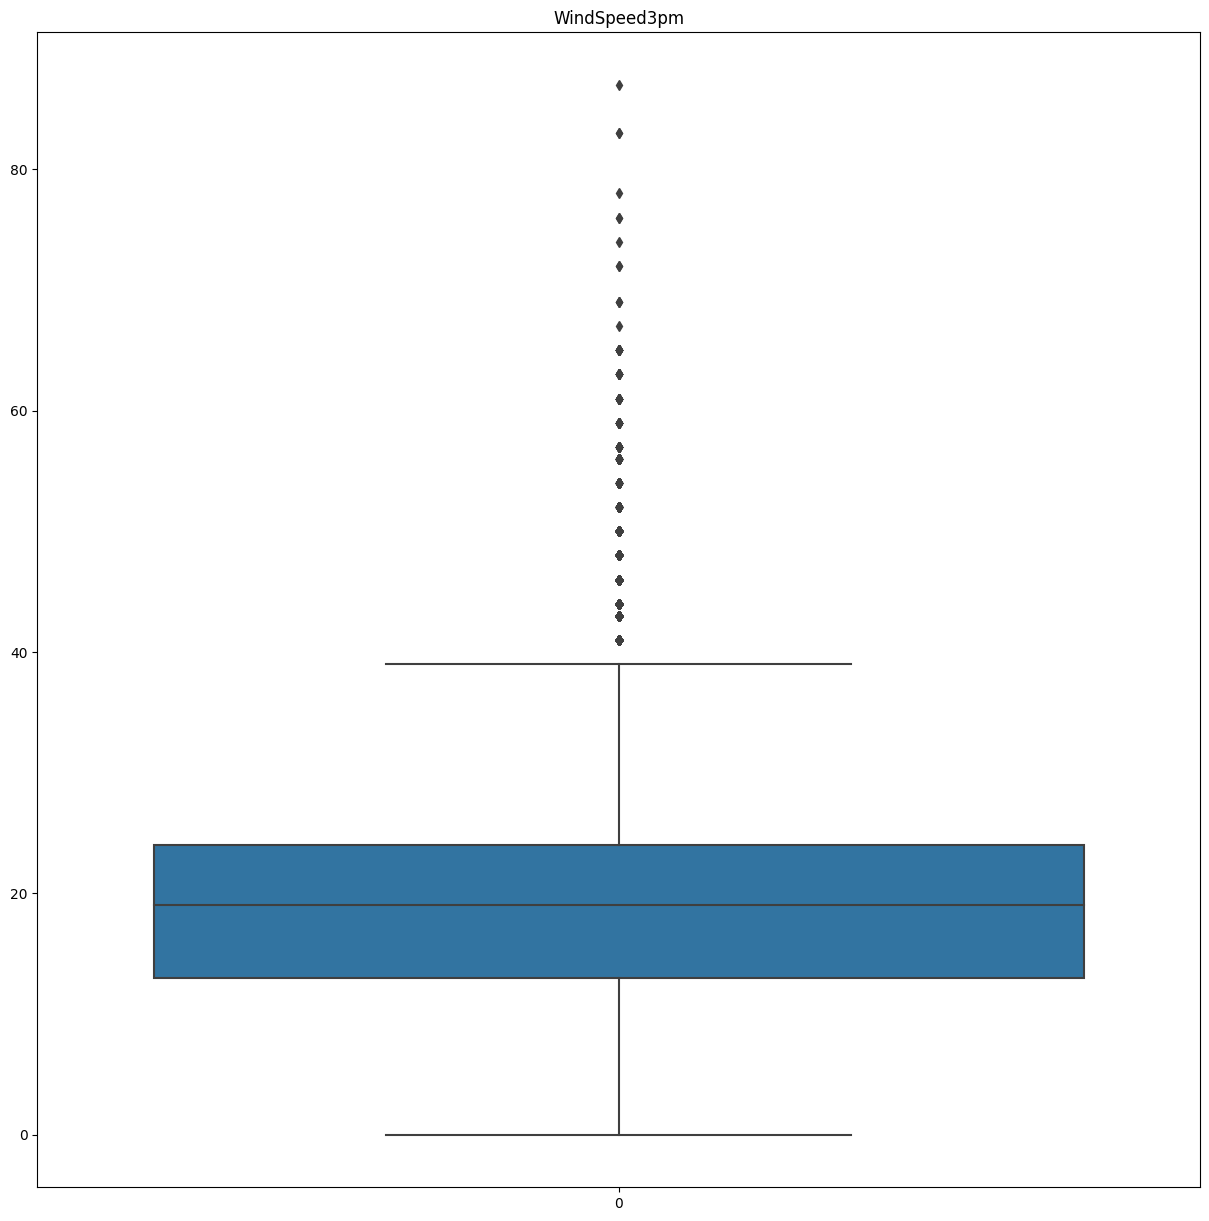

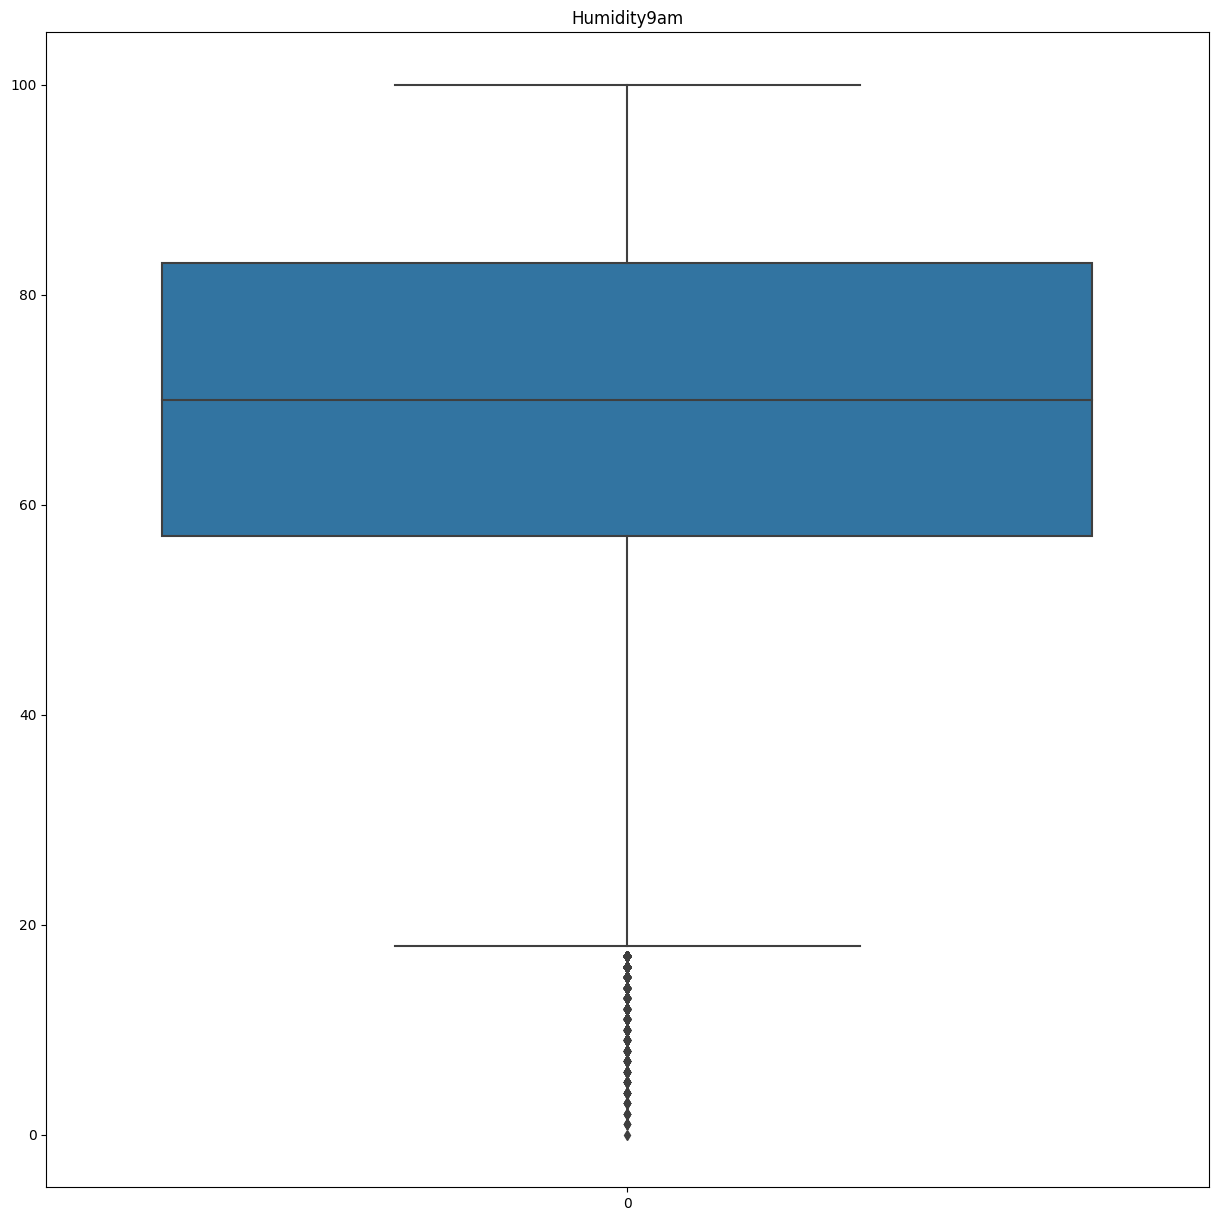

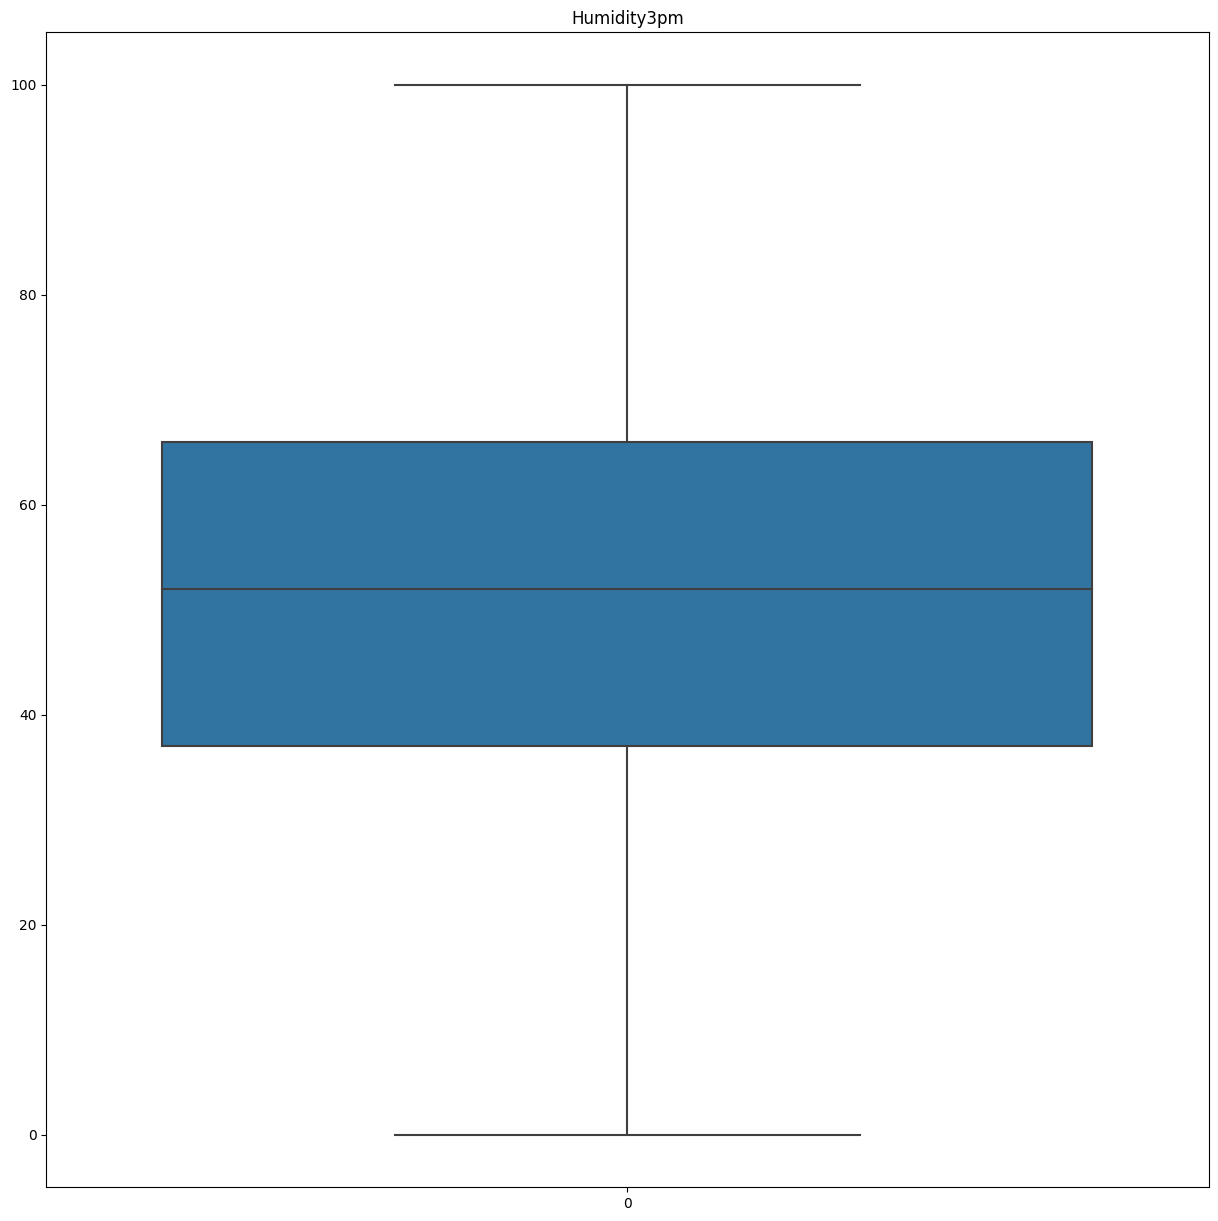

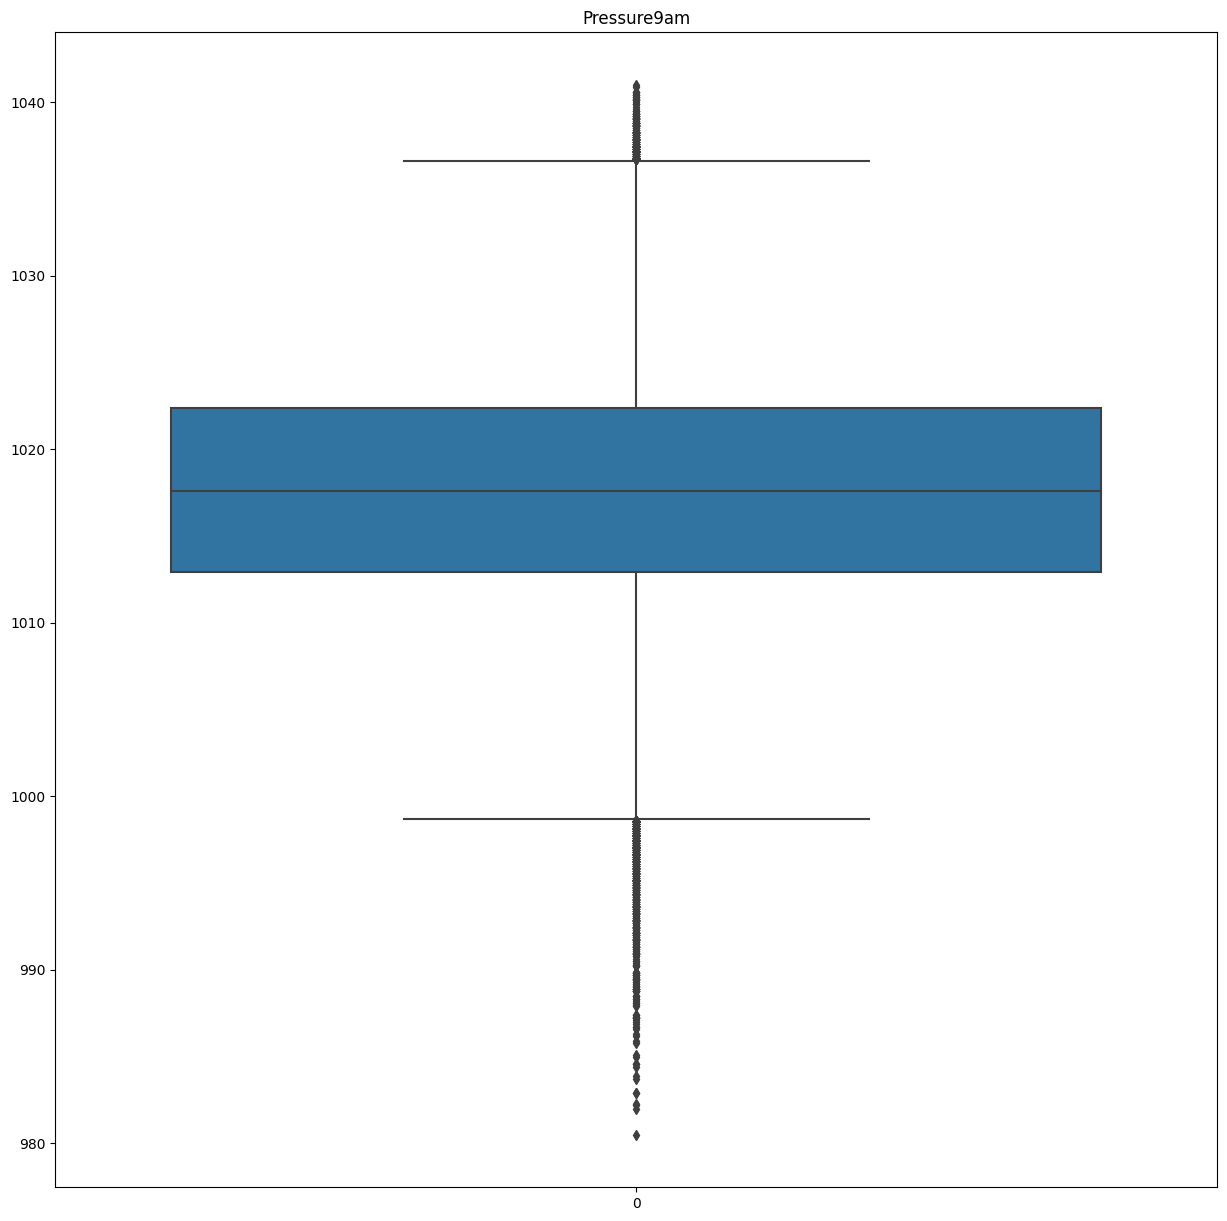

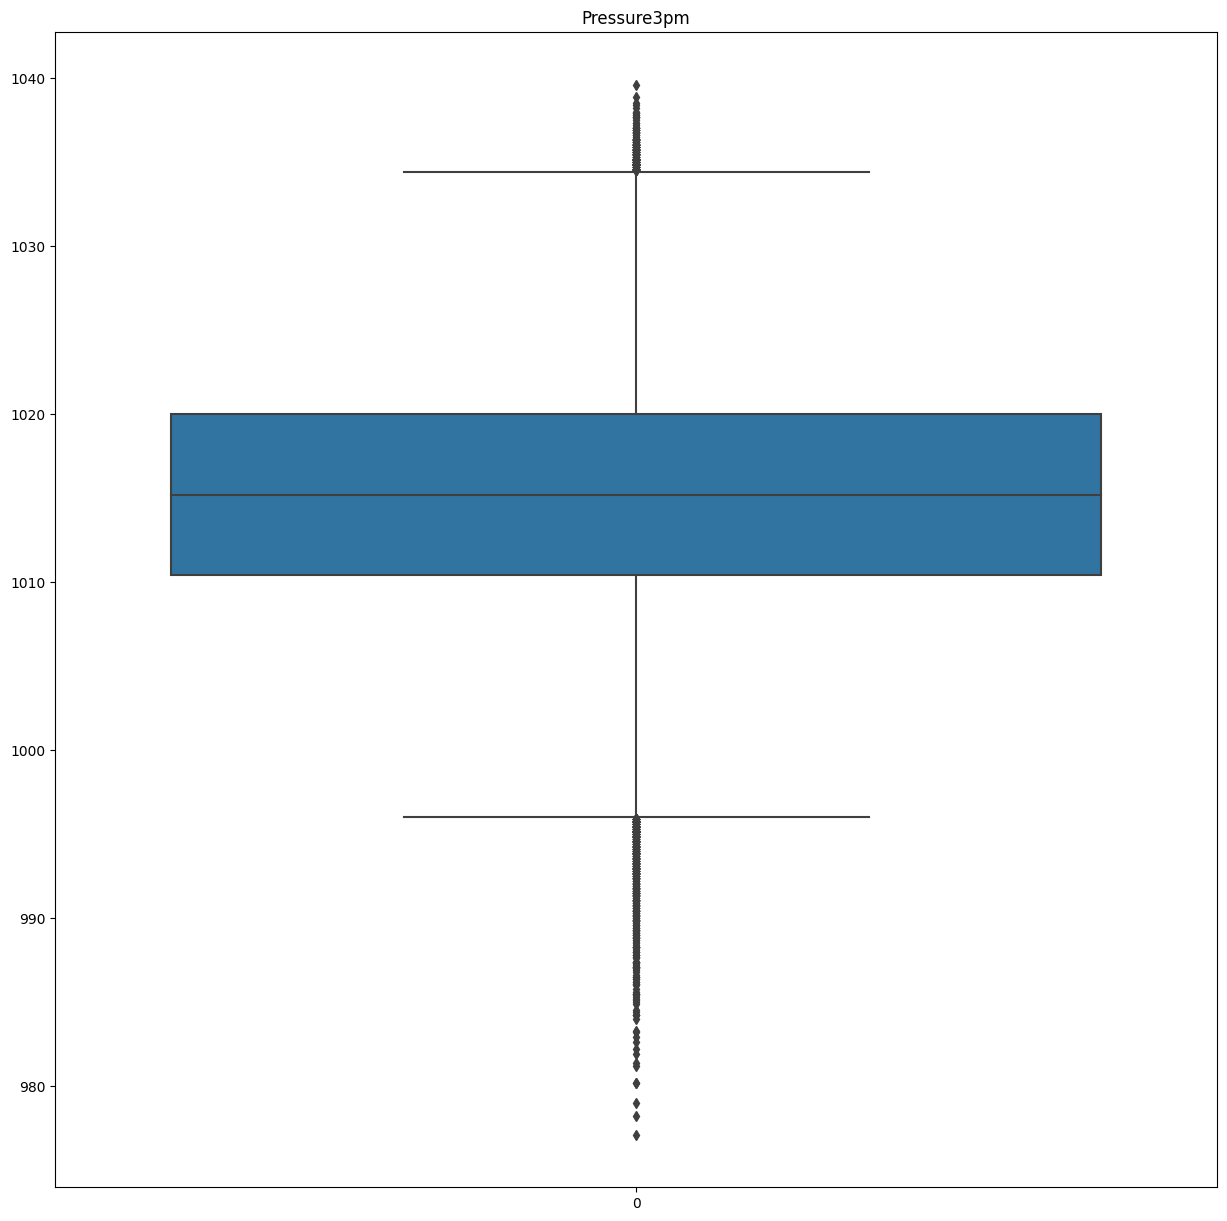

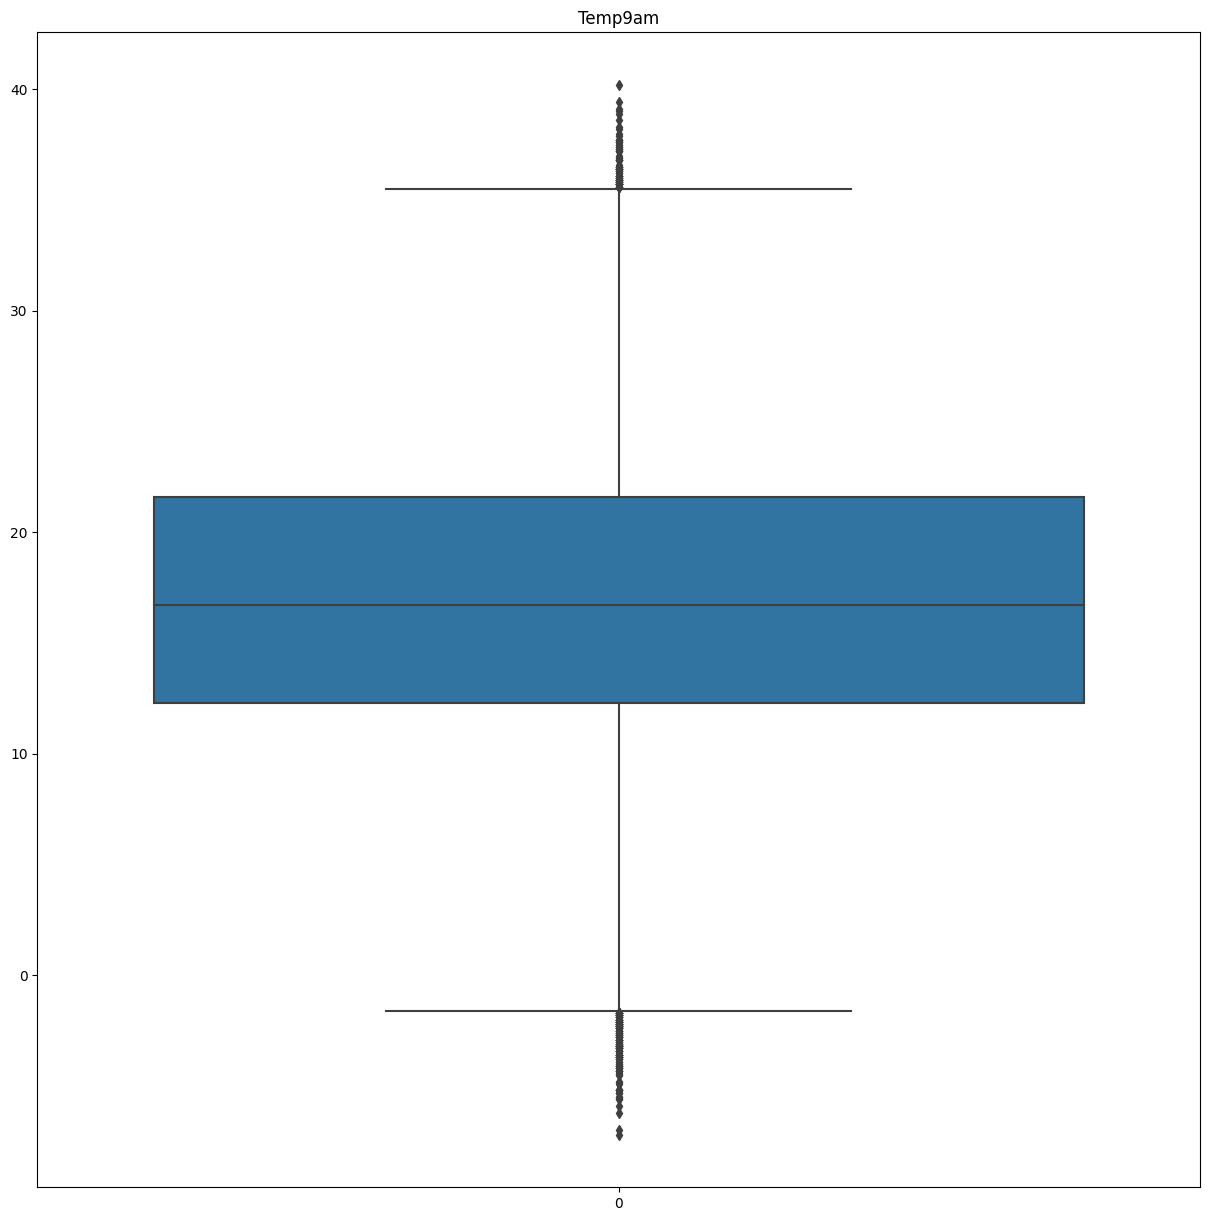

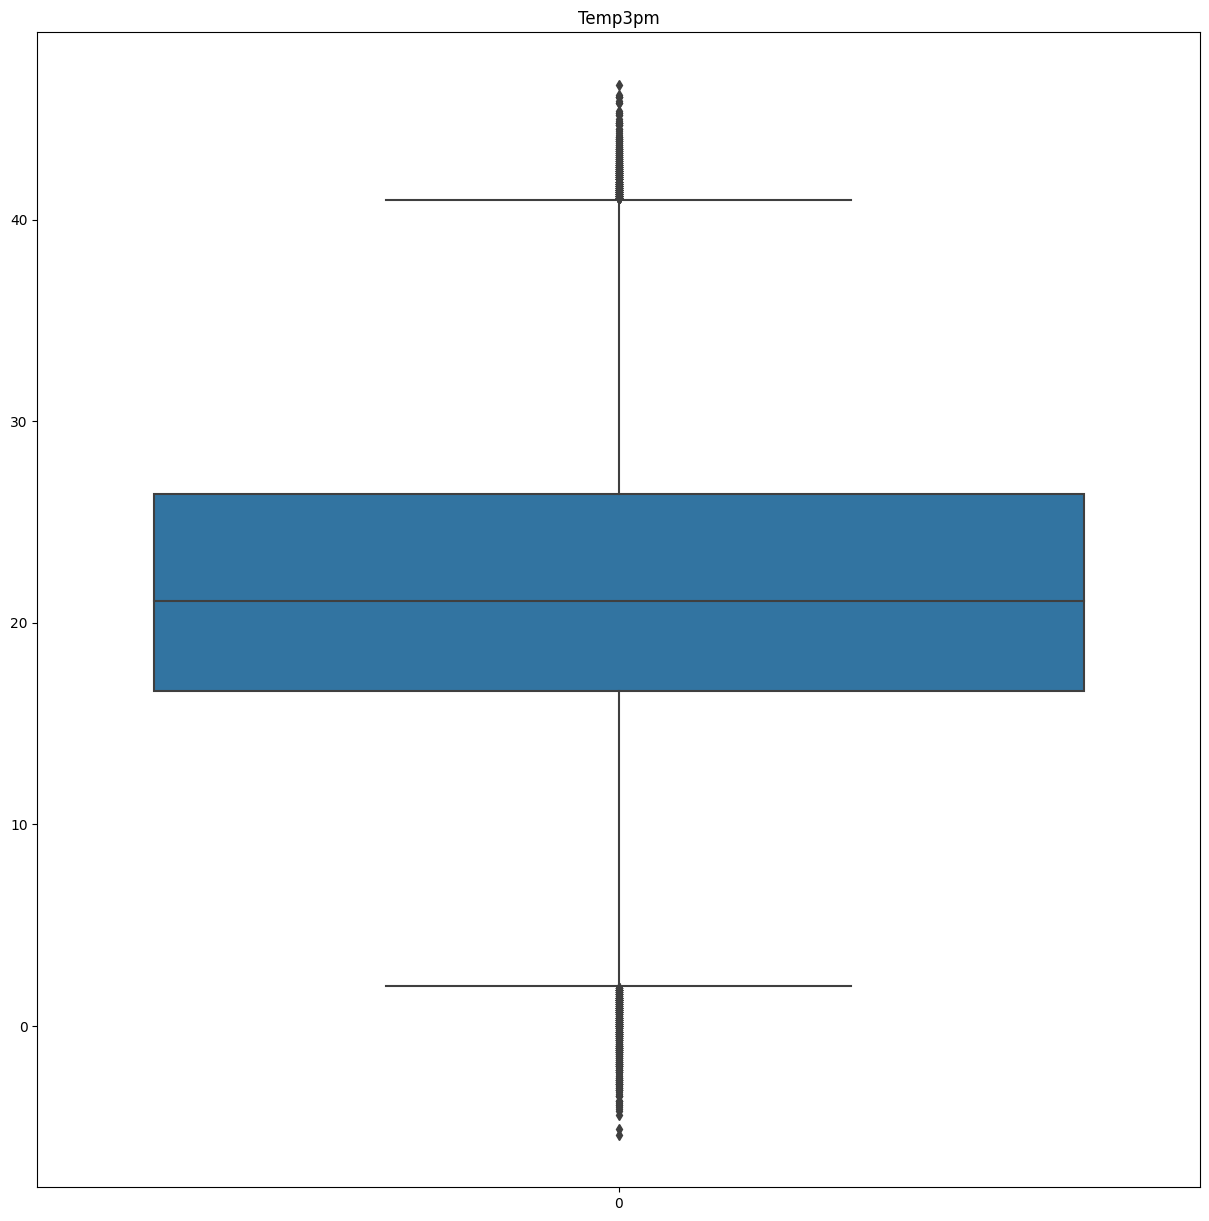

<Figure size 1500x1500 with 0 Axes>

In [11]:
#A for loop is used to plot a boxplot for all the continuous features to see the outliers
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [12]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [13]:
df.isnull().sum()*100/len(df)

Date             0.000000
Location         0.000000
MinTemp          0.000000
MaxTemp          0.000000
Rainfall         0.000000
Evaporation      0.000000
Sunshine         0.000000
WindGustDir      7.098859
WindGustSpeed    0.000000
WindDir9am       7.263853
WindDir3pm       2.906641
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure9am      0.000000
Pressure3pm      0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.000000
Temp3pm          0.000000
RainToday        2.241853
RainTomorrow     2.245978
dtype: float64

In [14]:
discrete_feature

['Cloud9am', 'Cloud3pm']

In [15]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

In [16]:
df["RainToday"] = pd.get_dummies(df["RainToday"], drop_first = True)
df["RainTomorrow"] = pd.get_dummies(df["RainTomorrow"], drop_first = True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [17]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["RainTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['2007-11-01', '2007-12-15', '2008-02-03', '2008-01-31', '2008-01-30',
       '2008-01-19', '2008-01-18', '2008-01-16', '2008-01-12', '2007-11-30',
       ...
       '2008-05-08', '2008-05-09', '2008-01-03', '2008-01-02', '2008-05-10',
       '2008-05-11', '2008-05-12', '2008-05-13', '2008-05-14', '2007-12-25'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'NorfolkIsland',
       'MountGambier', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'MountGinini',
       'NorahHead', 'Darwin', 'Sydney', 'SydneyAirport', 'Ballarat',
       'GoldCoast', 'Watsonia', 'Newcastle', 'Hobart', 'Wollongong',
       'Williamtown', 'Launceston', 'Brisbane', 'MelbourneAirport', 'Adelaide',
       'Sale', 'Albury', 'Perth', 'Melbourne', 'Nuriootpa', 'Penrith',
       'BadgerysCreek', 'PerthAirport', 'Tuggeranong', 'Richmond', 'Bendigo',
       'Canberra', 'WaggaWagga', 'Townsville', 'Katherine', 'PearceRAAF',
       'SalmonGums', 'Nhil', 

In [18]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)

In [19]:
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])

In [20]:
df.isnull().sum()*100/len(df)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [21]:
df1 = df.groupby(["Location"])["RainTomorrow"].value_counts().sort_values().unstack()

In [22]:
df1

RainTomorrow,0,1
Location,,
Adelaide,2505,688
Albany,2138,902
Albury,2422,618
AliceSprings,2796,244
BadgerysCreek,2426,583
Ballarat,2259,781
Bendigo,2478,562
Brisbane,2484,709
Cairns,2090,950


In [23]:
df1[1].sort_values(ascending = False)

Location
Portland            1095
Cairns               950
Walpole              949
Dartmoor             922
MountGambier         920
NorfolkIsland        919
Albany               902
Witchcliffe          879
CoffsHarbour         869
Sydney               865
Darwin               852
MountGinini          819
NorahHead            808
Ballarat             781
GoldCoast            775
SydneyAirport        774
Hobart               761
Watsonia             738
Newcastle            731
Wollongong           713
Brisbane             709
Williamtown          700
Launceston           699
Adelaide             688
MelbourneAirport     653
Perth                645
Sale                 643
Melbourne            636
Canberra             629
Albury               618
Penrith              595
Nuriootpa            592
BadgerysCreek        583
Tuggeranong          568
PerthAirport         567
Bendigo              562
Richmond             560
WaggaWagga           536
Townsville           519
PearceRAAF      

In [24]:
df1[1].sort_values(ascending = False).index

Index(['Portland', 'Cairns', 'Walpole', 'Dartmoor', 'MountGambier',
       'NorfolkIsland', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'Sydney',
       'Darwin', 'MountGinini', 'NorahHead', 'Ballarat', 'GoldCoast',
       'SydneyAirport', 'Hobart', 'Watsonia', 'Newcastle', 'Wollongong',
       'Brisbane', 'Williamtown', 'Launceston', 'Adelaide', 'MelbourneAirport',
       'Perth', 'Sale', 'Melbourne', 'Canberra', 'Albury', 'Penrith',
       'Nuriootpa', 'BadgerysCreek', 'Tuggeranong', 'PerthAirport', 'Bendigo',
       'Richmond', 'WaggaWagga', 'Townsville', 'PearceRAAF', 'SalmonGums',
       'Moree', 'Cobar', 'Mildura', 'Katherine', 'AliceSprings', 'Nhil',
       'Woomera', 'Uluru'],
      dtype='object', name='Location')

In [25]:
len(df1[1].sort_values(ascending = False).index)

49

In [26]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}
df["Location"] = df["Location"].map(location)

In [27]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [28]:
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [29]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,49,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,6,21
145456,2017-06-22,49,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,6,22
145457,2017-06-23,49,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,6,23
145458,2017-06-24,49,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,6,24


C:\Users\Sammitha S Poojary\AppData\Local\Temp\ipykernel_16920\3423568062.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


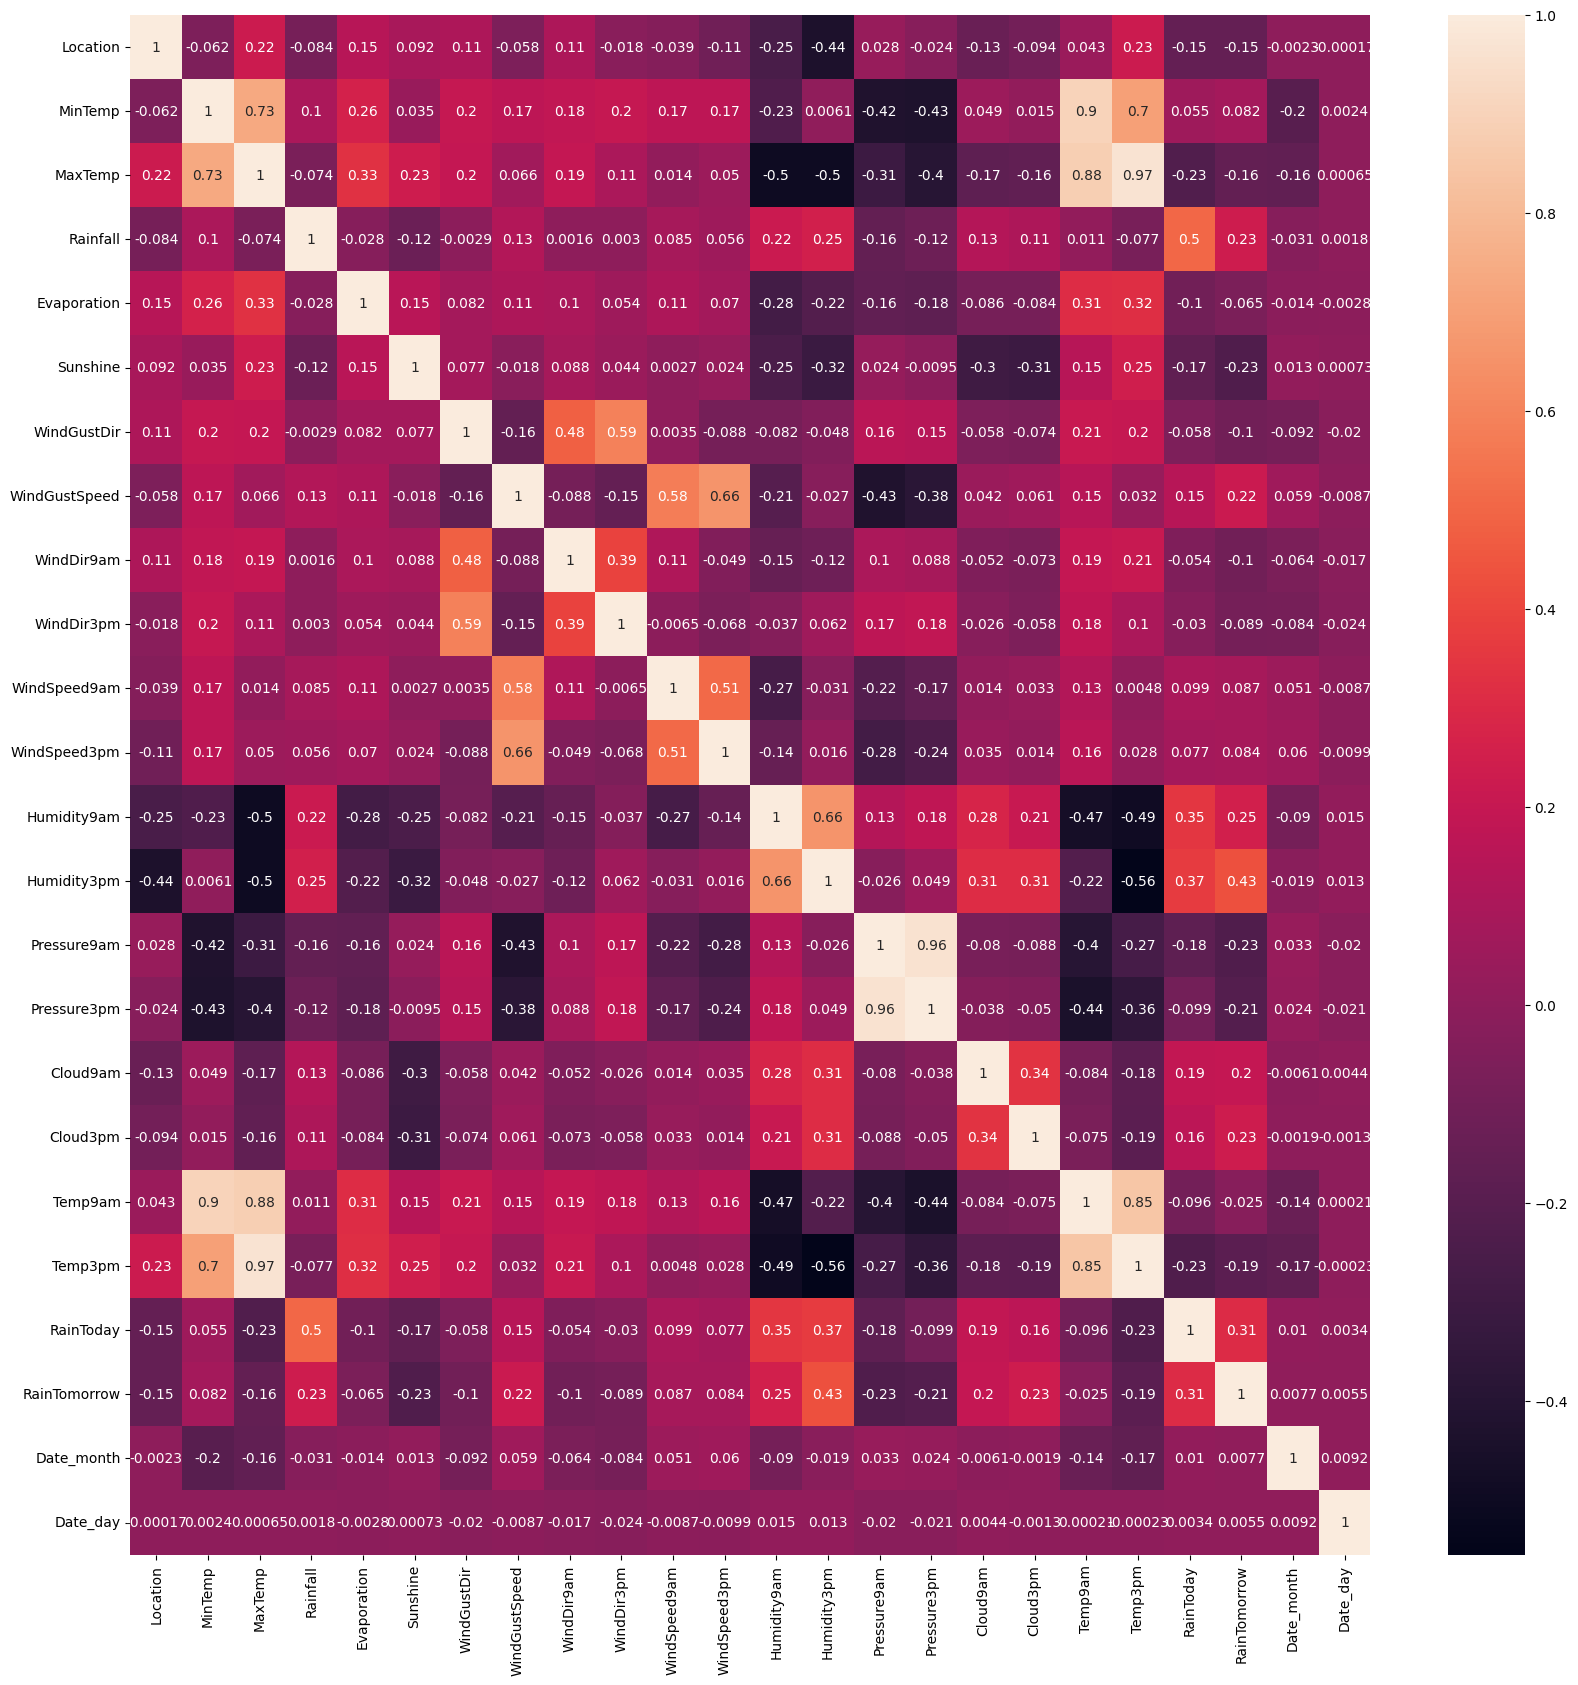

In [30]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

<Axes: ylabel='count'>

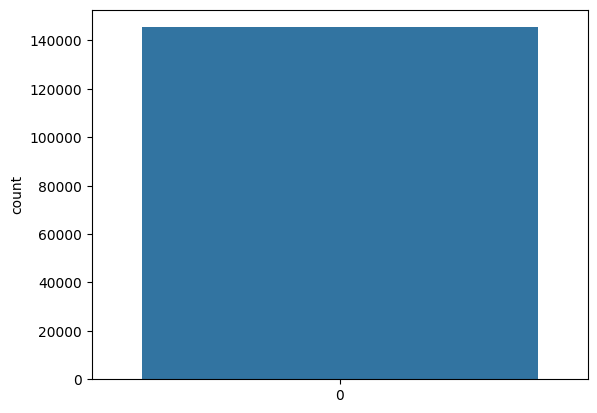

In [31]:
sns.countplot(df["RainTomorrow"])

In [32]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,49,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,6,21
145456,2017-06-22,49,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,6,22
145457,2017-06-23,49,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,6,23
145458,2017-06-24,49,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,6,24


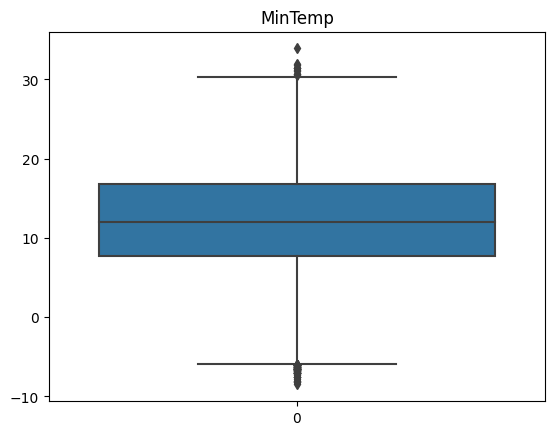

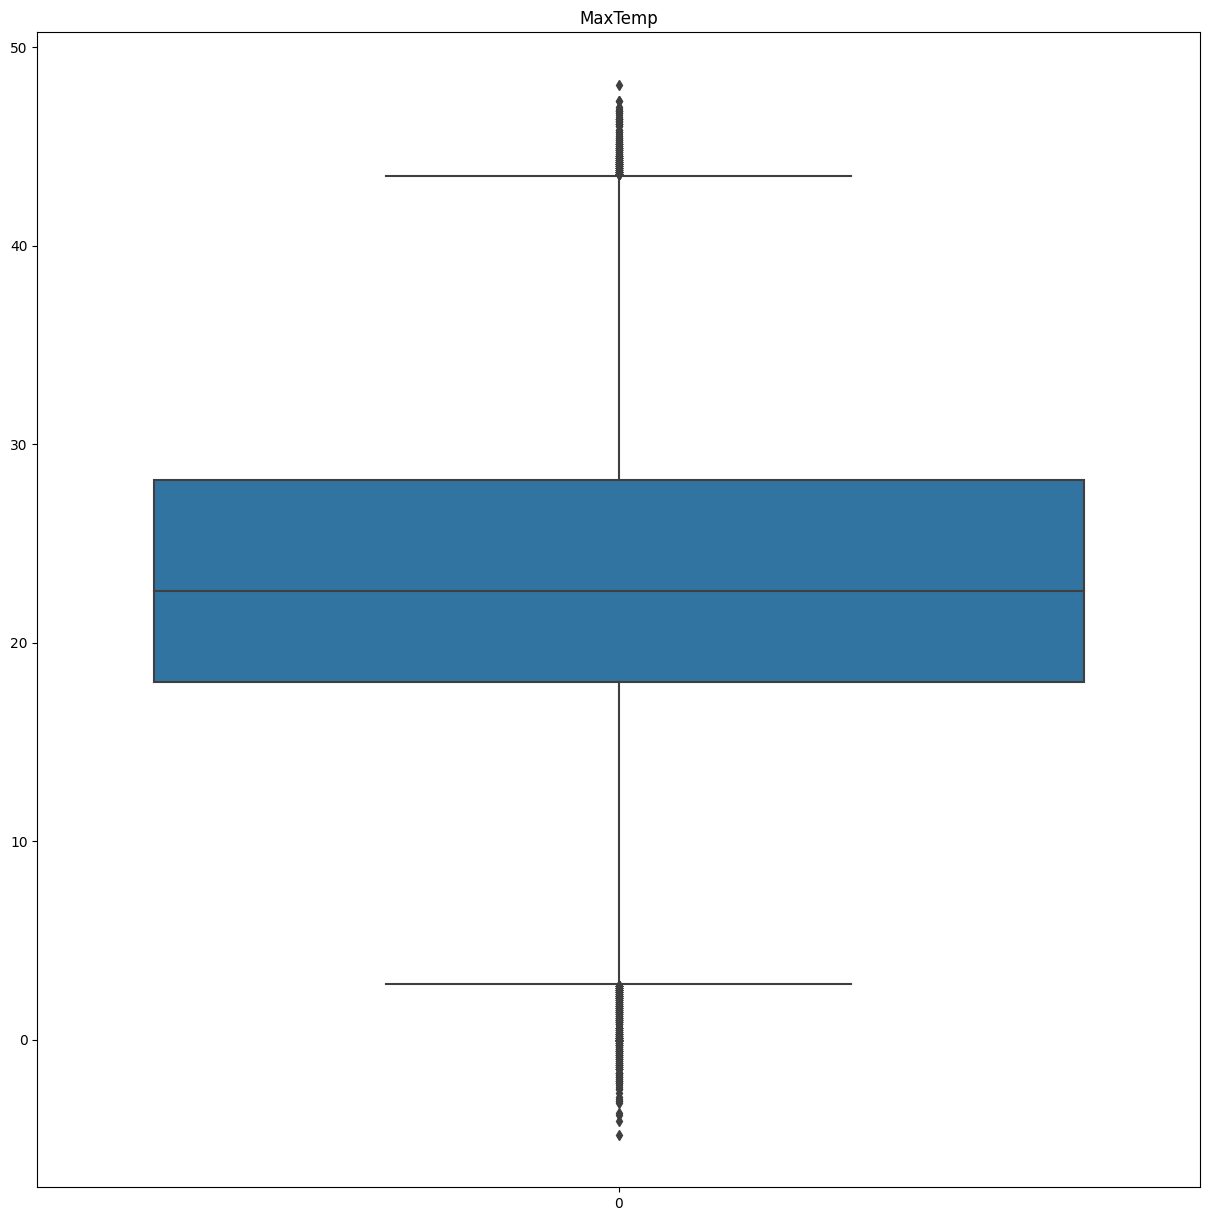

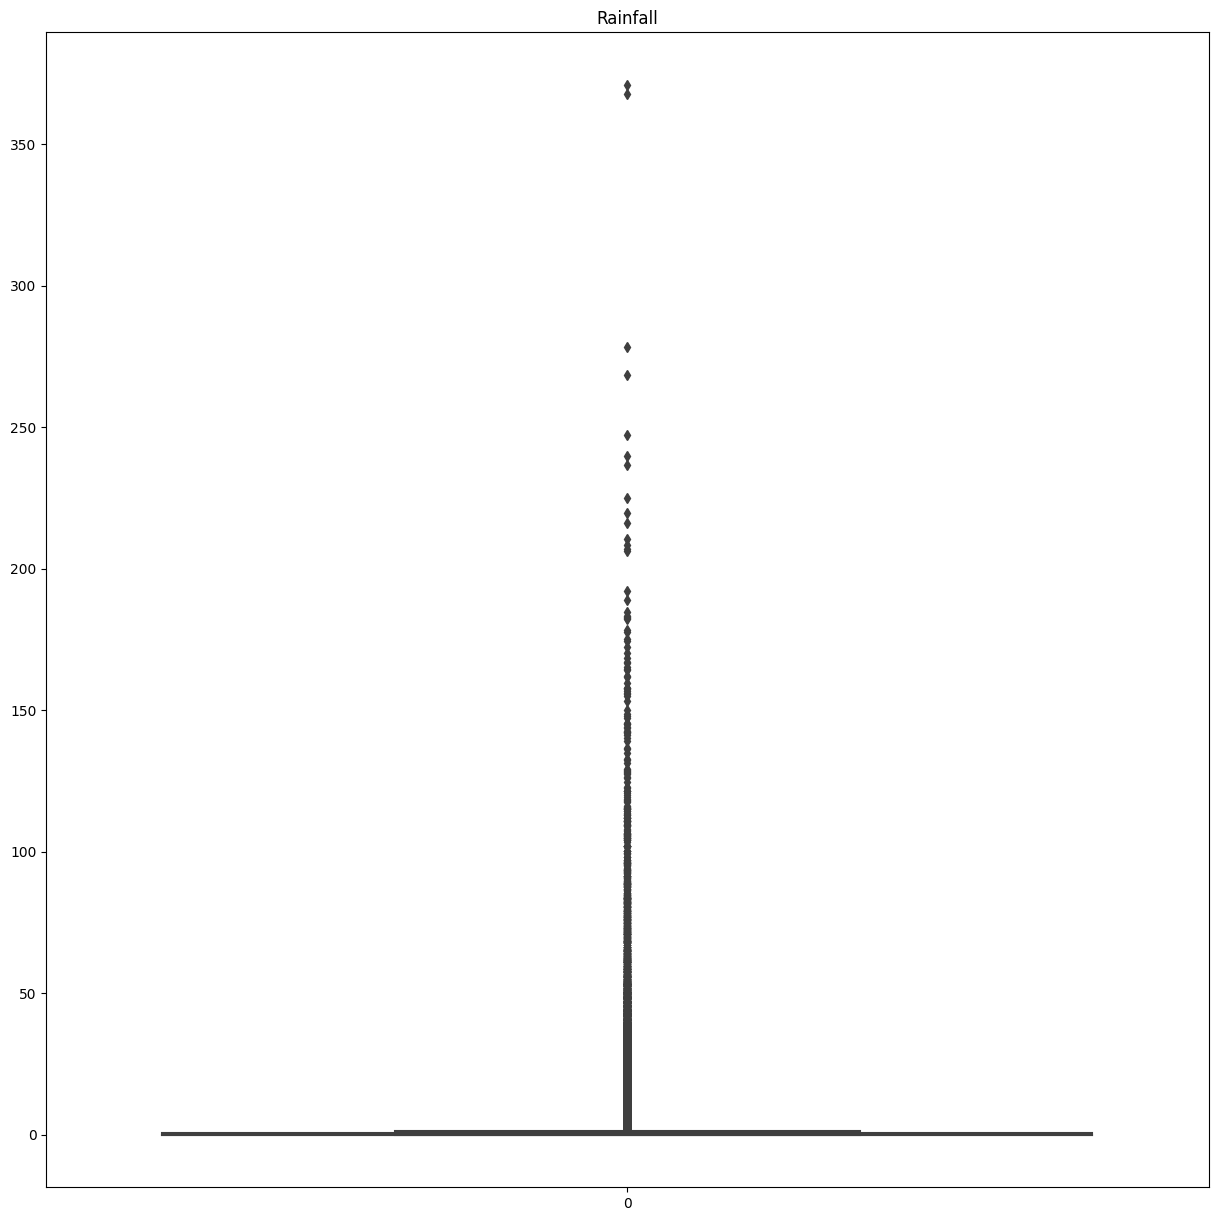

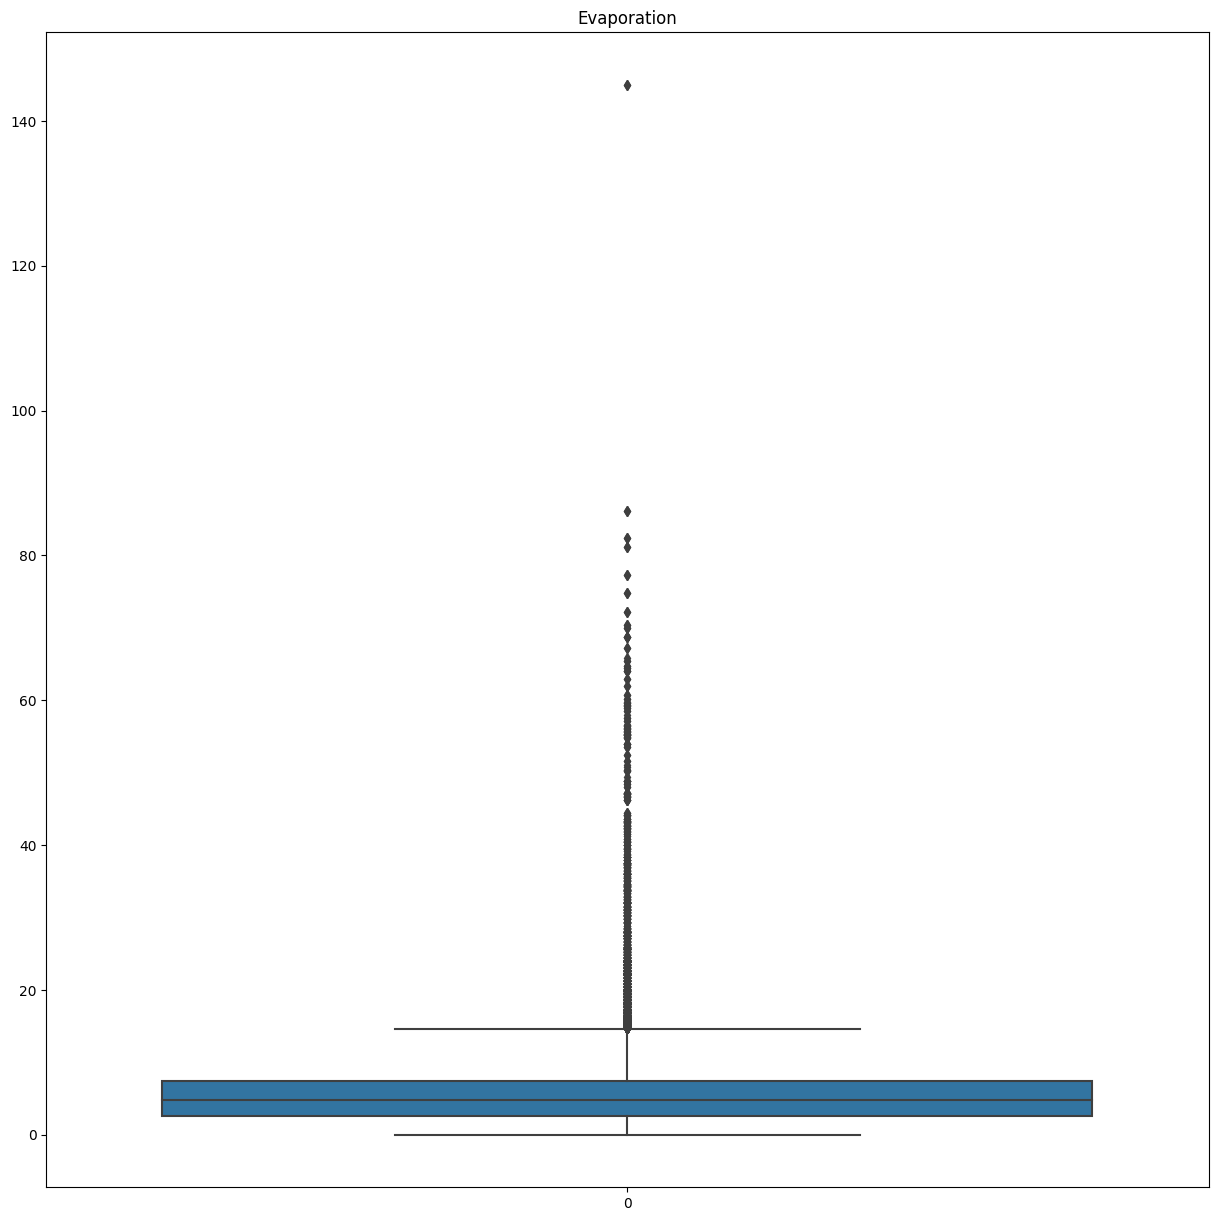

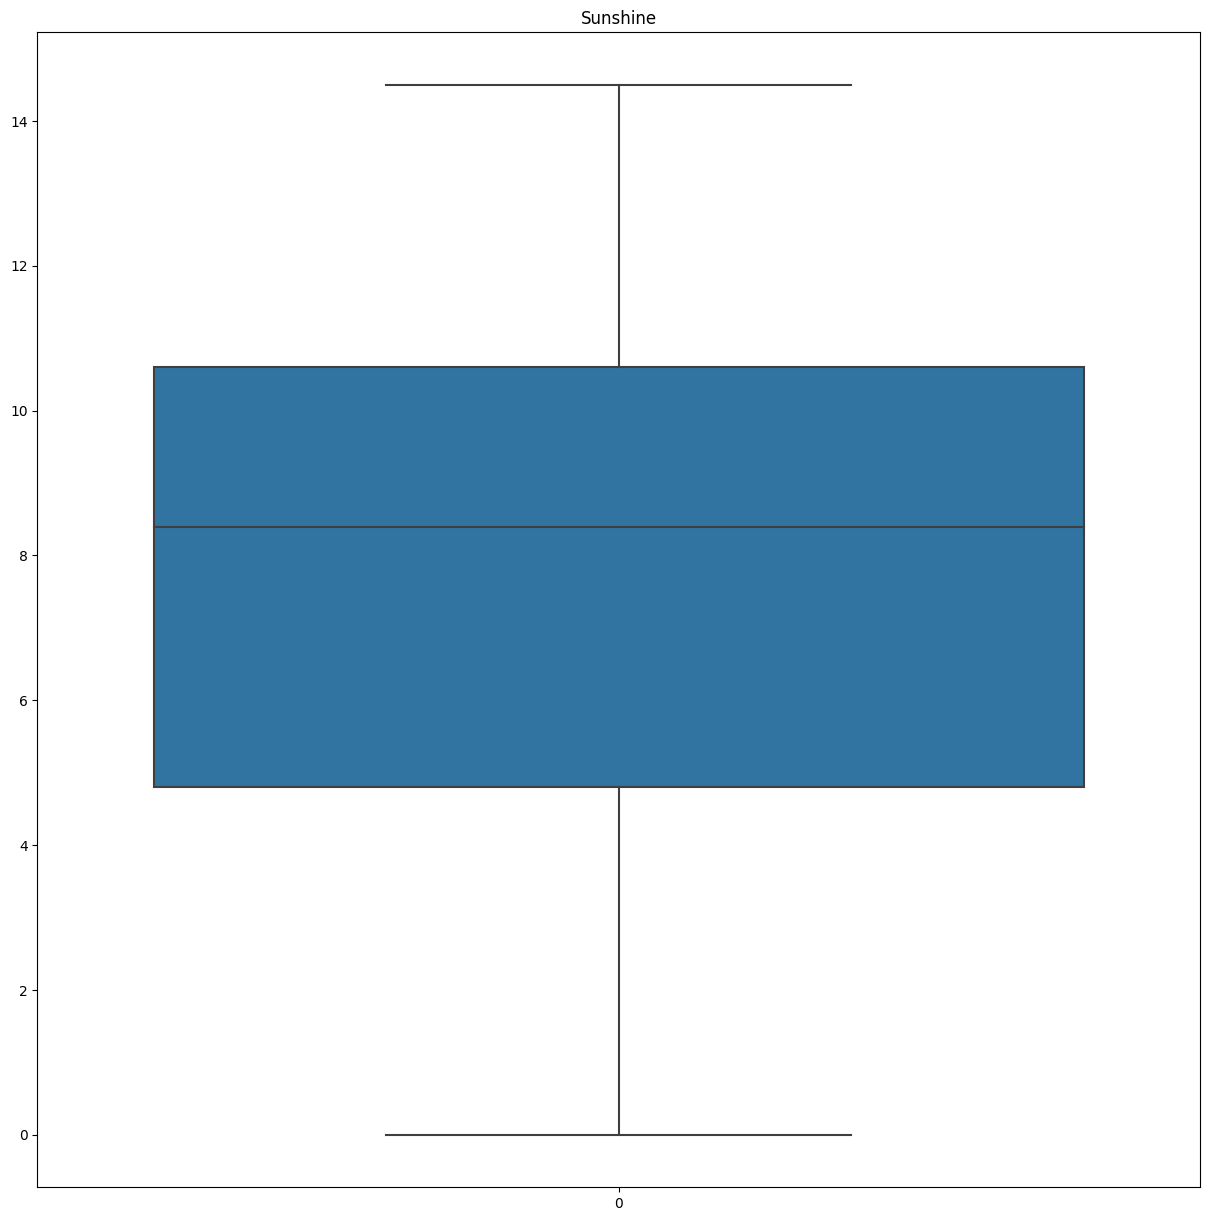

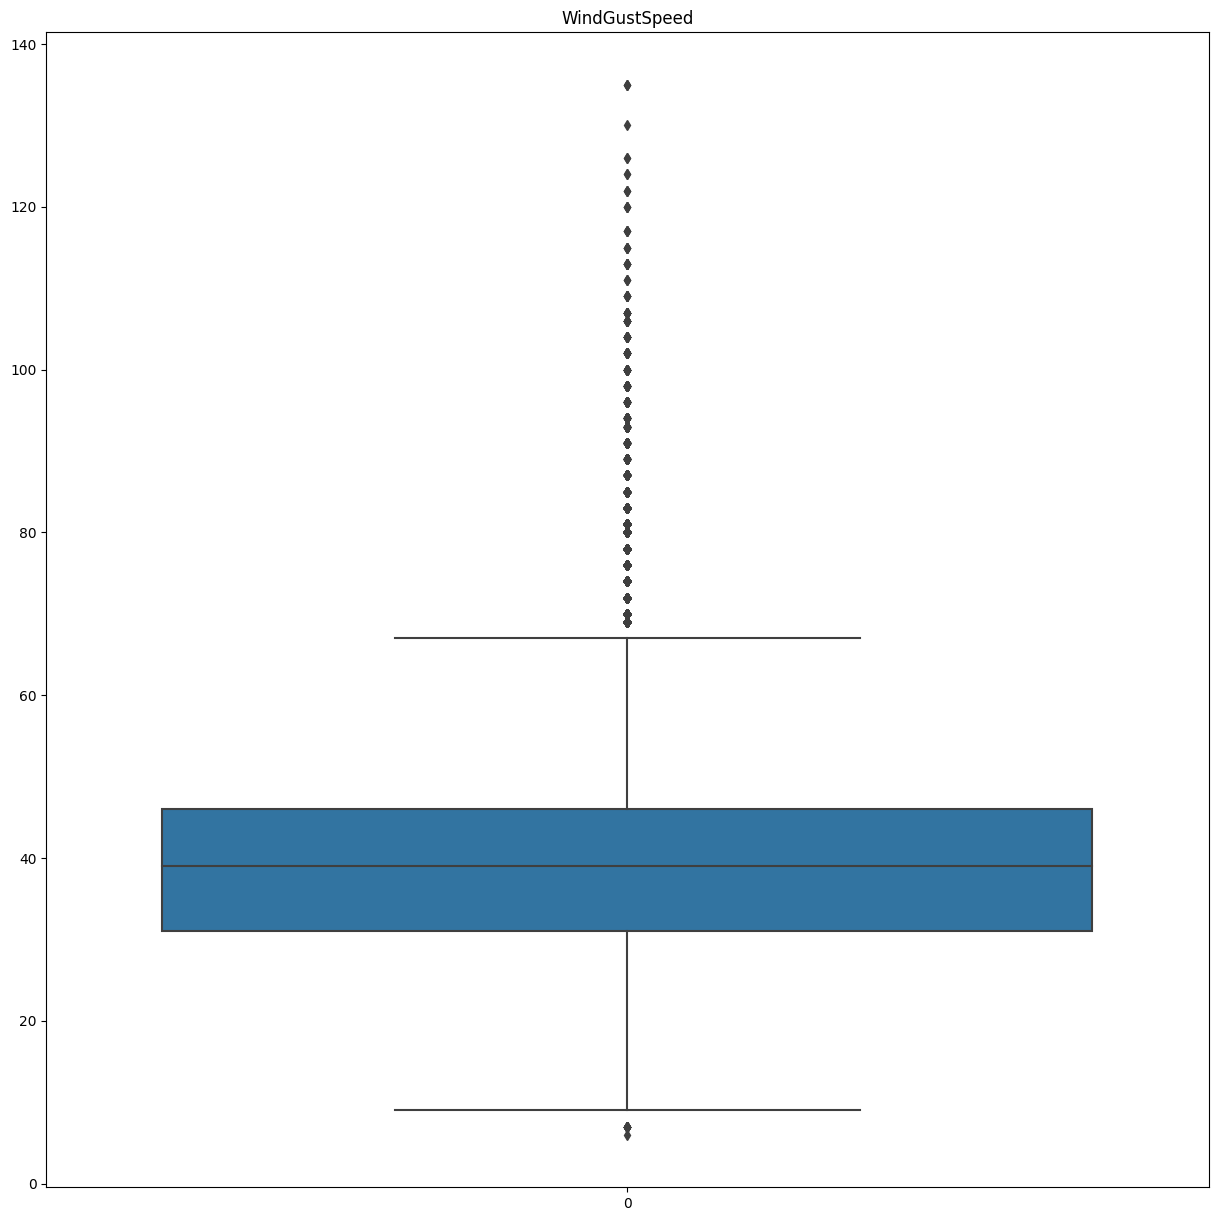

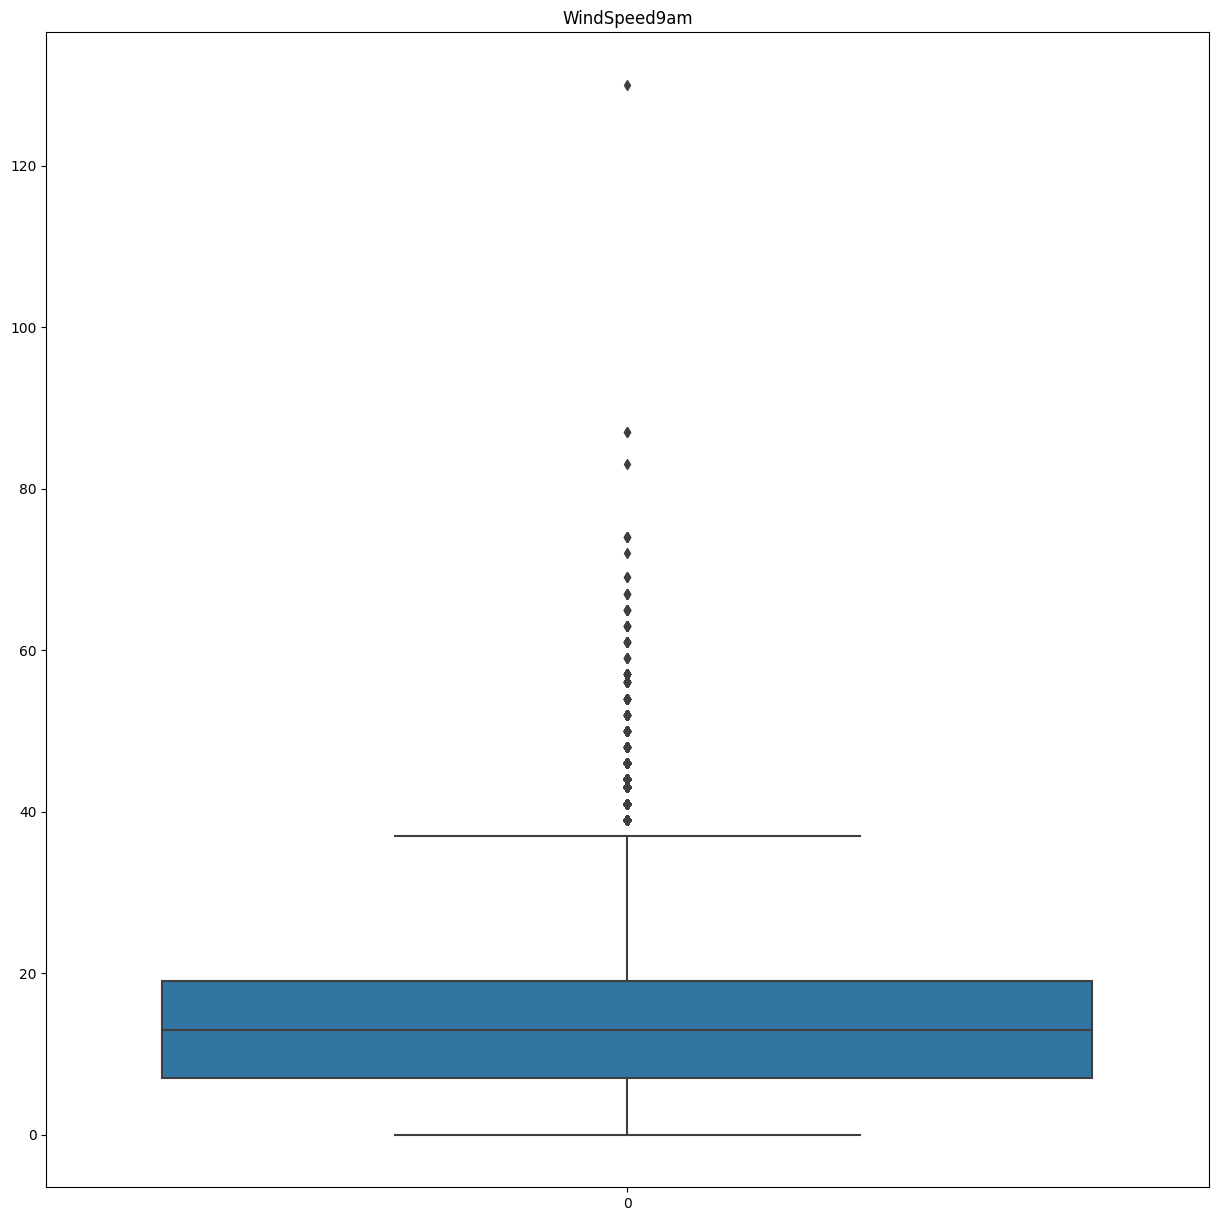

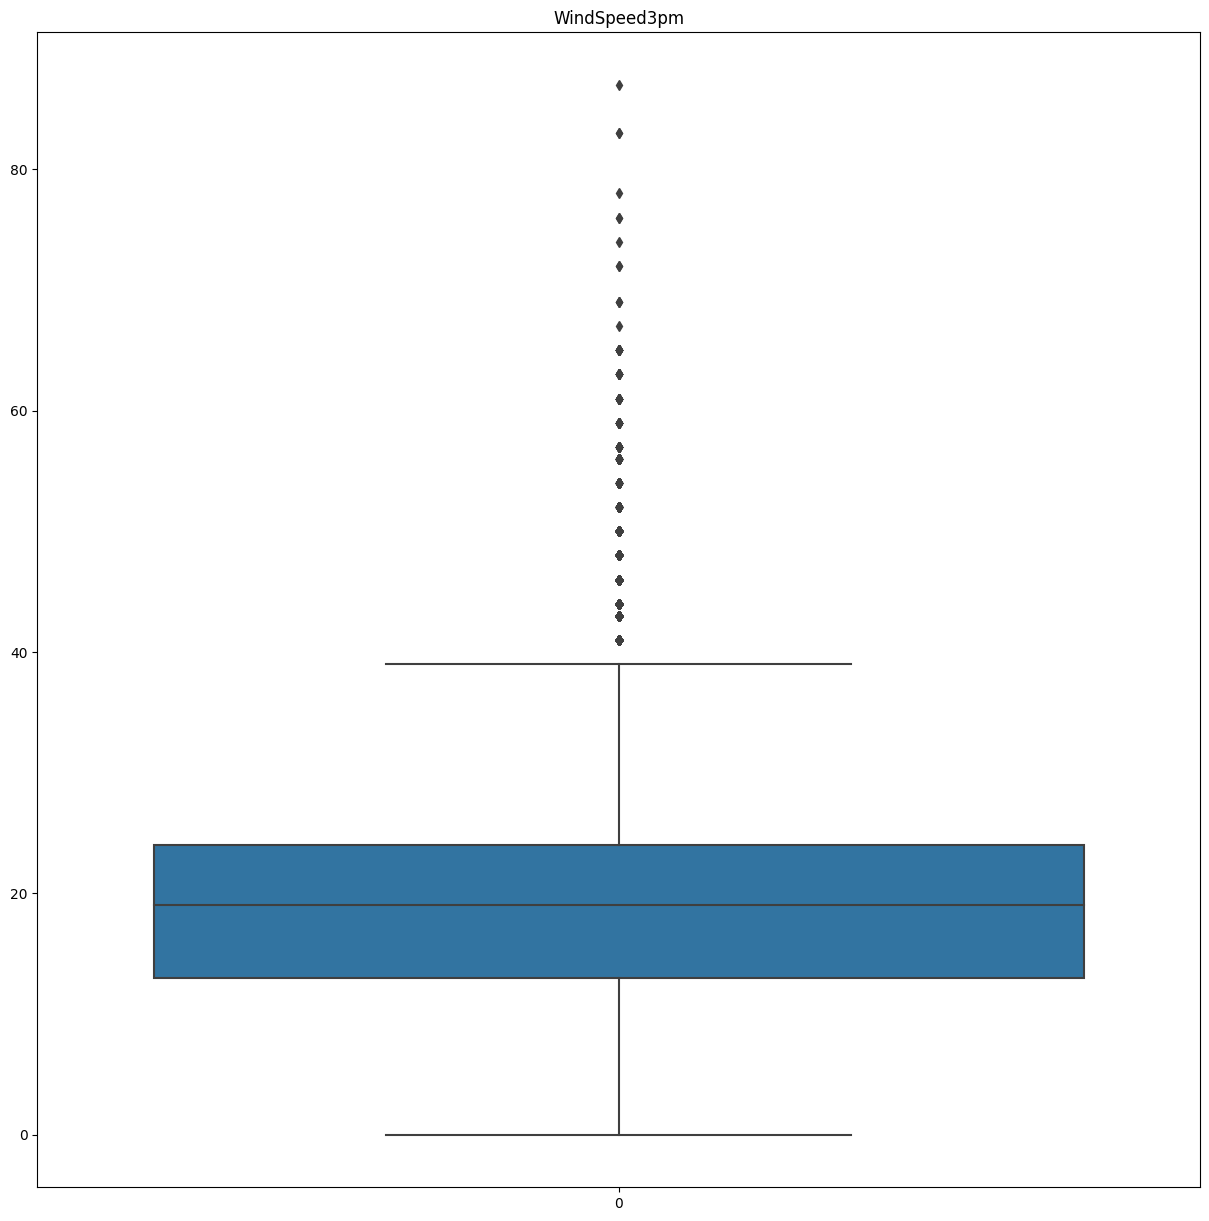

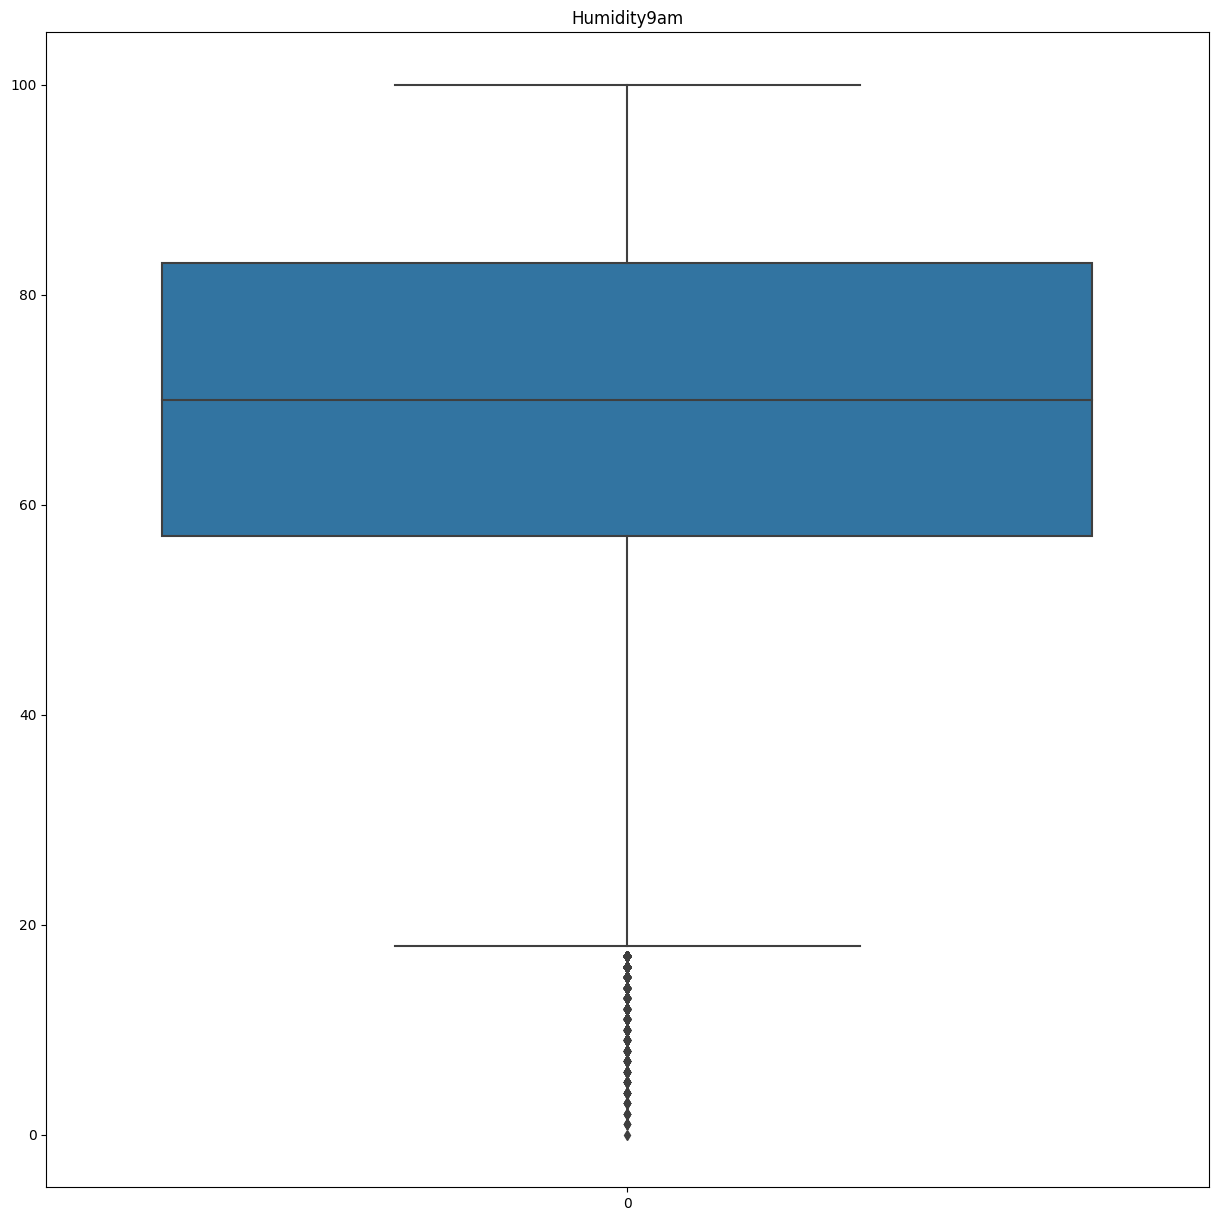

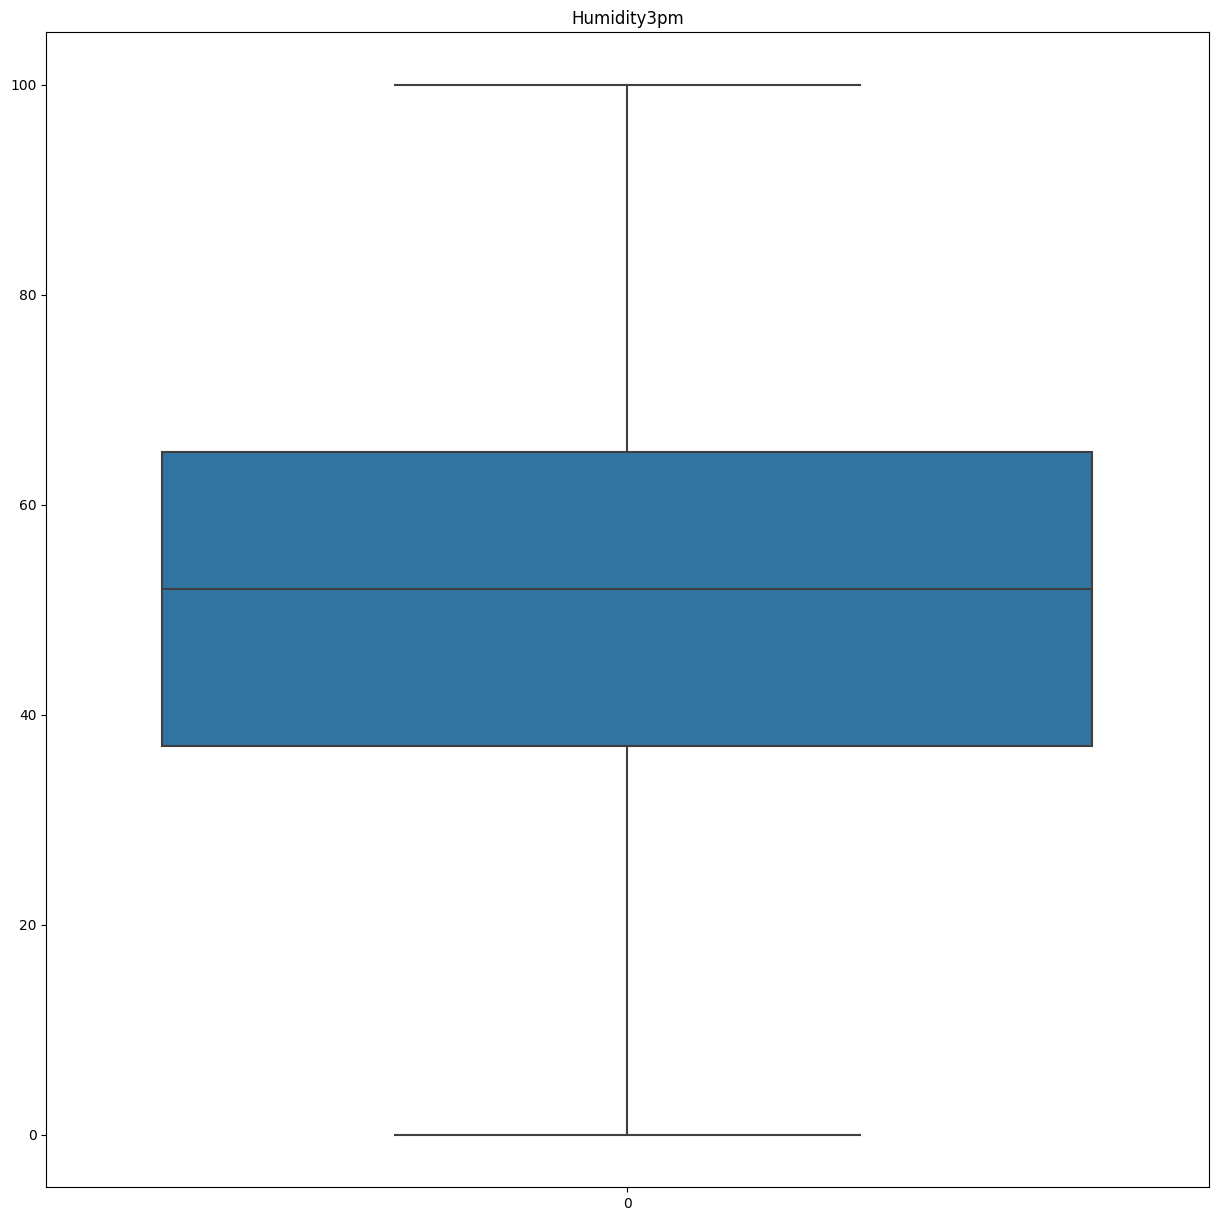

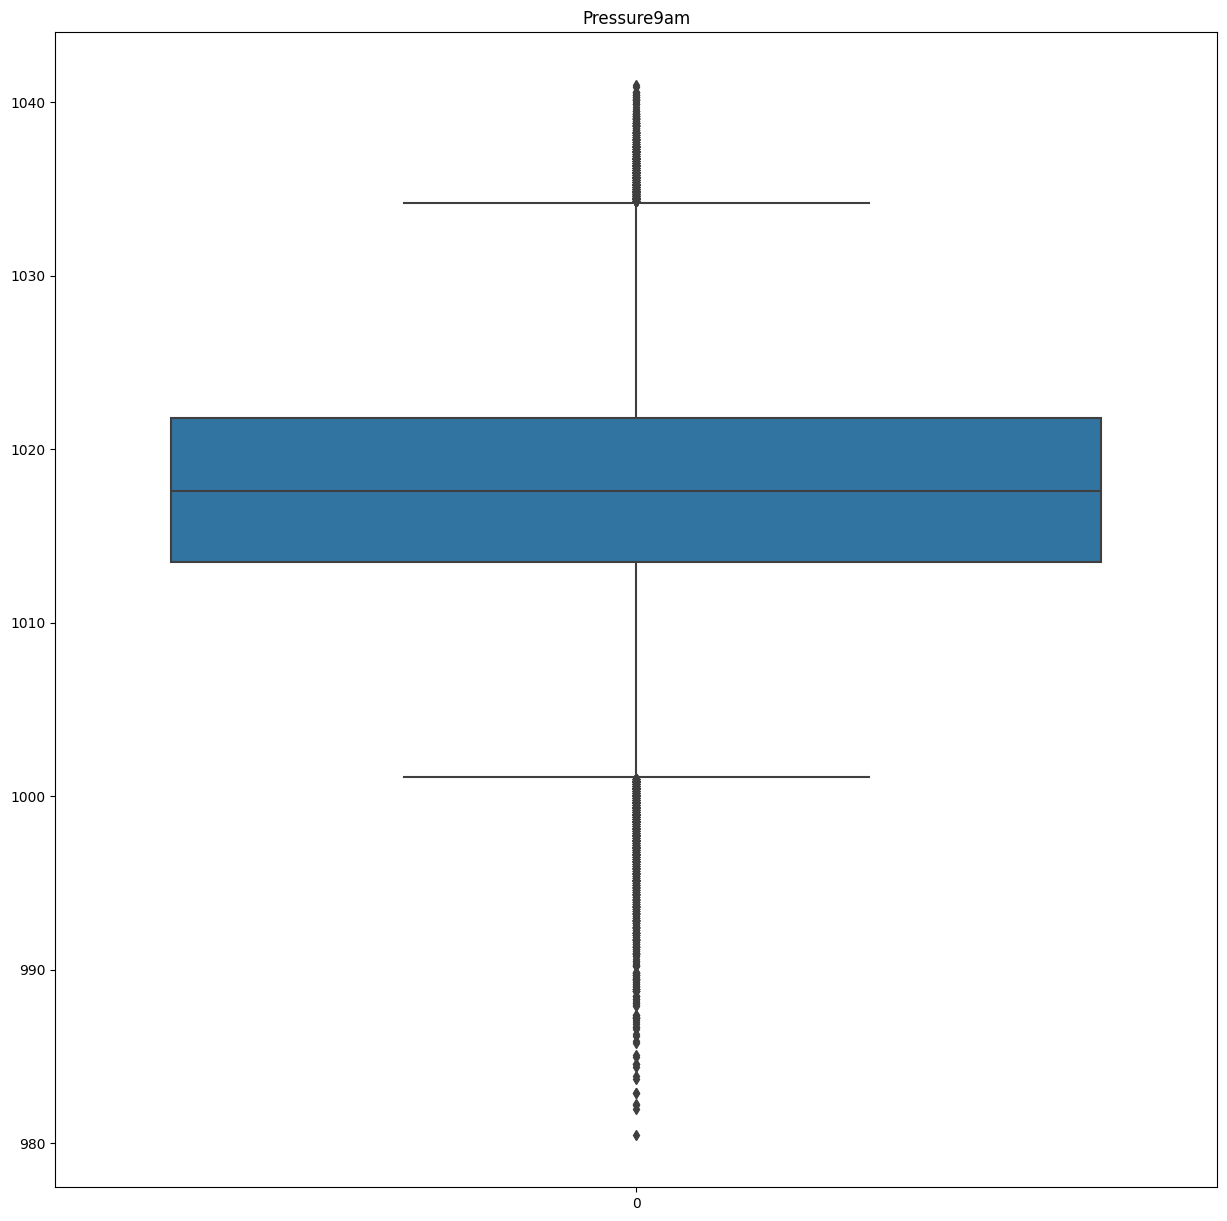

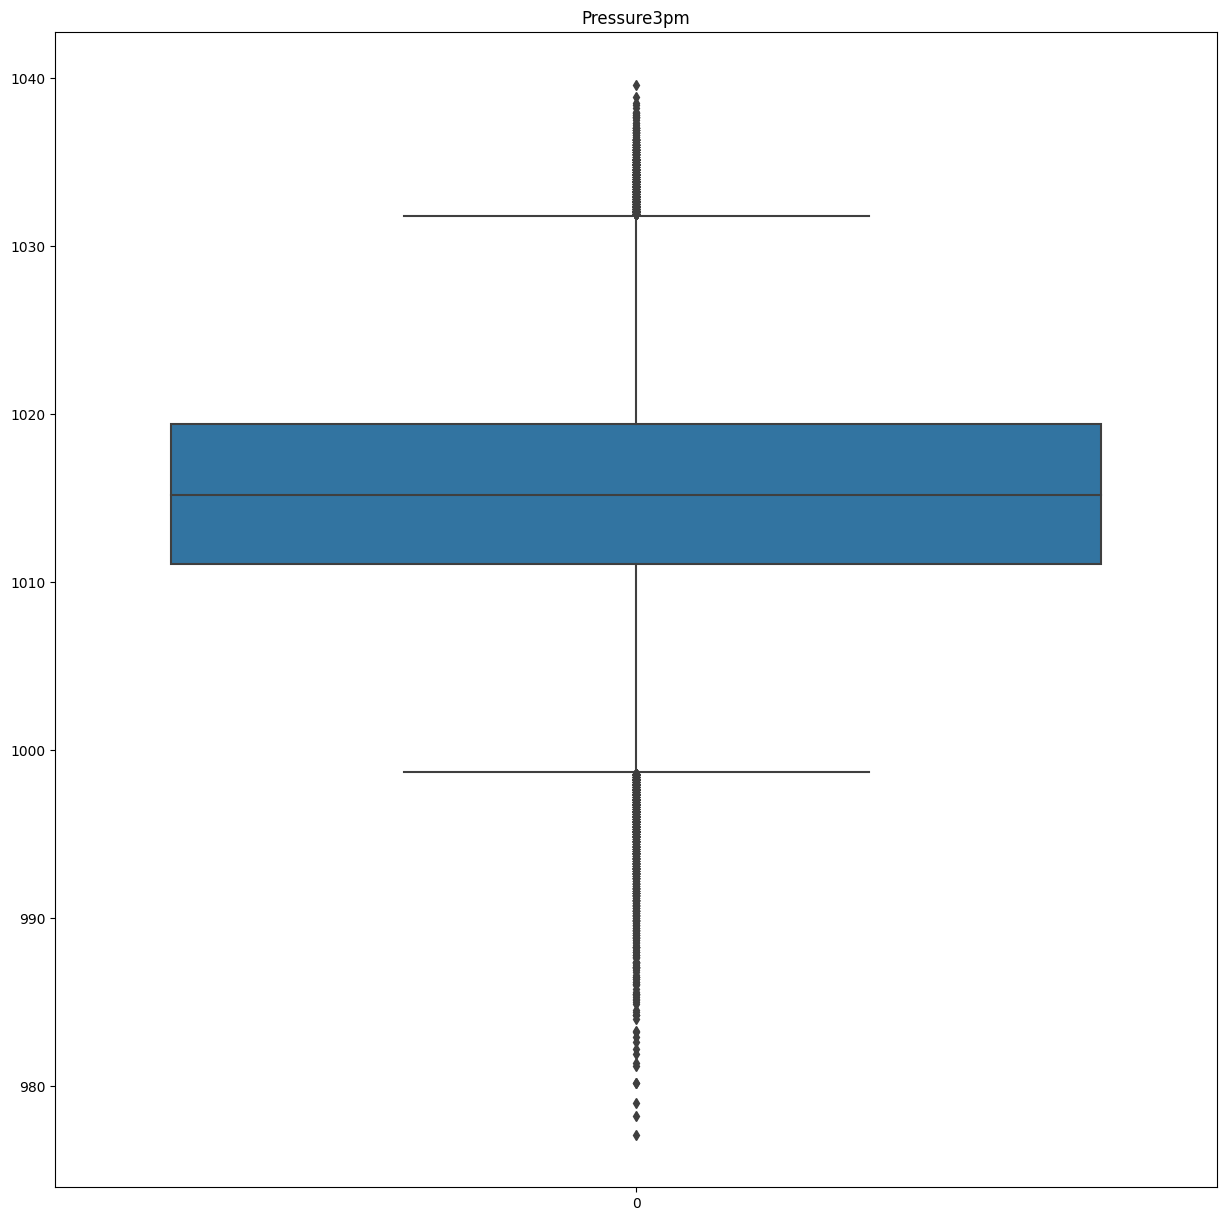

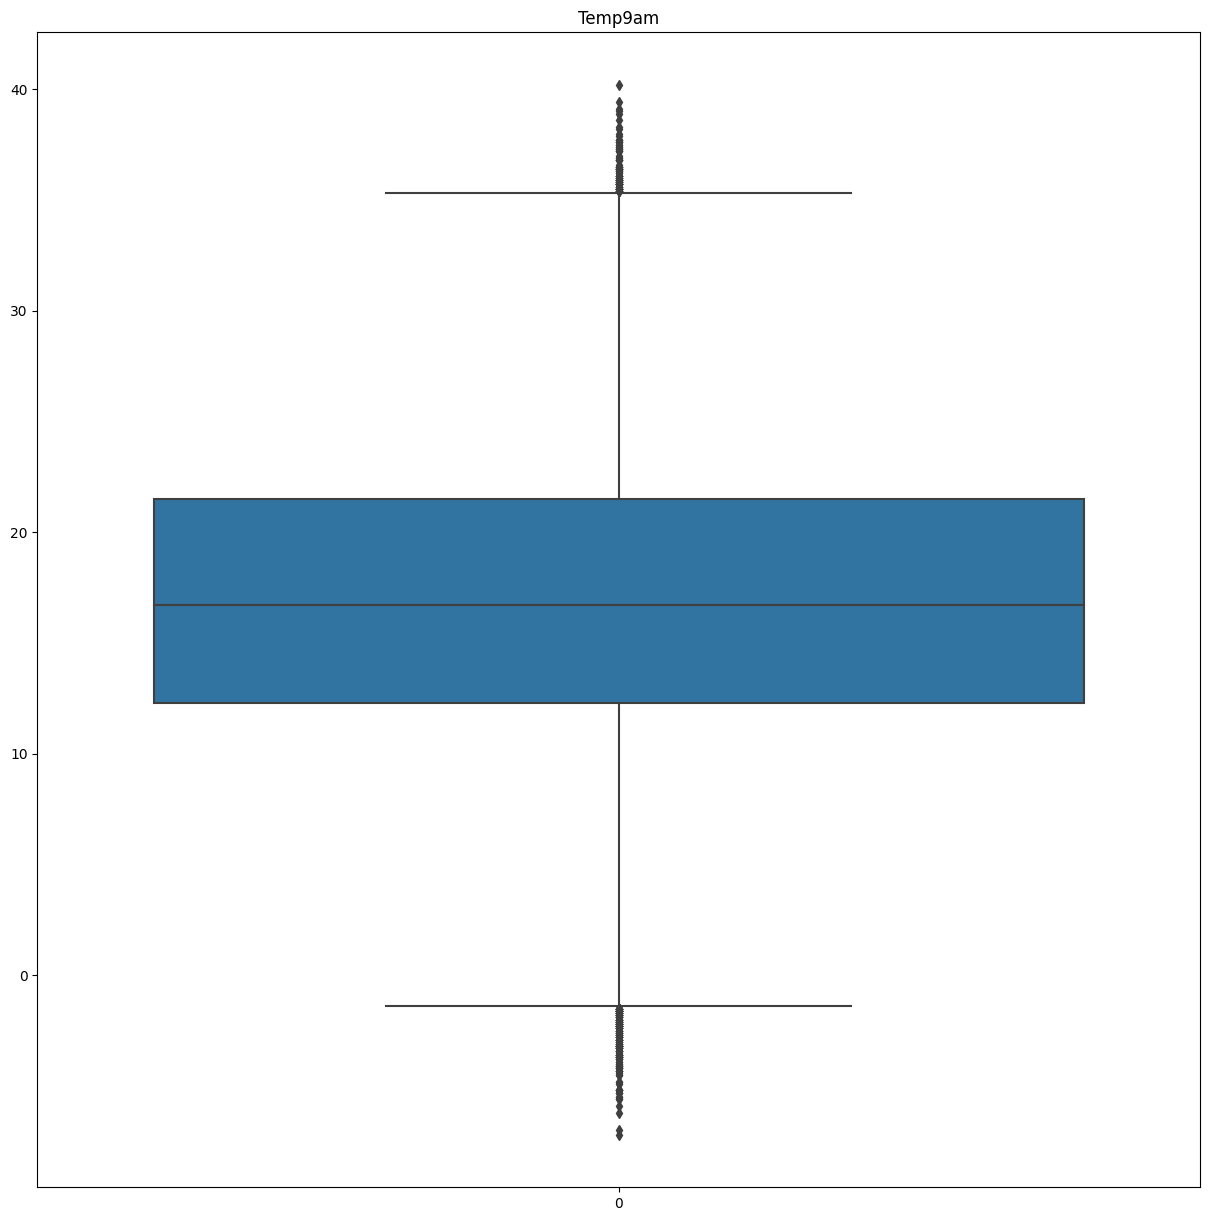

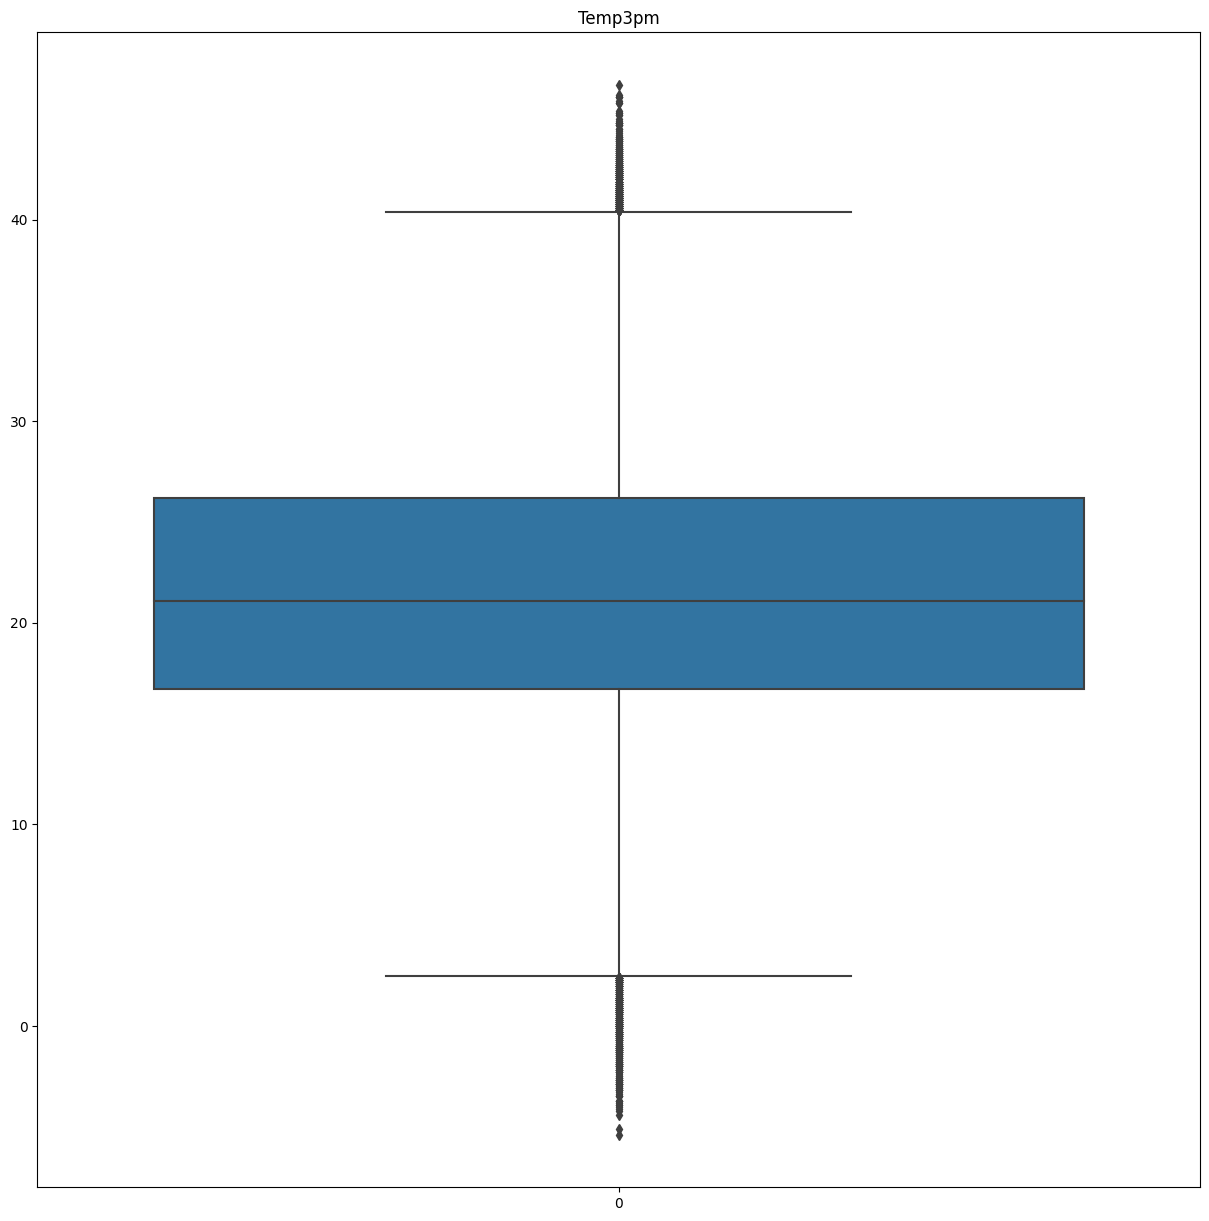

<Figure size 1500x1500 with 0 Axes>

In [33]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [34]:
for feature in continuous_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm


In [35]:
IQR=df.MinTemp.quantile(0.75)-df.MinTemp.quantile(0.25)
lower_bridge=df.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-5.950000000000002 30.450000000000003


In [36]:
df.loc[df['MinTemp']>=30.45,'MinTemp']=30.45
df.loc[df['MinTemp']<=-5.95,'MinTemp']=-5.95

In [37]:
IQR=df.MaxTemp.quantile(0.75)-df.MaxTemp.quantile(0.25)
lower_bridge=df.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.700000000000001 43.5


In [38]:
df.loc[df['MaxTemp']>=43.5,'MaxTemp']=43.5
df.loc[df['MaxTemp']<=2.7,'MaxTemp']=2.7

In [39]:
IQR=df.Rainfall.quantile(0.75)-df.Rainfall.quantile(0.25)
lower_bridge=df.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-0.8999999999999999 1.5


In [40]:
df.loc[df['Rainfall']>=1.5,'Rainfall']=1.5
df.loc[df['Rainfall']<=-0.89,'Rainfall']=-0.89

In [41]:
IQR=df.Evaporation.quantile(0.75)-df.Evaporation.quantile(0.25)
lower_bridge=df.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-4.600000000000001 14.600000000000001


In [42]:
df.loc[df['Evaporation']>=14.6,'Evaporation']=14.6
df.loc[df['Evaporation']<=-4.6,'Evaporation']=-4.6

In [43]:
IQR=df.WindGustSpeed.quantile(0.75)-df.WindGustSpeed.quantile(0.25)
lower_bridge=df.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

8.5 68.5


In [44]:
df.loc[df['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
df.loc[df['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [45]:
IQR=df.WindSpeed9am.quantile(0.75)-df.WindSpeed9am.quantile(0.25)
lower_bridge=df.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-11.0 37.0


In [46]:
df.loc[df['WindSpeed9am']>=37,'WindSpeed9am']=37
df.loc[df['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [47]:
IQR=df.WindSpeed3pm.quantile(0.75)-df.WindSpeed3pm.quantile(0.25)
lower_bridge=df.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-3.5 40.5


In [48]:
df.loc[df['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
df.loc[df['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [49]:
IQR=df.Humidity9am.quantile(0.75)-df.Humidity9am.quantile(0.25)
lower_bridge=df.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

18.0 122.0


In [50]:
df.loc[df['Humidity9am']>=122,'Humidity9am']=122
df.loc[df['Humidity9am']<=18,'Humidity9am']=18

In [51]:
IQR=df.Pressure9am.quantile(0.75)-df.Pressure9am.quantile(0.25)
lower_bridge=df.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1001.0500000000001 1034.25


In [52]:
df.loc[df['Pressure9am']>=1034.25,'Pressure9am']=1034.25
df.loc[df['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [53]:
IQR=df.Pressure3pm.quantile(0.75)-df.Pressure3pm.quantile(0.25)
lower_bridge=df.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

998.6500000000001 1031.85


In [54]:
df.loc[df['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
df.loc[df['Pressure3pm']<=998.65,'Pressure3pm']=998.65

In [55]:
IQR=df.Temp9am.quantile(0.75)-df.Temp9am.quantile(0.25)
lower_bridge=df.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.4999999999999982 35.3


In [56]:
df.loc[df['Temp9am']>=35.3,'Temp9am']=35.3
df.loc[df['Temp9am']<=-1.49,'Temp9am']=-1.49

In [57]:
IQR=df.Temp3pm.quantile(0.75)-df.Temp3pm.quantile(0.25)
lower_bridge=df.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.4499999999999993 40.45


In [58]:
df.loc[df['Temp3pm']>=40.45,'Temp3pm']=40.45
df.loc[df['Temp3pm']<=2.45,'Temp3pm']=2.45

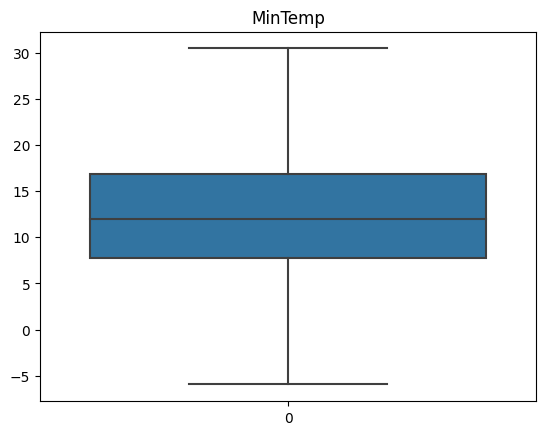

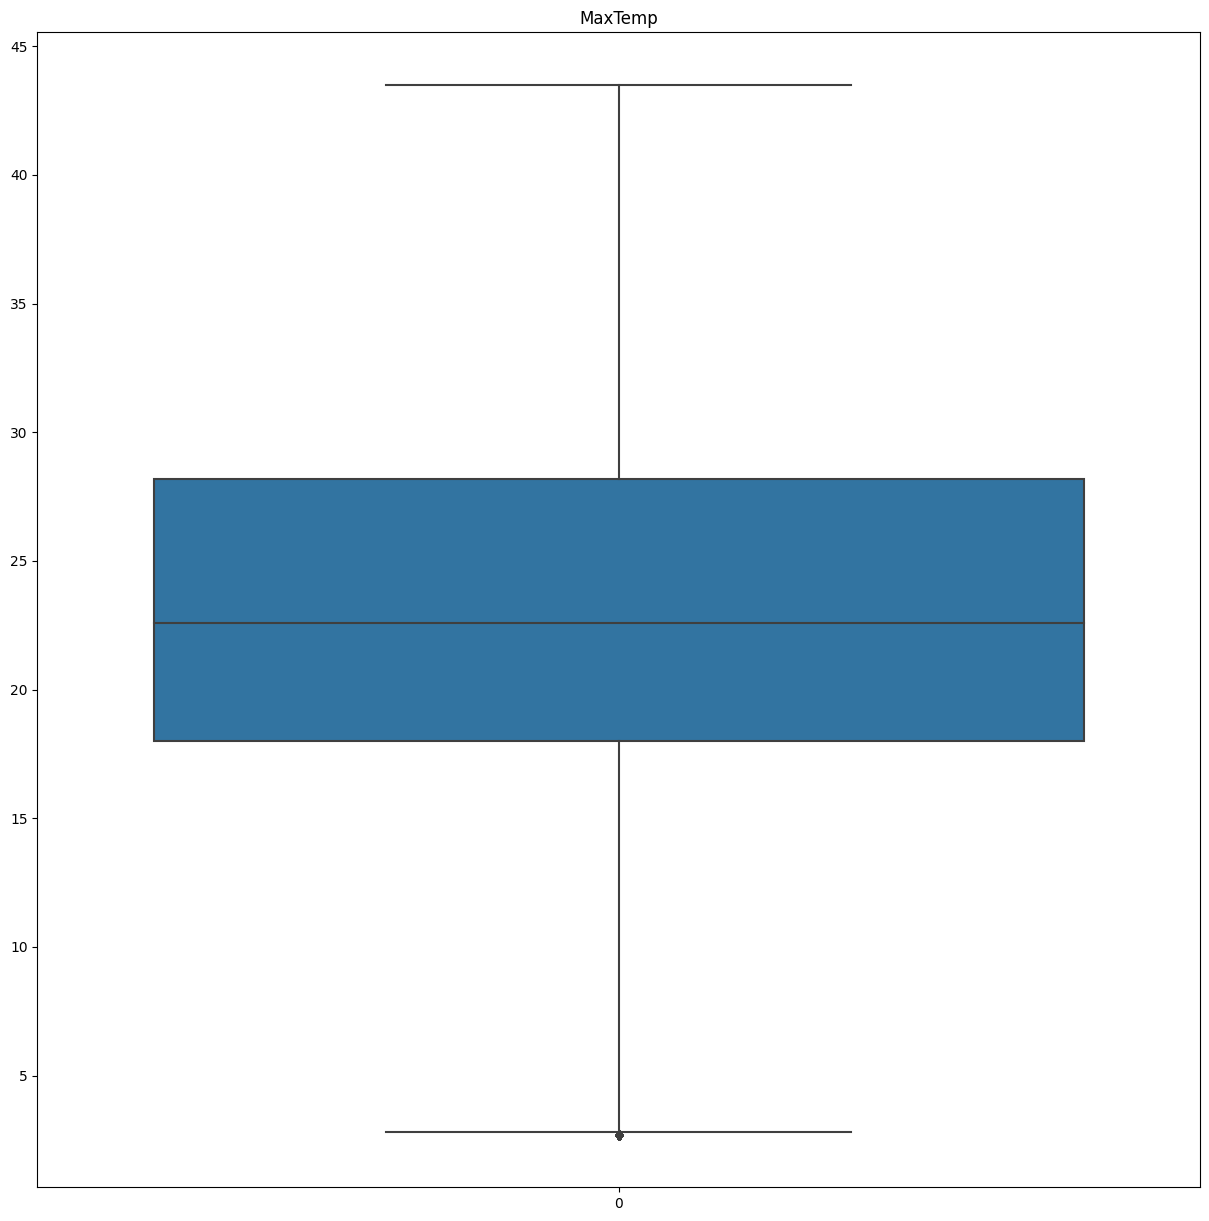

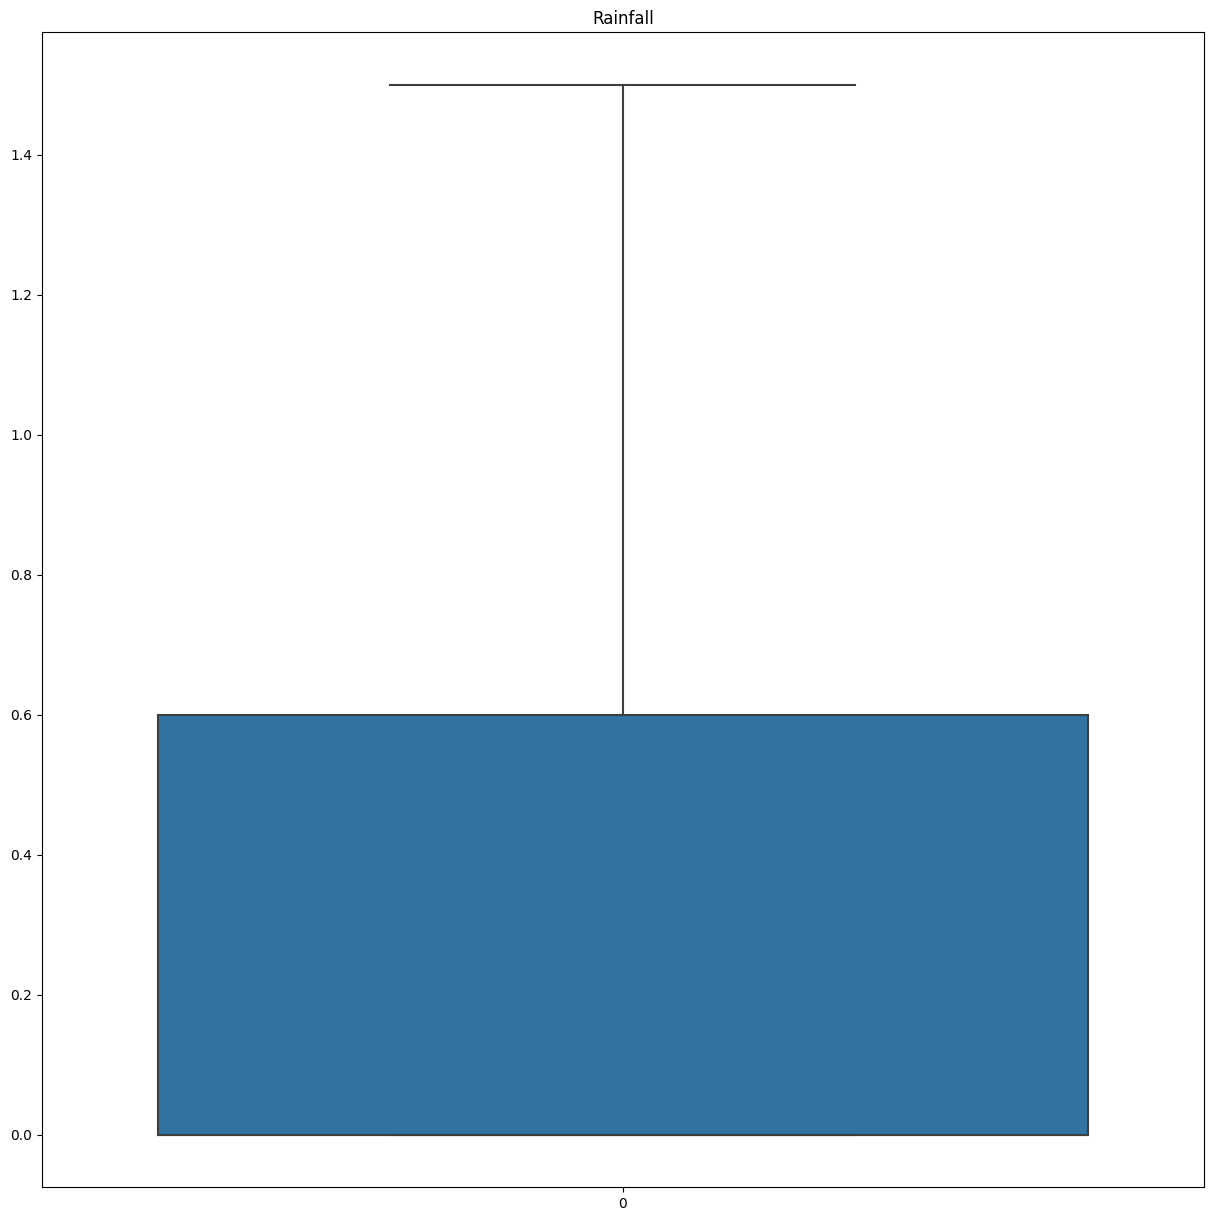

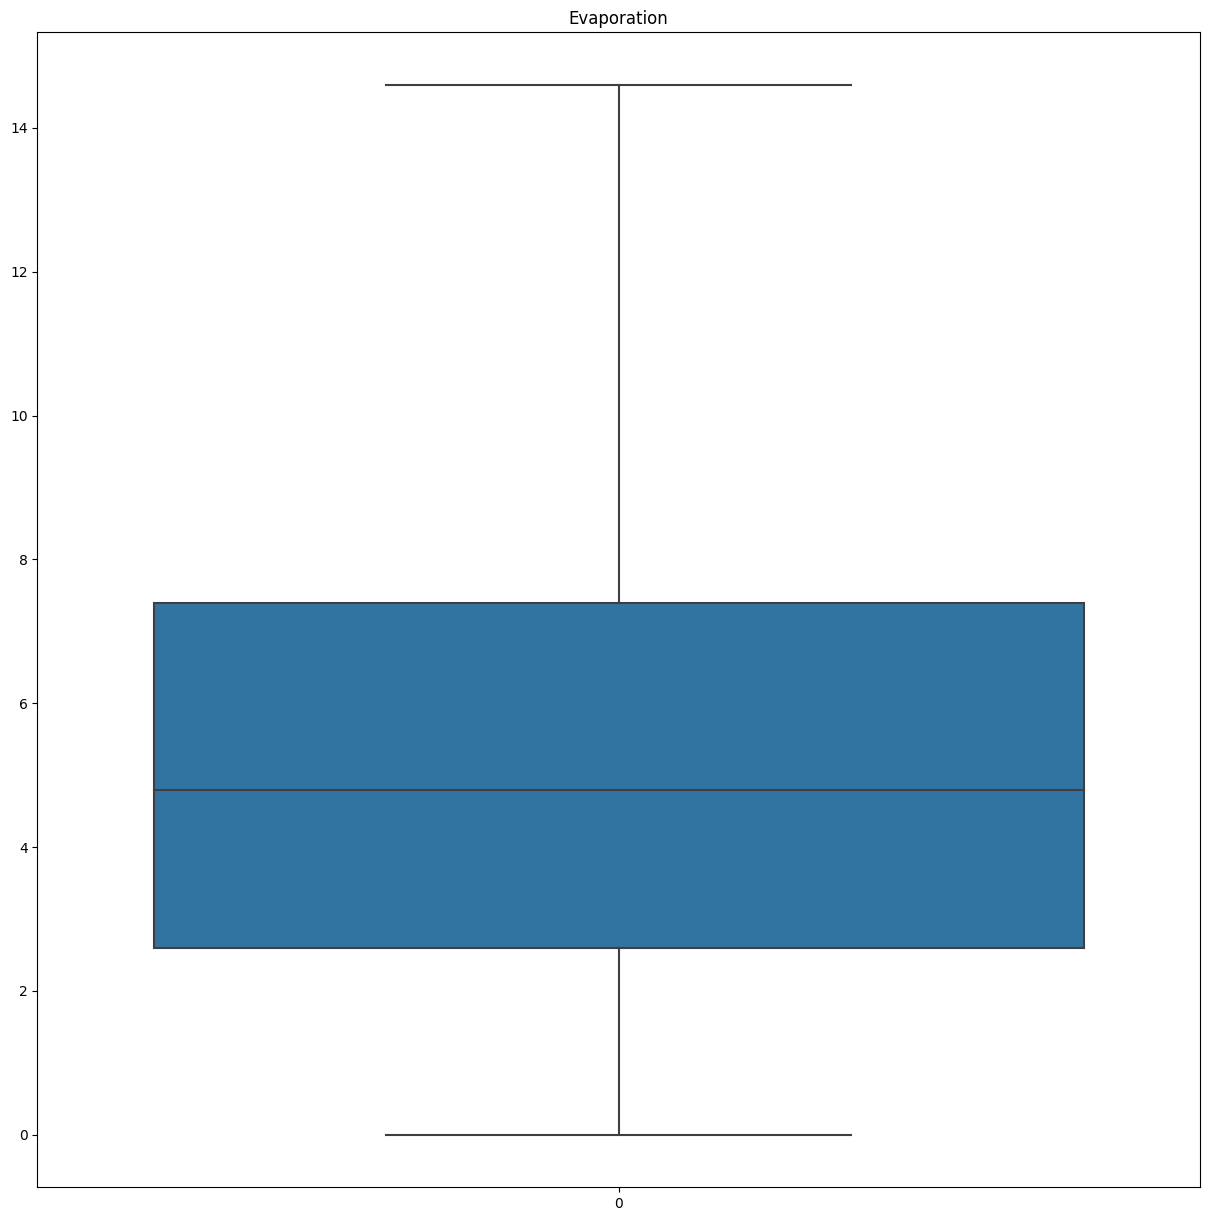

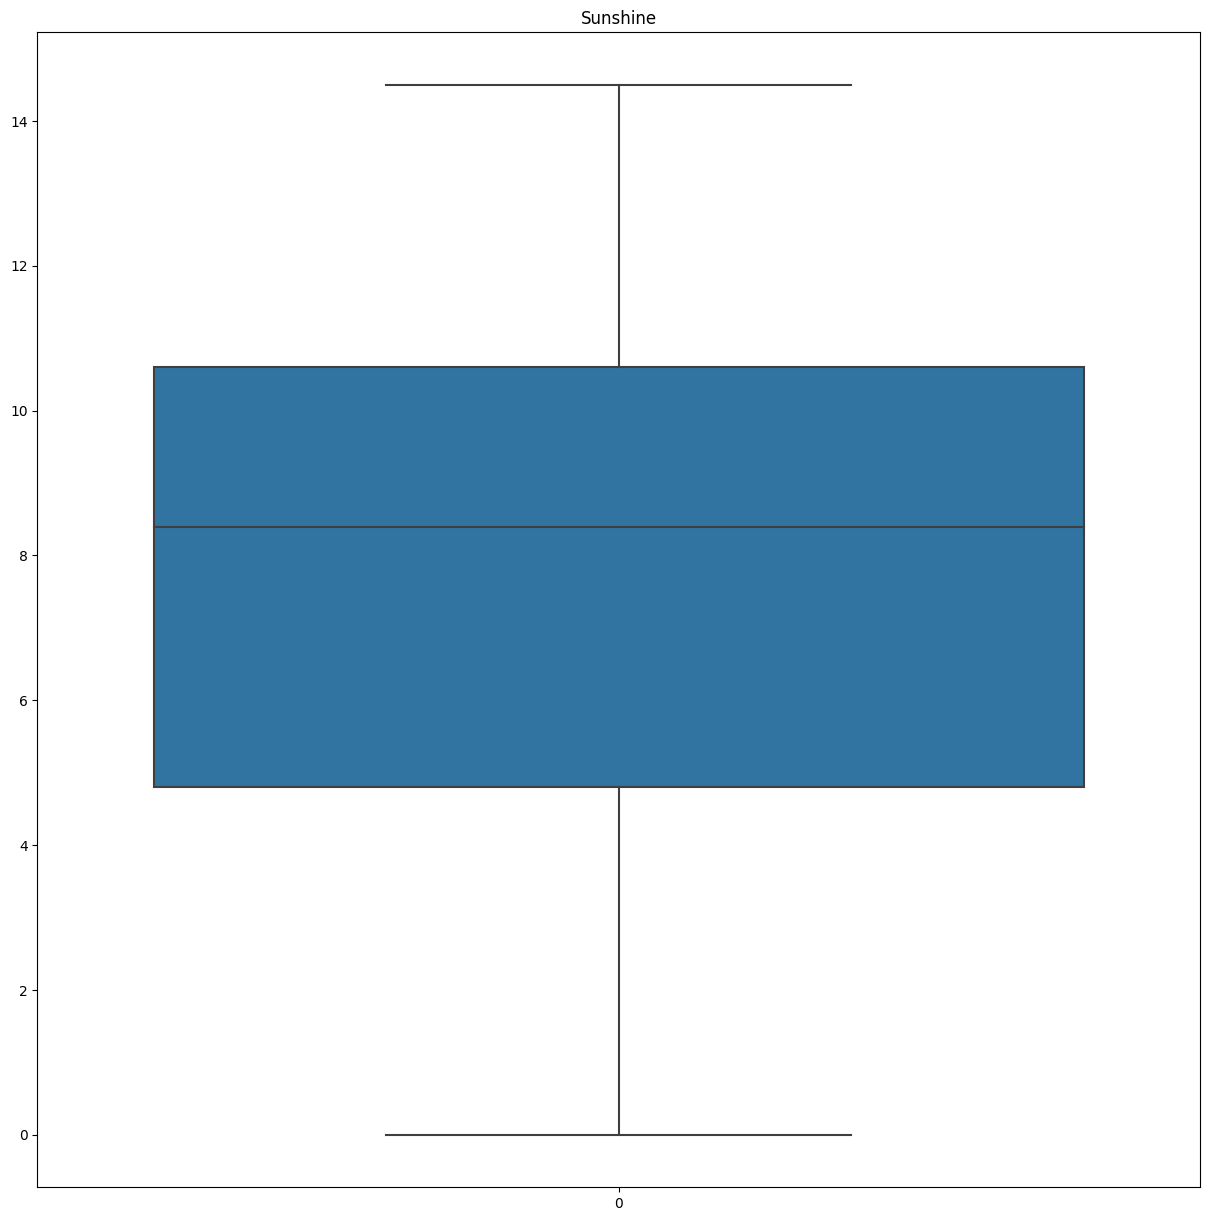

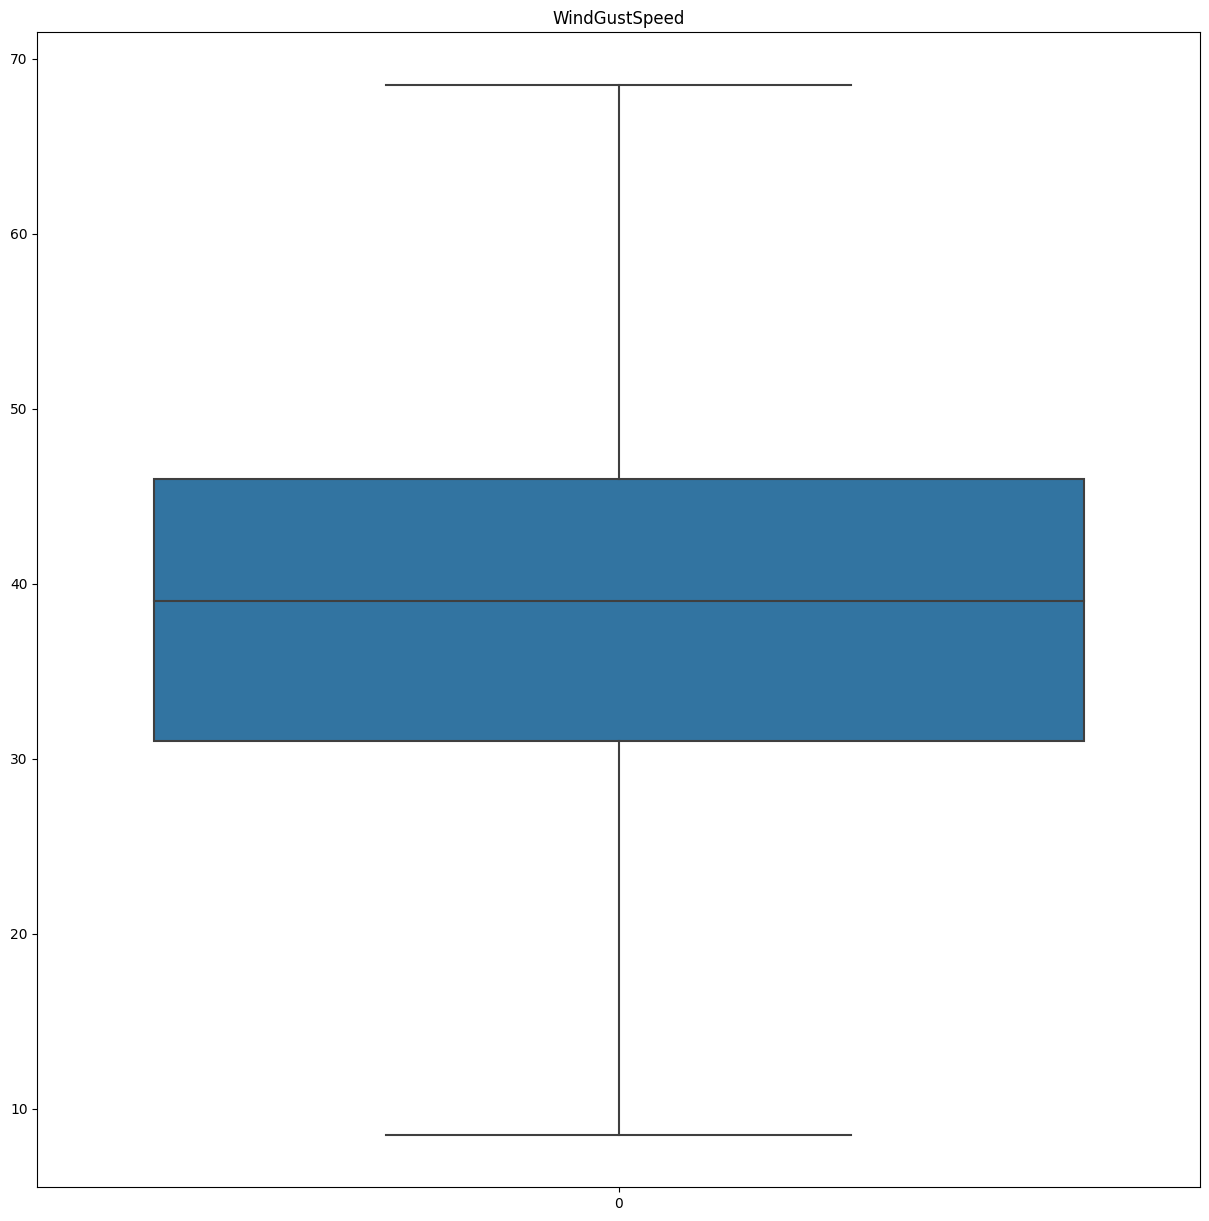

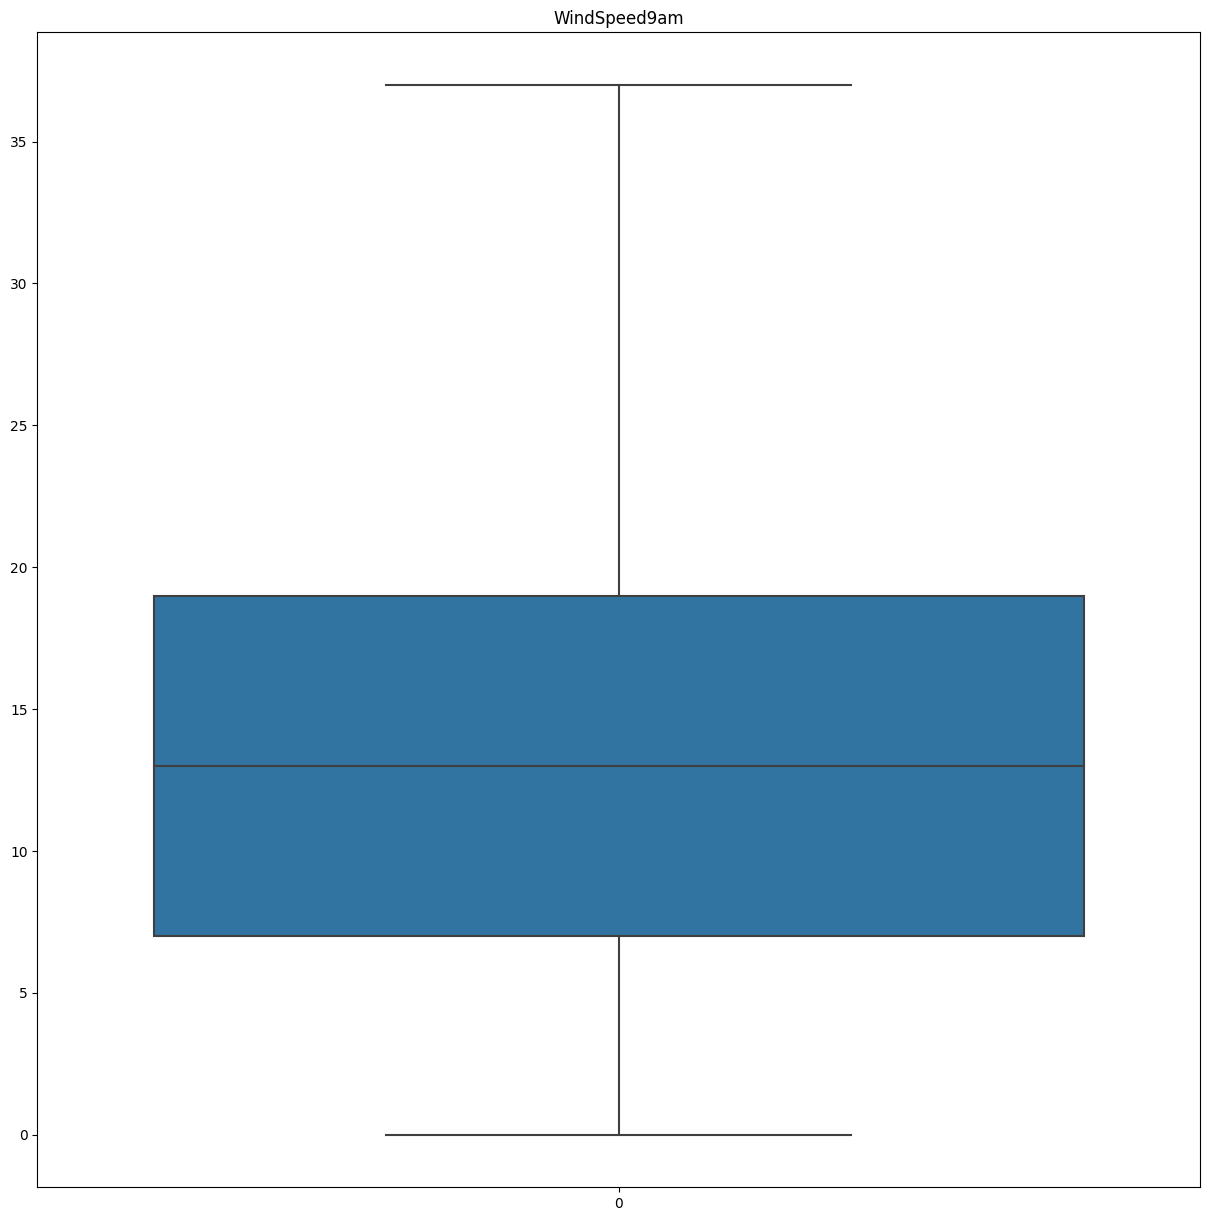

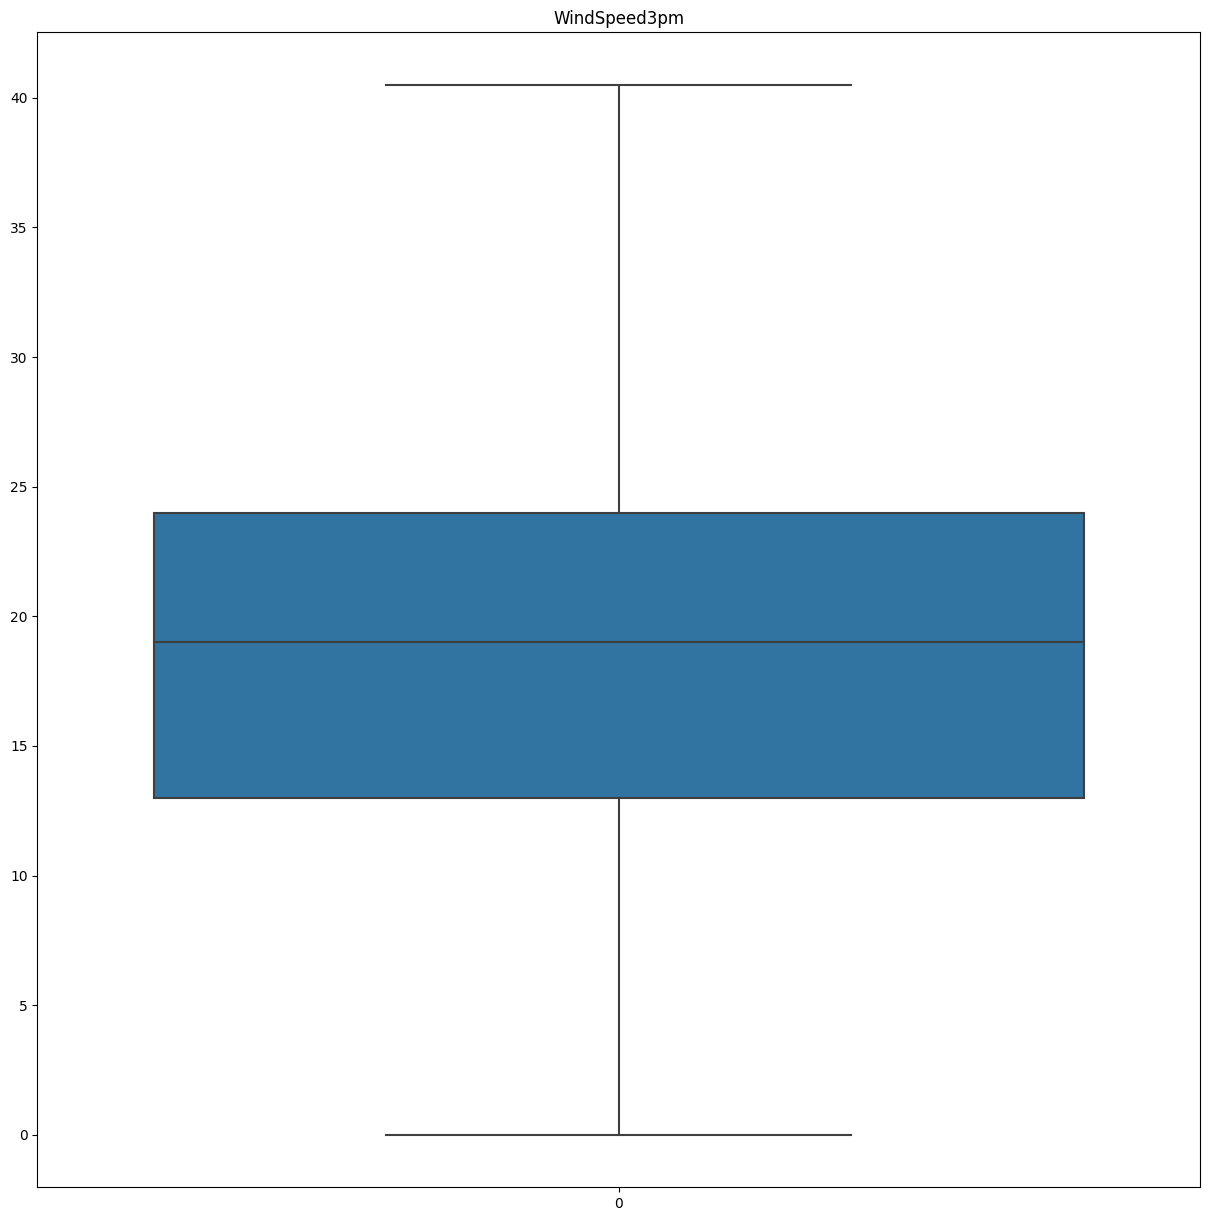

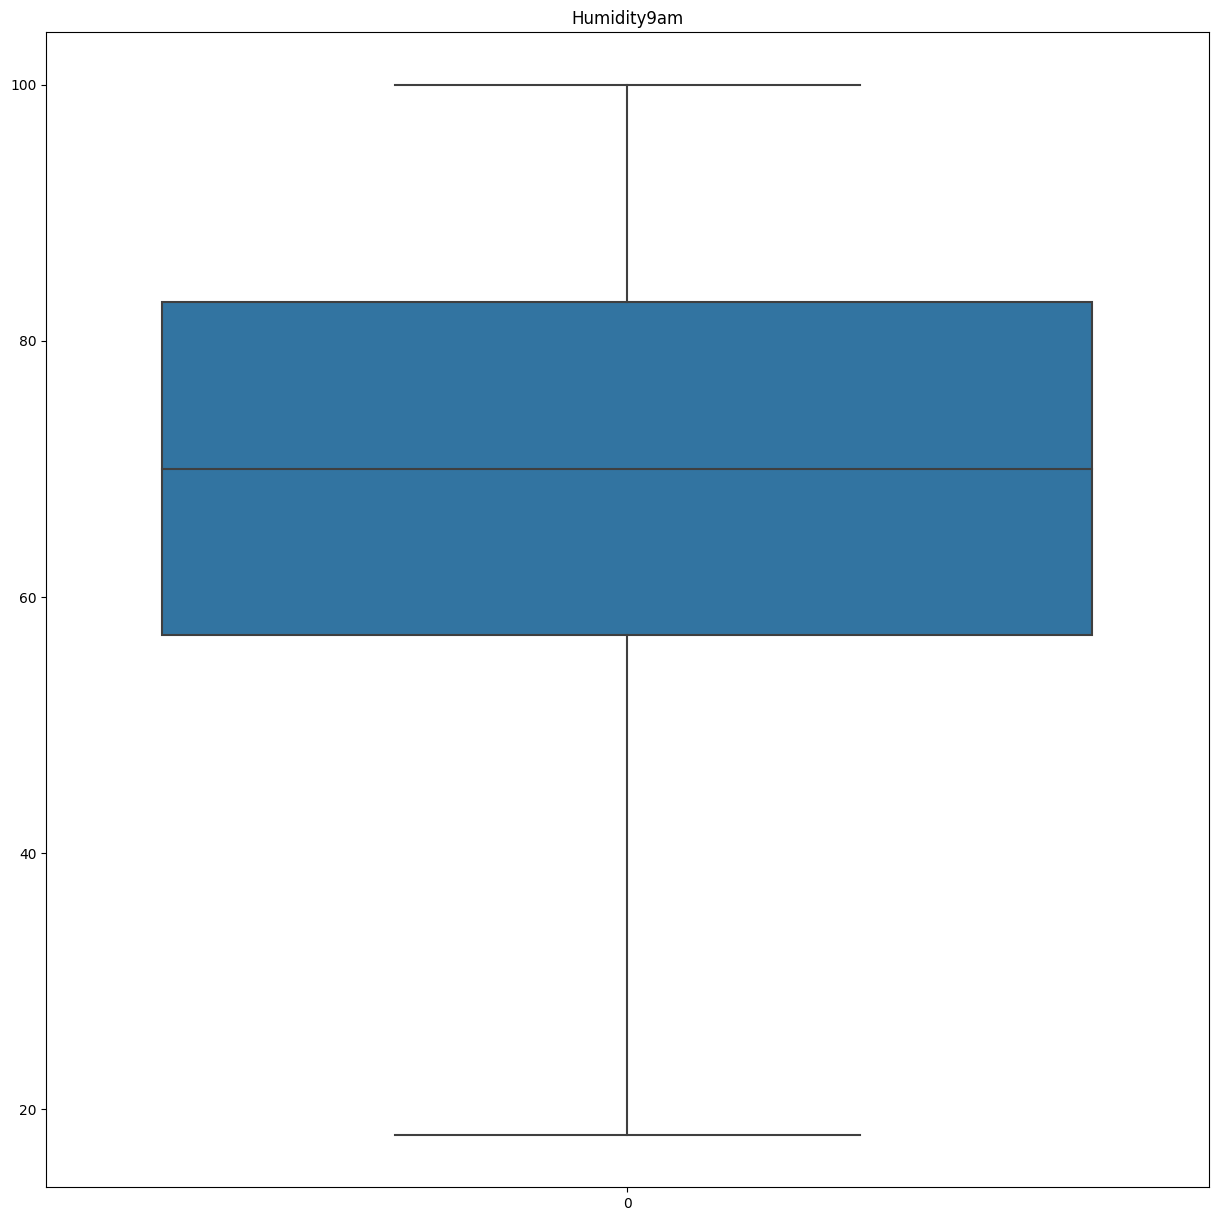

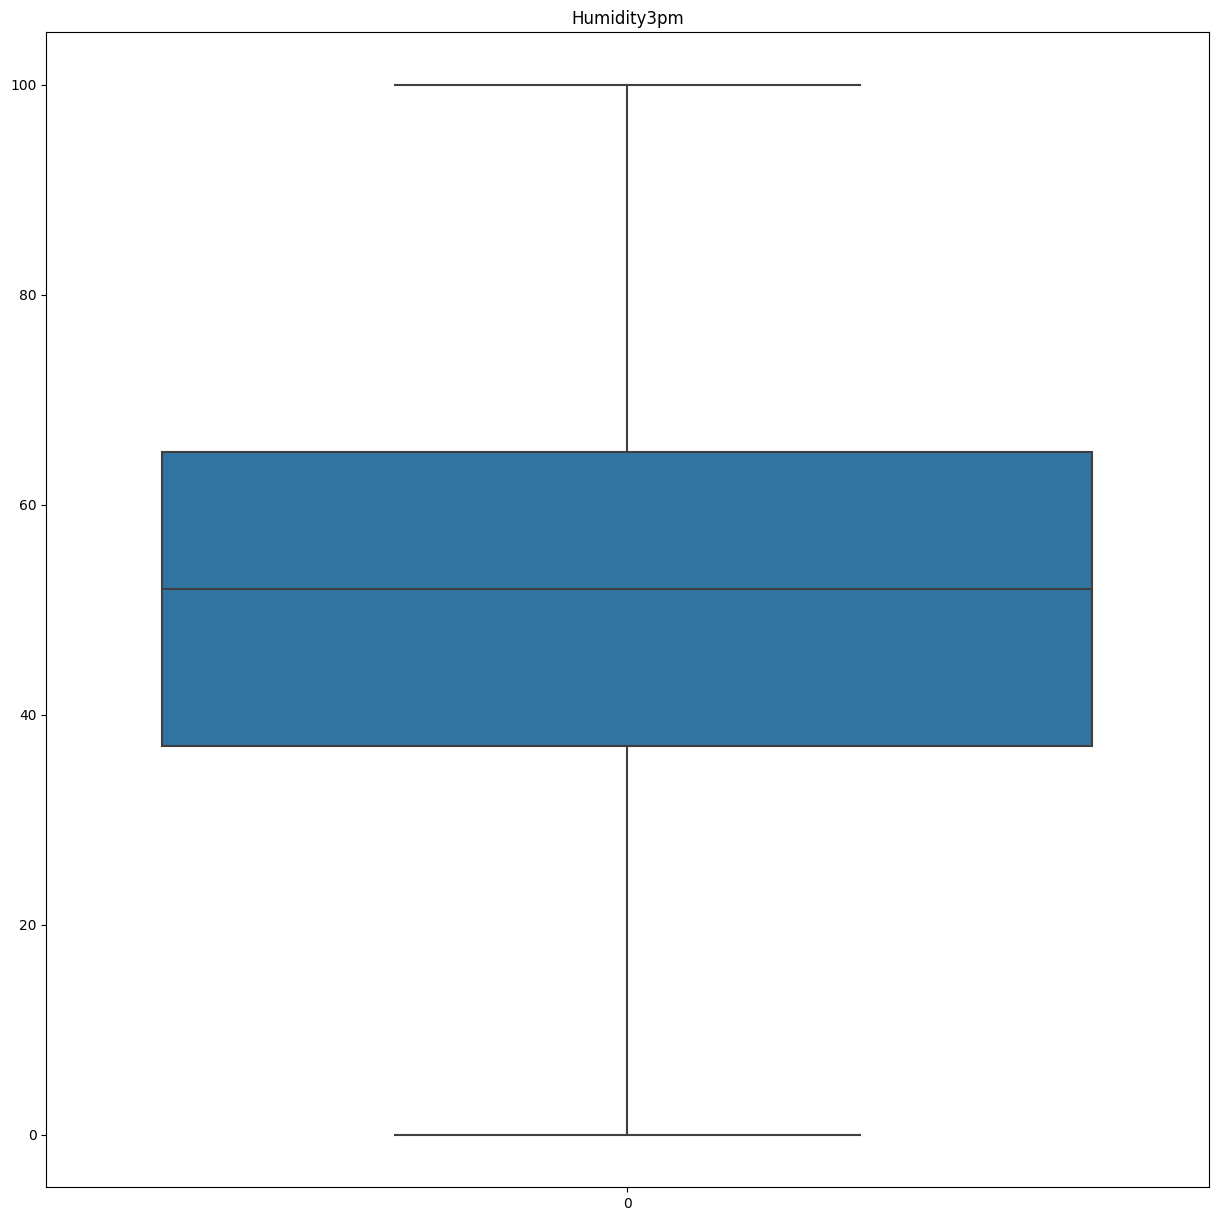

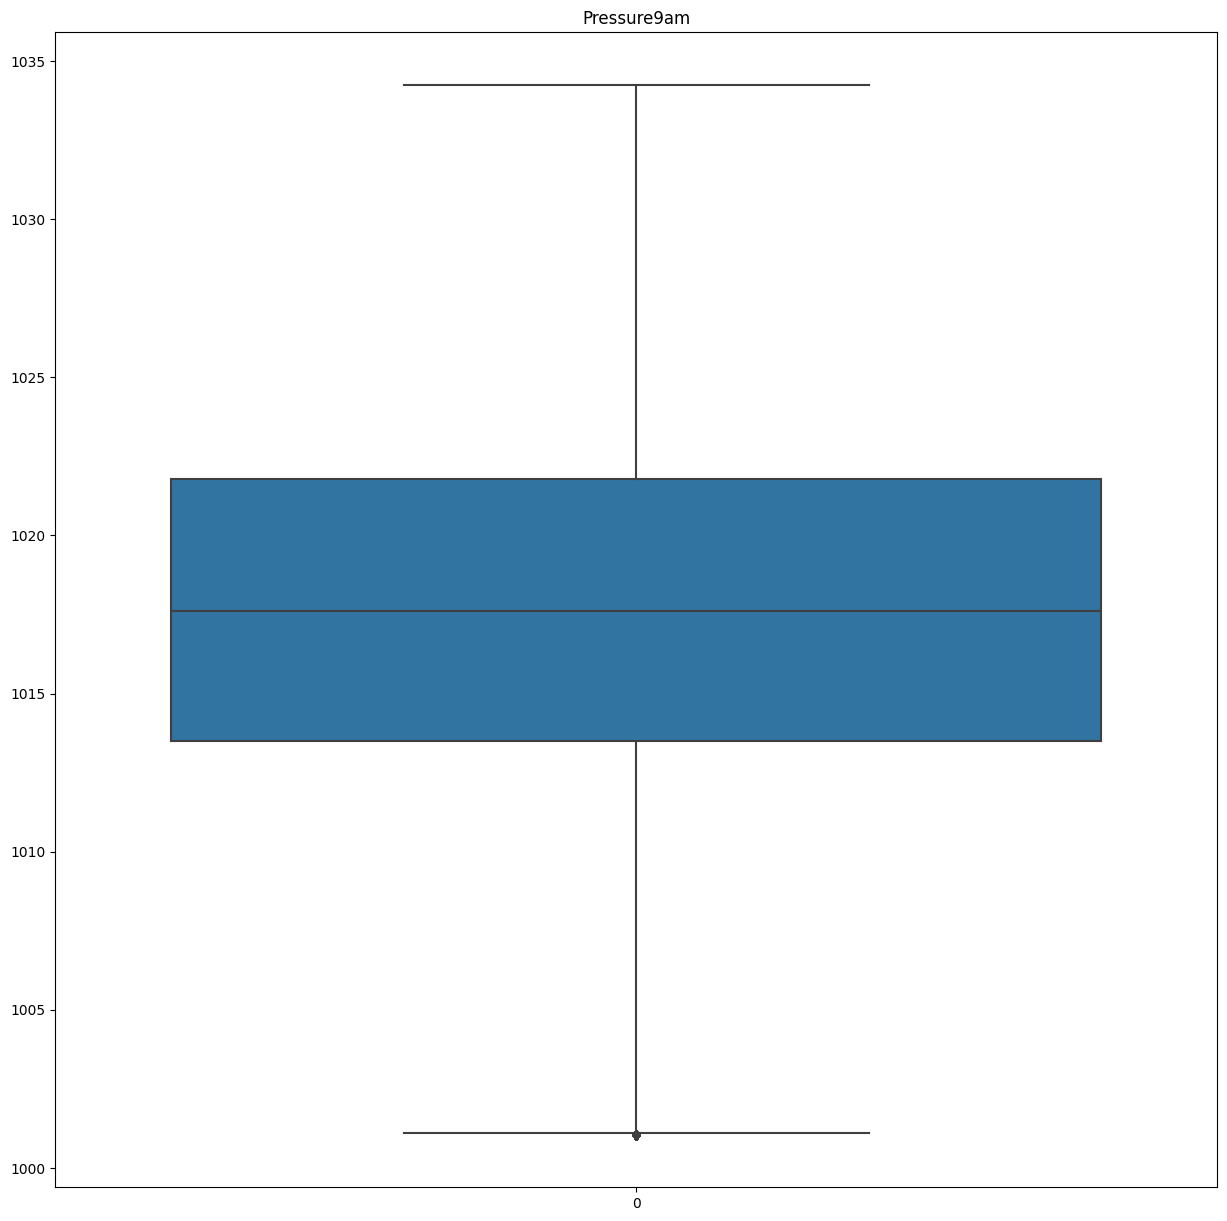

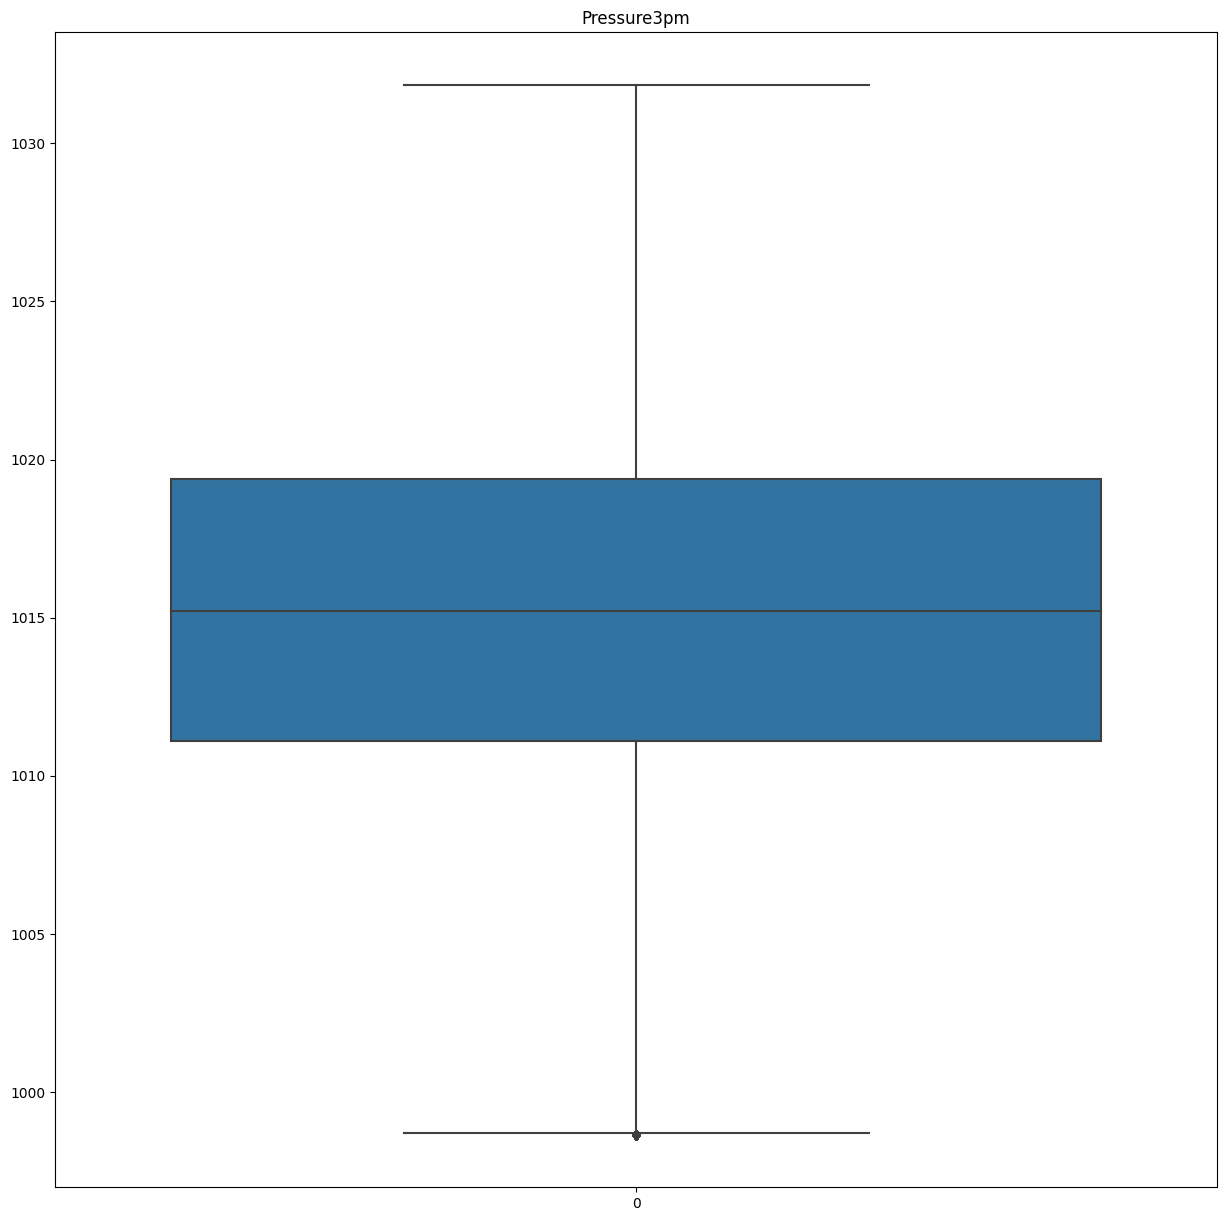

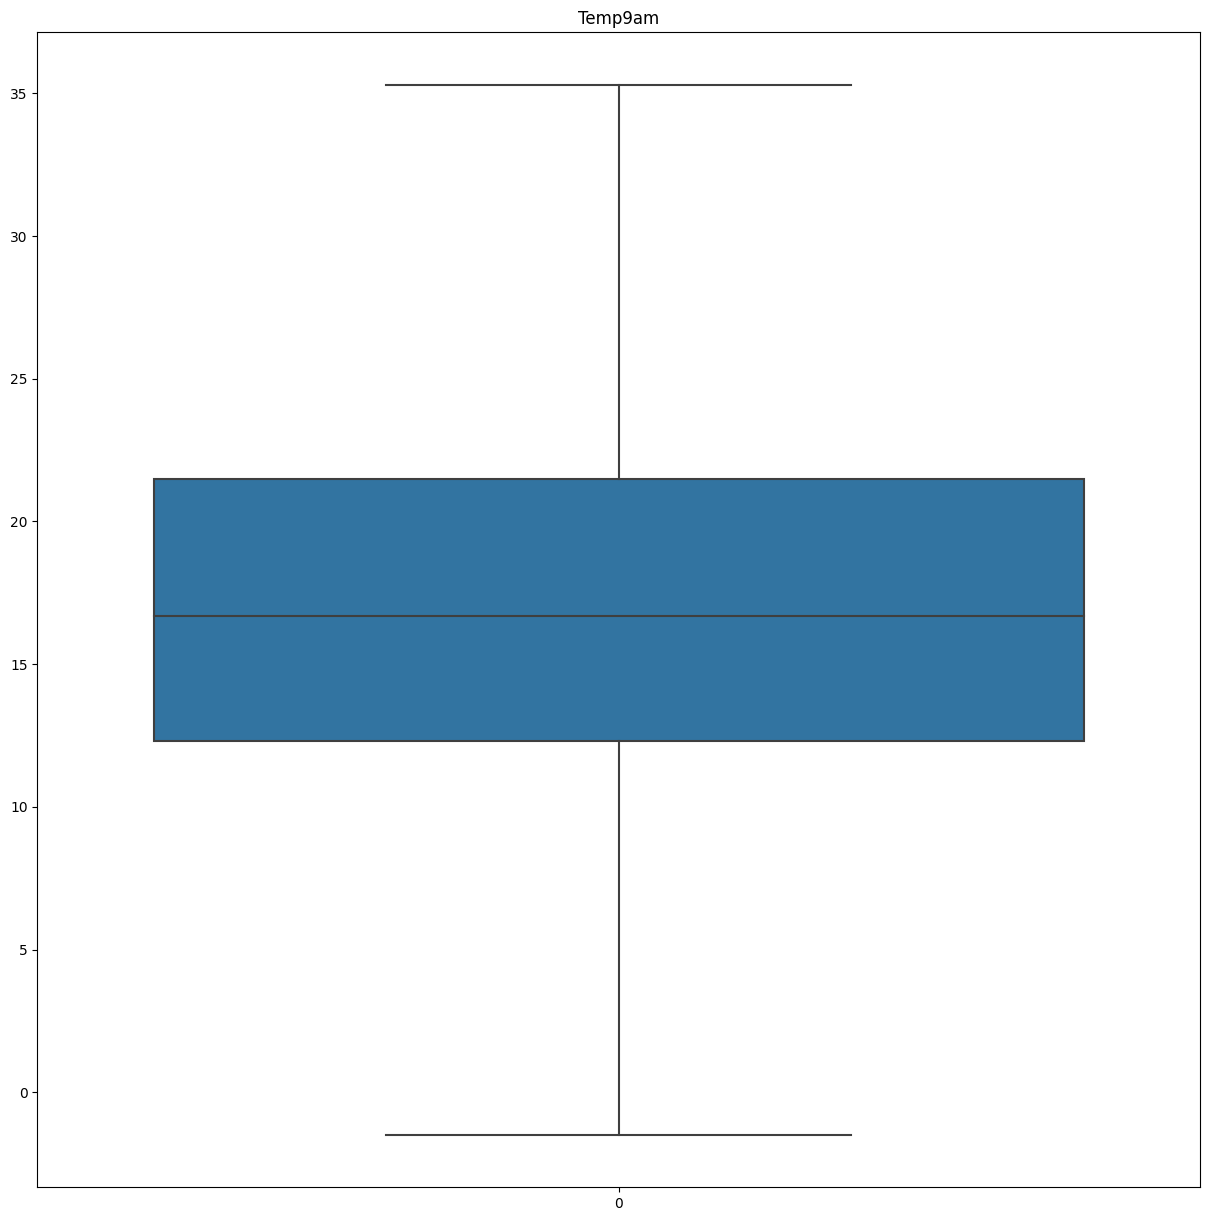

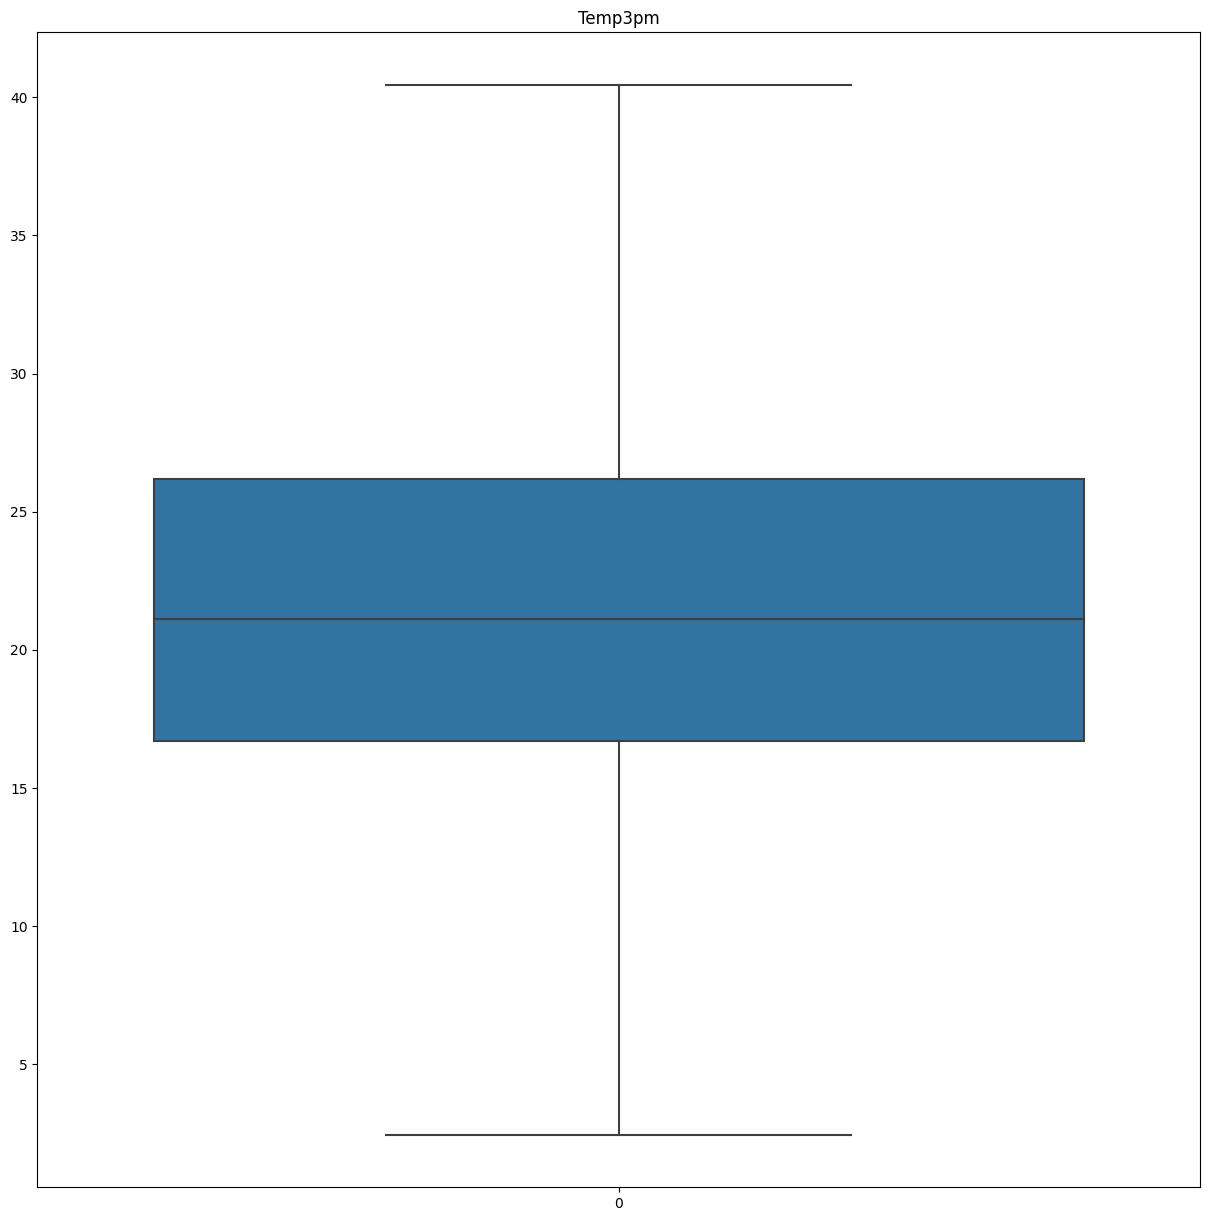

<Figure size 1500x1500 with 0 Axes>

In [59]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

MinTemp


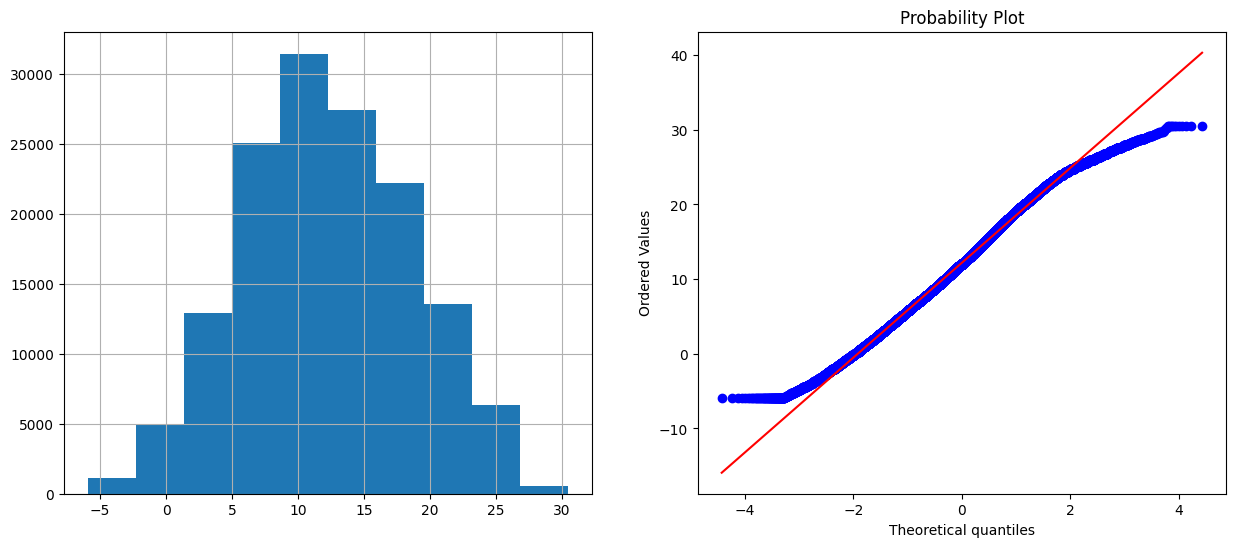

MaxTemp


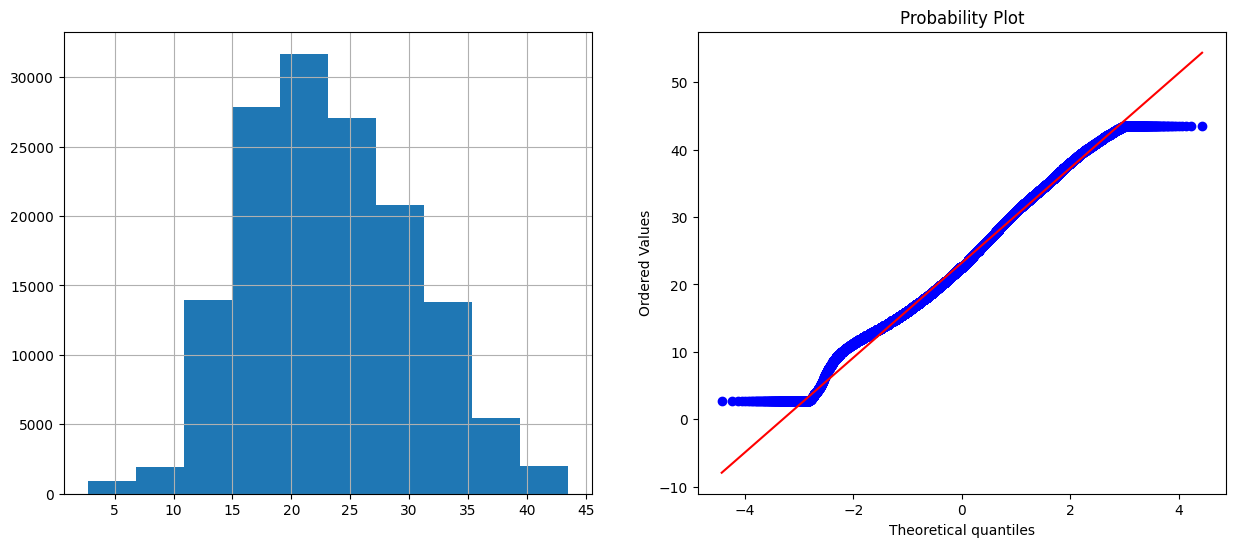

Rainfall


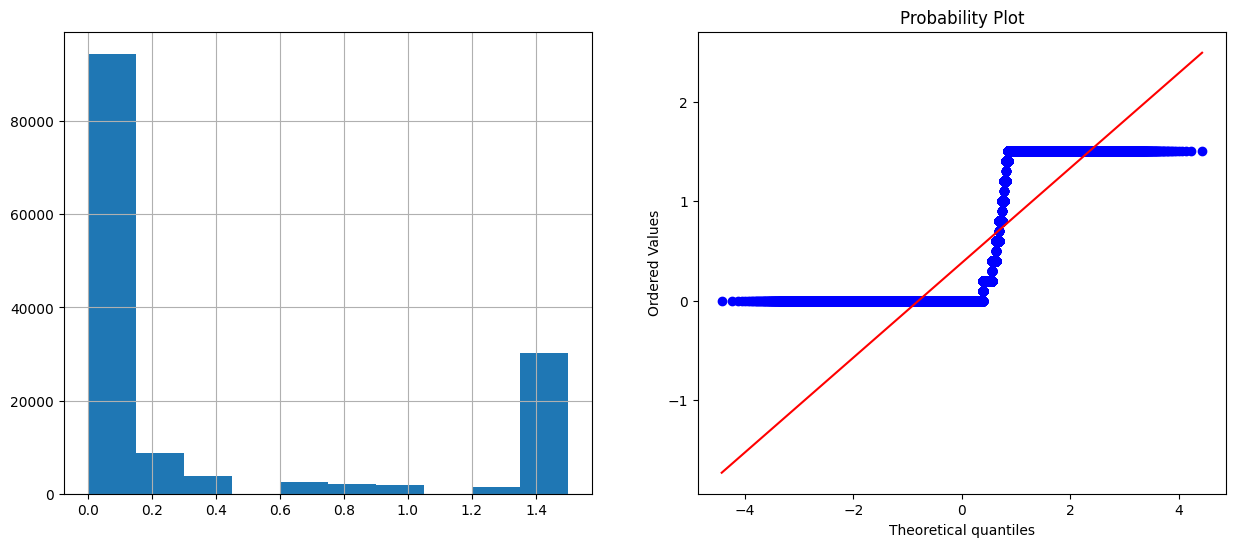

Evaporation


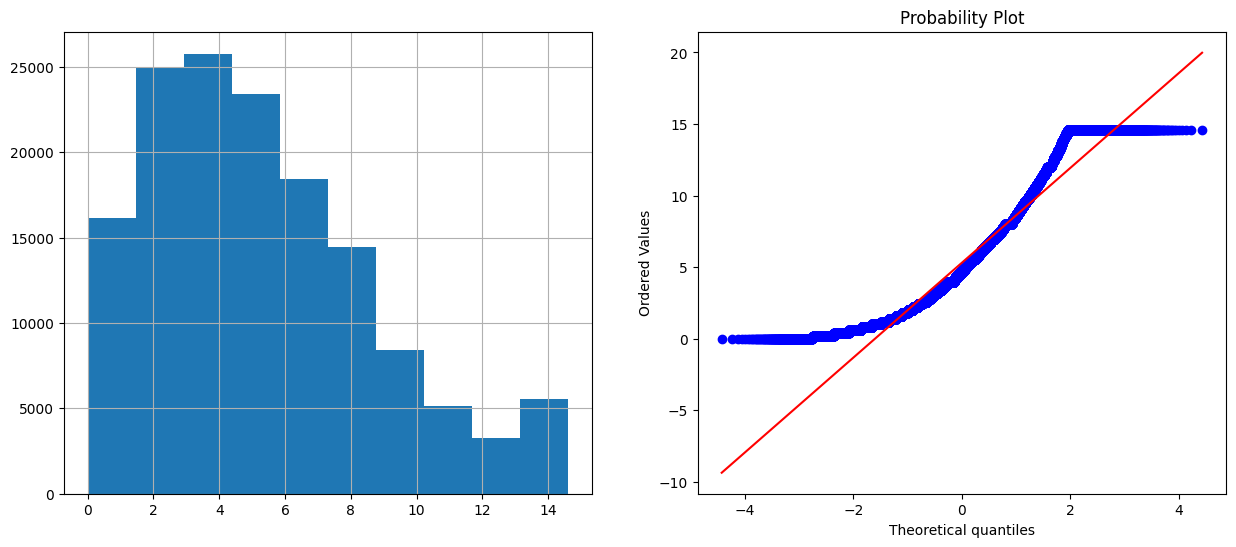

Sunshine


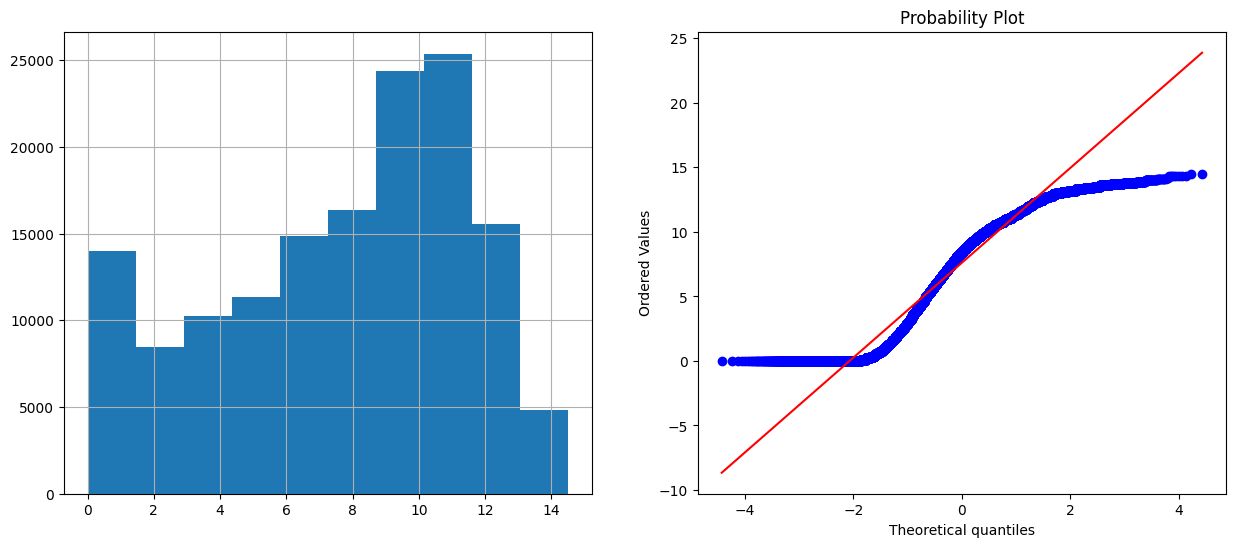

WindGustSpeed


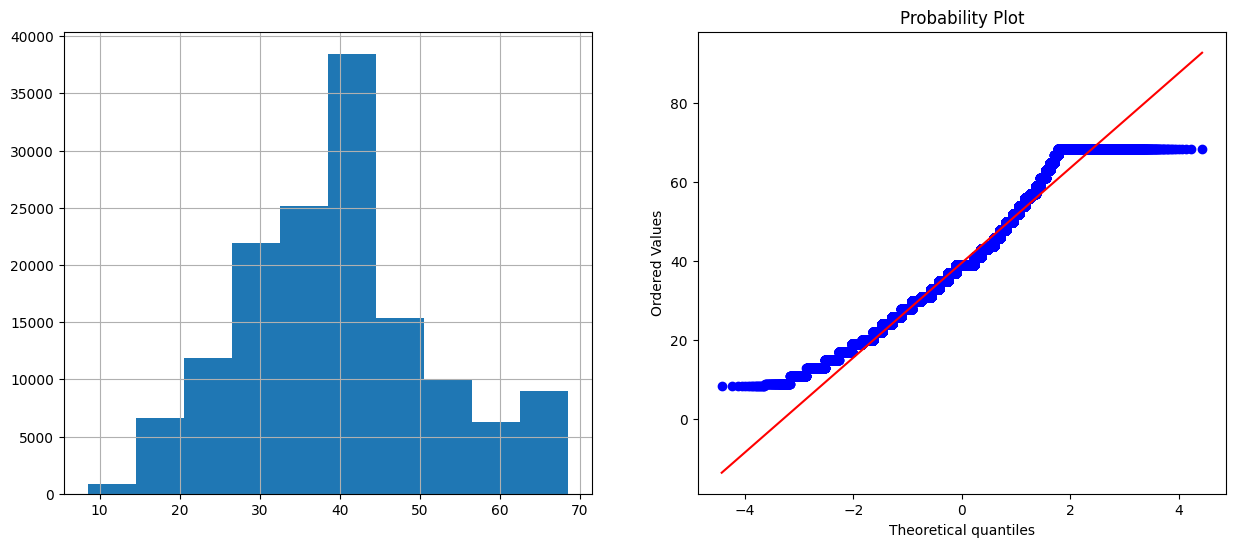

WindSpeed9am


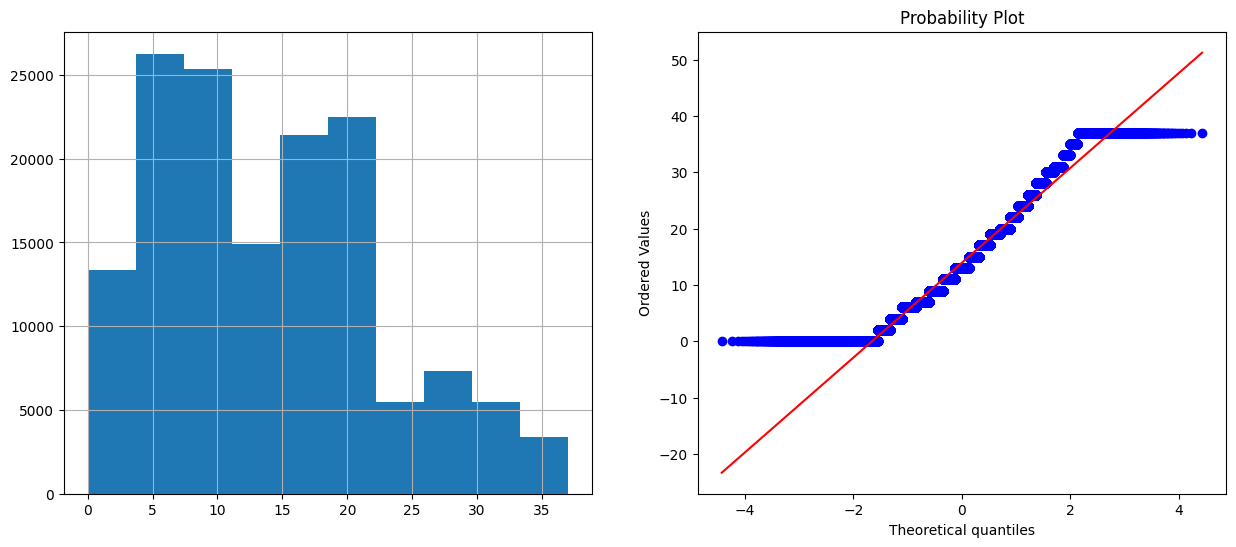

WindSpeed3pm


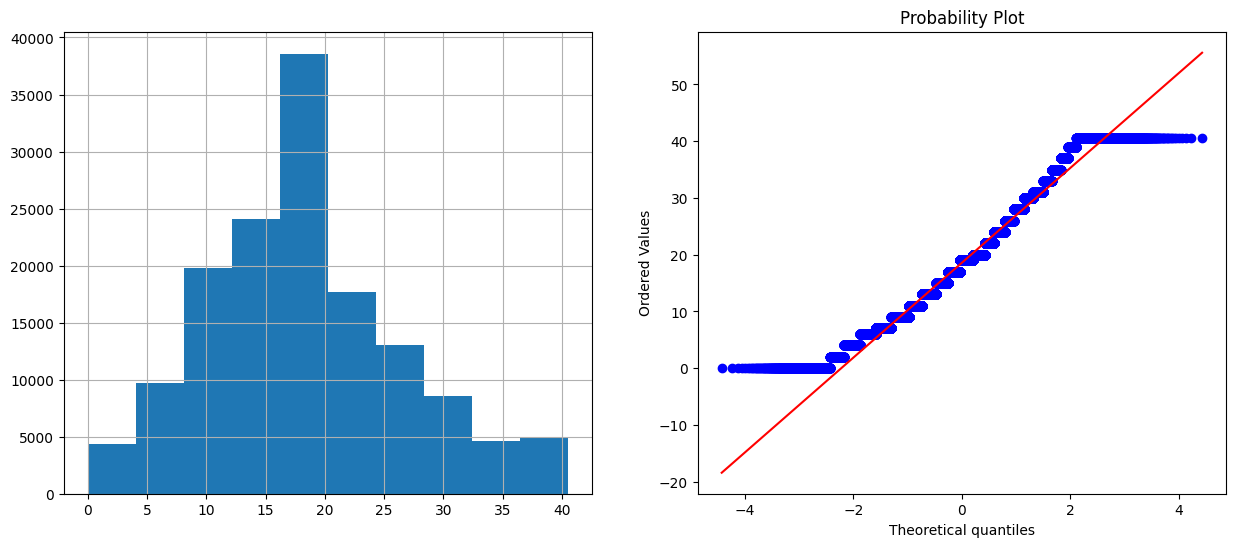

Humidity9am


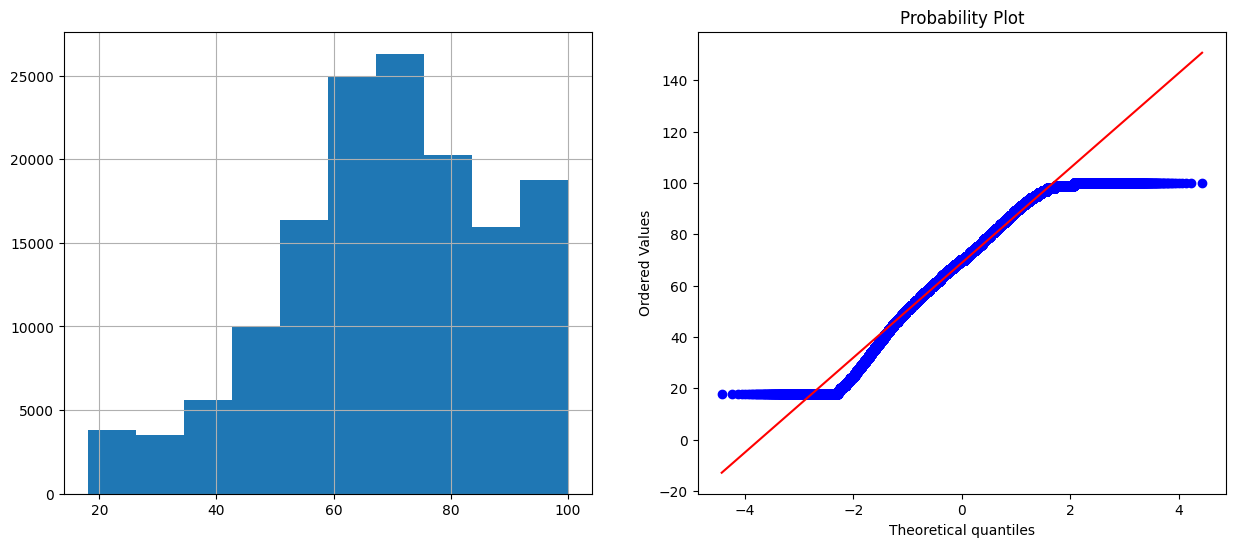

Humidity3pm


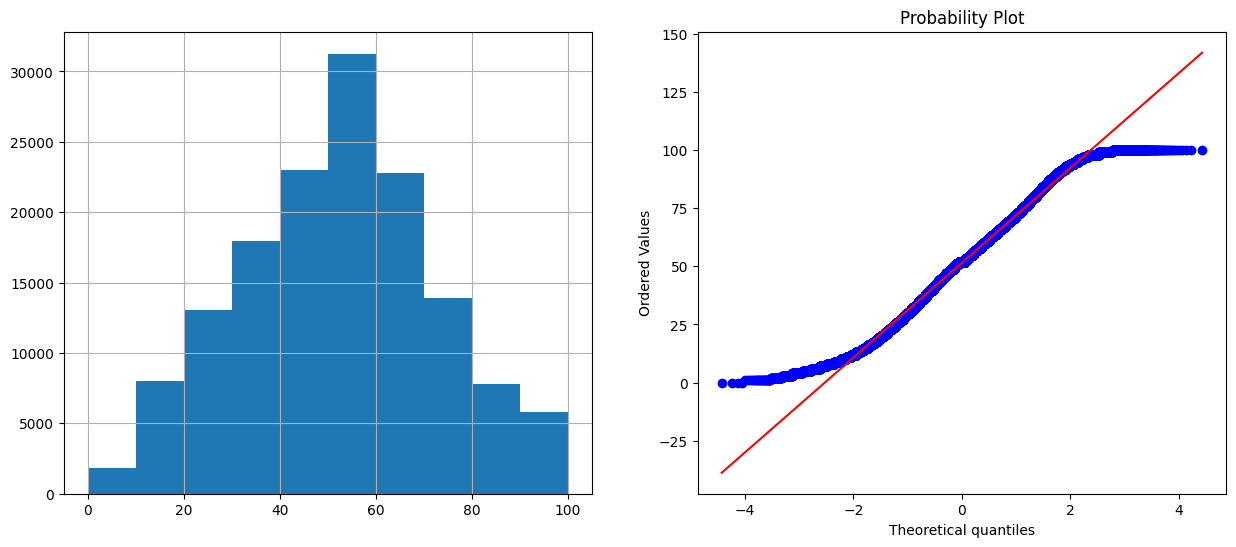

Pressure9am


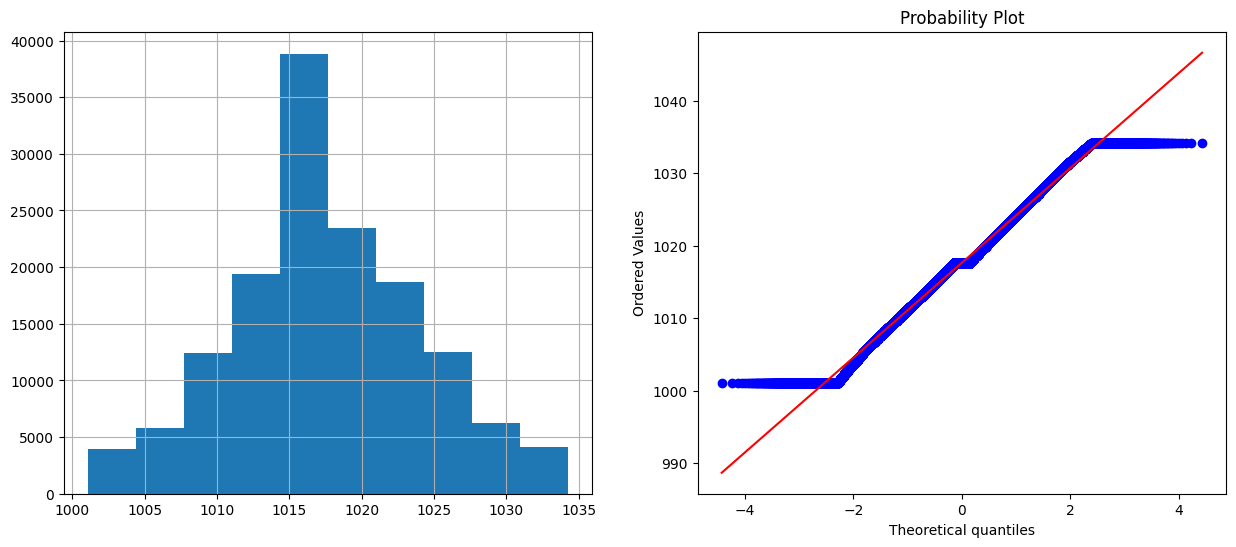

Pressure3pm


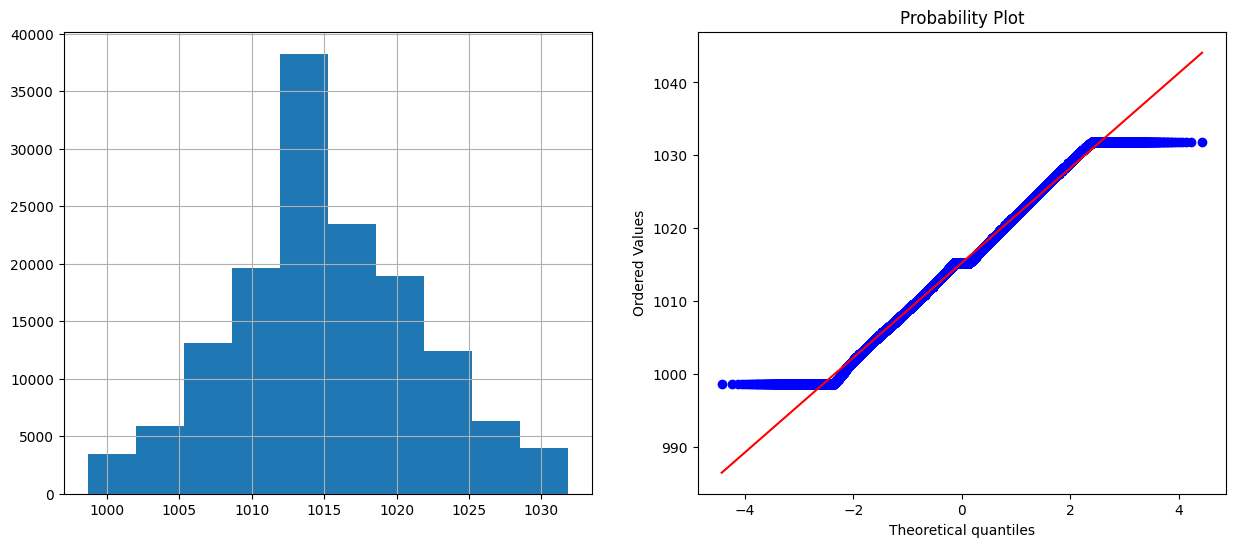

Temp9am


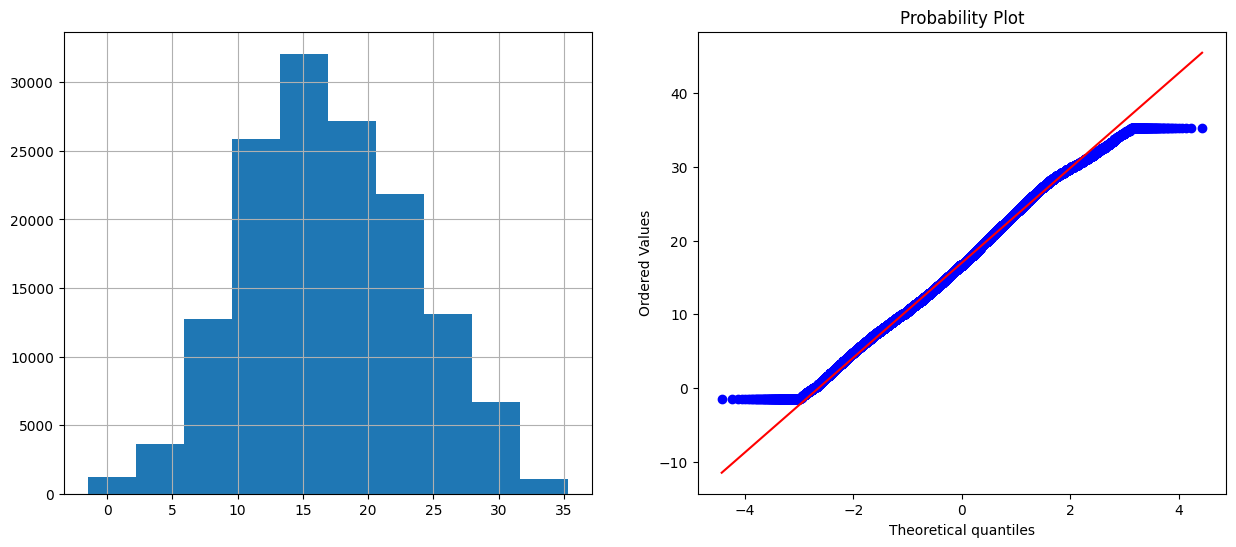

Temp3pm


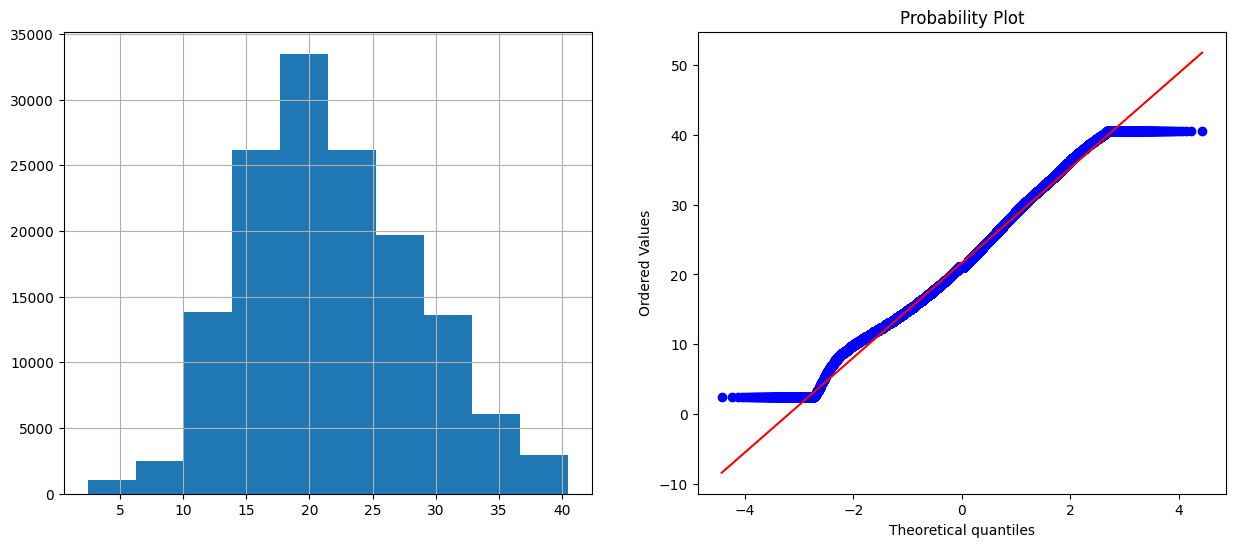

In [61]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.show()

In [62]:
df.to_csv("preprocessed_1.csv", index=False)

In [63]:
X = df.drop(["RainTomorrow", "Date"], axis=1)
Y = df["RainTomorrow"]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, random_state = 0)

In [66]:
y_train

43447     0
140904    0
54615     0
109793    0
74462     0
         ..
106567    0
52791     1
56339     0
82299     1
115175    0
Name: RainTomorrow, Length: 116368, dtype: uint8

In [68]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")#Area Under the Receiver Operating Characteristic Curve (ROC AUC) metric.
cat.fit(X_train_res, y_train_res)

Learning rate set to 0.050311


C:\Users\Sammitha S Poojary\AppData\Roaming\Python\Python310\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 179ms	remaining: 5m 58s
1:	total: 209ms	remaining: 3m 28s
2:	total: 242ms	remaining: 2m 41s
3:	total: 276ms	remaining: 2m 17s
4:	total: 311ms	remaining: 2m 4s
5:	total: 344ms	remaining: 1m 54s
6:	total: 379ms	remaining: 1m 47s
7:	total: 414ms	remaining: 1m 43s
8:	total: 450ms	remaining: 1m 39s
9:	total: 482ms	remaining: 1m 35s
10:	total: 518ms	remaining: 1m 33s
11:	total: 548ms	remaining: 1m 30s
12:	total: 578ms	remaining: 1m 28s
13:	total: 606ms	remaining: 1m 25s
14:	total: 640ms	remaining: 1m 24s
15:	total: 669ms	remaining: 1m 22s
16:	total: 697ms	remaining: 1m 21s
17:	total: 725ms	remaining: 1m 19s
18:	total: 755ms	remaining: 1m 18s
19:	total: 790ms	remaining: 1m 18s
20:	total: 826ms	remaining: 1m 17s
21:	total: 858ms	remaining: 1m 17s
22:	total: 893ms	remaining: 1m 16s
23:	total: 926ms	remaining: 1m 16s
24:	total: 964ms	remaining: 1m 16s
25:	total: 997ms	remaining: 1m 15s
26:	total: 1.04s	remaining: 1m 15s
27:	total: 1.08s	remaining: 1m 15s
28:	total: 1.11s	remaining: 1m 

234:	total: 10.3s	remaining: 1m 17s
235:	total: 10.4s	remaining: 1m 17s
236:	total: 10.4s	remaining: 1m 17s
237:	total: 10.5s	remaining: 1m 17s
238:	total: 10.5s	remaining: 1m 17s
239:	total: 10.6s	remaining: 1m 17s
240:	total: 10.6s	remaining: 1m 17s
241:	total: 10.7s	remaining: 1m 17s
242:	total: 10.7s	remaining: 1m 17s
243:	total: 10.8s	remaining: 1m 17s
244:	total: 10.8s	remaining: 1m 17s
245:	total: 10.9s	remaining: 1m 17s
246:	total: 10.9s	remaining: 1m 17s
247:	total: 10.9s	remaining: 1m 17s
248:	total: 11s	remaining: 1m 17s
249:	total: 11s	remaining: 1m 17s
250:	total: 11.1s	remaining: 1m 17s
251:	total: 11.1s	remaining: 1m 17s
252:	total: 11.2s	remaining: 1m 17s
253:	total: 11.2s	remaining: 1m 17s
254:	total: 11.3s	remaining: 1m 17s
255:	total: 11.3s	remaining: 1m 17s
256:	total: 11.4s	remaining: 1m 17s
257:	total: 11.4s	remaining: 1m 17s
258:	total: 11.5s	remaining: 1m 17s
259:	total: 11.5s	remaining: 1m 17s
260:	total: 11.6s	remaining: 1m 17s
261:	total: 11.6s	remaining: 1m 

466:	total: 19.7s	remaining: 1m 4s
467:	total: 19.8s	remaining: 1m 4s
468:	total: 19.8s	remaining: 1m 4s
469:	total: 19.8s	remaining: 1m 4s
470:	total: 19.9s	remaining: 1m 4s
471:	total: 19.9s	remaining: 1m 4s
472:	total: 20s	remaining: 1m 4s
473:	total: 20s	remaining: 1m 4s
474:	total: 20.1s	remaining: 1m 4s
475:	total: 20.1s	remaining: 1m 4s
476:	total: 20.1s	remaining: 1m 4s
477:	total: 20.2s	remaining: 1m 4s
478:	total: 20.2s	remaining: 1m 4s
479:	total: 20.3s	remaining: 1m 4s
480:	total: 20.3s	remaining: 1m 4s
481:	total: 20.3s	remaining: 1m 4s
482:	total: 20.4s	remaining: 1m 4s
483:	total: 20.4s	remaining: 1m 3s
484:	total: 20.5s	remaining: 1m 3s
485:	total: 20.5s	remaining: 1m 3s
486:	total: 20.6s	remaining: 1m 3s
487:	total: 20.6s	remaining: 1m 3s
488:	total: 20.6s	remaining: 1m 3s
489:	total: 20.7s	remaining: 1m 3s
490:	total: 20.7s	remaining: 1m 3s
491:	total: 20.7s	remaining: 1m 3s
492:	total: 20.8s	remaining: 1m 3s
493:	total: 20.8s	remaining: 1m 3s
494:	total: 20.9s	remain

708:	total: 29.5s	remaining: 53.7s
709:	total: 29.5s	remaining: 53.6s
710:	total: 29.6s	remaining: 53.6s
711:	total: 29.6s	remaining: 53.5s
712:	total: 29.6s	remaining: 53.5s
713:	total: 29.7s	remaining: 53.5s
714:	total: 29.7s	remaining: 53.4s
715:	total: 29.8s	remaining: 53.4s
716:	total: 29.8s	remaining: 53.3s
717:	total: 29.8s	remaining: 53.3s
718:	total: 29.9s	remaining: 53.2s
719:	total: 29.9s	remaining: 53.2s
720:	total: 30s	remaining: 53.2s
721:	total: 30s	remaining: 53.1s
722:	total: 30s	remaining: 53.1s
723:	total: 30.1s	remaining: 53s
724:	total: 30.1s	remaining: 53s
725:	total: 30.2s	remaining: 52.9s
726:	total: 30.2s	remaining: 52.9s
727:	total: 30.2s	remaining: 52.9s
728:	total: 30.3s	remaining: 52.8s
729:	total: 30.3s	remaining: 52.8s
730:	total: 30.4s	remaining: 52.7s
731:	total: 30.4s	remaining: 52.7s
732:	total: 30.4s	remaining: 52.6s
733:	total: 30.5s	remaining: 52.6s
734:	total: 30.5s	remaining: 52.5s
735:	total: 30.6s	remaining: 52.5s
736:	total: 30.6s	remaining: 5

947:	total: 37.6s	remaining: 41.8s
948:	total: 37.7s	remaining: 41.7s
949:	total: 37.7s	remaining: 41.7s
950:	total: 37.7s	remaining: 41.6s
951:	total: 37.8s	remaining: 41.6s
952:	total: 37.8s	remaining: 41.5s
953:	total: 37.8s	remaining: 41.5s
954:	total: 37.8s	remaining: 41.4s
955:	total: 37.9s	remaining: 41.4s
956:	total: 37.9s	remaining: 41.3s
957:	total: 37.9s	remaining: 41.3s
958:	total: 38s	remaining: 41.2s
959:	total: 38s	remaining: 41.2s
960:	total: 38s	remaining: 41.1s
961:	total: 38.1s	remaining: 41.1s
962:	total: 38.1s	remaining: 41.1s
963:	total: 38.2s	remaining: 41s
964:	total: 38.2s	remaining: 41s
965:	total: 38.3s	remaining: 41s
966:	total: 38.3s	remaining: 40.9s
967:	total: 38.4s	remaining: 40.9s
968:	total: 38.4s	remaining: 40.9s
969:	total: 38.4s	remaining: 40.8s
970:	total: 38.5s	remaining: 40.8s
971:	total: 38.5s	remaining: 40.7s
972:	total: 38.5s	remaining: 40.7s
973:	total: 38.6s	remaining: 40.6s
974:	total: 38.6s	remaining: 40.6s
975:	total: 38.7s	remaining: 40.

1179:	total: 46.4s	remaining: 32.3s
1180:	total: 46.4s	remaining: 32.2s
1181:	total: 46.5s	remaining: 32.2s
1182:	total: 46.5s	remaining: 32.1s
1183:	total: 46.5s	remaining: 32.1s
1184:	total: 46.6s	remaining: 32s
1185:	total: 46.6s	remaining: 32s
1186:	total: 46.6s	remaining: 31.9s
1187:	total: 46.7s	remaining: 31.9s
1188:	total: 46.7s	remaining: 31.9s
1189:	total: 46.7s	remaining: 31.8s
1190:	total: 46.8s	remaining: 31.8s
1191:	total: 46.8s	remaining: 31.7s
1192:	total: 46.8s	remaining: 31.7s
1193:	total: 46.9s	remaining: 31.6s
1194:	total: 46.9s	remaining: 31.6s
1195:	total: 46.9s	remaining: 31.6s
1196:	total: 47s	remaining: 31.5s
1197:	total: 47s	remaining: 31.5s
1198:	total: 47s	remaining: 31.4s
1199:	total: 47.1s	remaining: 31.4s
1200:	total: 47.1s	remaining: 31.3s
1201:	total: 47.1s	remaining: 31.3s
1202:	total: 47.2s	remaining: 31.3s
1203:	total: 47.2s	remaining: 31.2s
1204:	total: 47.2s	remaining: 31.2s
1205:	total: 47.3s	remaining: 31.1s
1206:	total: 47.3s	remaining: 31.1s
12

1415:	total: 55.6s	remaining: 22.9s
1416:	total: 55.7s	remaining: 22.9s
1417:	total: 55.7s	remaining: 22.9s
1418:	total: 55.7s	remaining: 22.8s
1419:	total: 55.8s	remaining: 22.8s
1420:	total: 55.8s	remaining: 22.7s
1421:	total: 55.8s	remaining: 22.7s
1422:	total: 55.9s	remaining: 22.7s
1423:	total: 55.9s	remaining: 22.6s
1424:	total: 56s	remaining: 22.6s
1425:	total: 56s	remaining: 22.5s
1426:	total: 56s	remaining: 22.5s
1427:	total: 56.1s	remaining: 22.5s
1428:	total: 56.1s	remaining: 22.4s
1429:	total: 56.2s	remaining: 22.4s
1430:	total: 56.2s	remaining: 22.3s
1431:	total: 56.2s	remaining: 22.3s
1432:	total: 56.3s	remaining: 22.3s
1433:	total: 56.3s	remaining: 22.2s
1434:	total: 56.4s	remaining: 22.2s
1435:	total: 56.4s	remaining: 22.2s
1436:	total: 56.4s	remaining: 22.1s
1437:	total: 56.5s	remaining: 22.1s
1438:	total: 56.5s	remaining: 22s
1439:	total: 56.6s	remaining: 22s
1440:	total: 56.6s	remaining: 22s
1441:	total: 56.6s	remaining: 21.9s
1442:	total: 56.7s	remaining: 21.9s
1443

1651:	total: 1m 5s	remaining: 13.8s
1652:	total: 1m 5s	remaining: 13.8s
1653:	total: 1m 5s	remaining: 13.7s
1654:	total: 1m 5s	remaining: 13.7s
1655:	total: 1m 5s	remaining: 13.6s
1656:	total: 1m 5s	remaining: 13.6s
1657:	total: 1m 5s	remaining: 13.6s
1658:	total: 1m 5s	remaining: 13.5s
1659:	total: 1m 5s	remaining: 13.5s
1660:	total: 1m 5s	remaining: 13.4s
1661:	total: 1m 5s	remaining: 13.4s
1662:	total: 1m 5s	remaining: 13.4s
1663:	total: 1m 5s	remaining: 13.3s
1664:	total: 1m 5s	remaining: 13.3s
1665:	total: 1m 6s	remaining: 13.2s
1666:	total: 1m 6s	remaining: 13.2s
1667:	total: 1m 6s	remaining: 13.2s
1668:	total: 1m 6s	remaining: 13.1s
1669:	total: 1m 6s	remaining: 13.1s
1670:	total: 1m 6s	remaining: 13s
1671:	total: 1m 6s	remaining: 13s
1672:	total: 1m 6s	remaining: 13s
1673:	total: 1m 6s	remaining: 12.9s
1674:	total: 1m 6s	remaining: 12.9s
1675:	total: 1m 6s	remaining: 12.8s
1676:	total: 1m 6s	remaining: 12.8s
1677:	total: 1m 6s	remaining: 12.8s
1678:	total: 1m 6s	remaining: 12.7

1877:	total: 1m 12s	remaining: 4.74s
1878:	total: 1m 12s	remaining: 4.7s
1879:	total: 1m 12s	remaining: 4.66s
1880:	total: 1m 13s	remaining: 4.62s
1881:	total: 1m 13s	remaining: 4.58s
1882:	total: 1m 13s	remaining: 4.54s
1883:	total: 1m 13s	remaining: 4.5s
1884:	total: 1m 13s	remaining: 4.46s
1885:	total: 1m 13s	remaining: 4.42s
1886:	total: 1m 13s	remaining: 4.39s
1887:	total: 1m 13s	remaining: 4.35s
1888:	total: 1m 13s	remaining: 4.31s
1889:	total: 1m 13s	remaining: 4.27s
1890:	total: 1m 13s	remaining: 4.23s
1891:	total: 1m 13s	remaining: 4.19s
1892:	total: 1m 13s	remaining: 4.15s
1893:	total: 1m 13s	remaining: 4.11s
1894:	total: 1m 13s	remaining: 4.07s
1895:	total: 1m 13s	remaining: 4.03s
1896:	total: 1m 13s	remaining: 3.99s
1897:	total: 1m 13s	remaining: 3.96s
1898:	total: 1m 13s	remaining: 3.92s
1899:	total: 1m 13s	remaining: 3.88s
1900:	total: 1m 13s	remaining: 3.84s
1901:	total: 1m 13s	remaining: 3.8s
1902:	total: 1m 13s	remaining: 3.76s
1903:	total: 1m 13s	remaining: 3.72s
1904

Accuracy Score : 86.23 %
F-1 Score :  0.6424491253123884
Precision Score :  0.745288879685235
Recall Score :  0.5645490196078431


Text(0.5, 63.222222222222186, 'Predicted label')

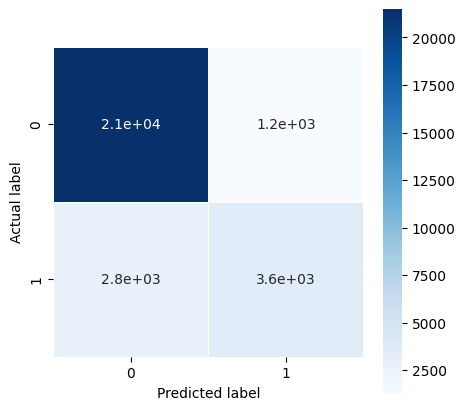

In [69]:

y_pred = cat.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))


from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [70]:
rf=RandomForestClassifier()
rf.fit(X_train_res,y_train_res)

RandomForestClassifier()

Accuracy Score : 84.37 %
F-1 Score :  0.6319028340080971
Precision Score :  0.6530543933054394
Recall Score :  0.612078431372549


Text(0.5, 63.222222222222186, 'Predicted label')

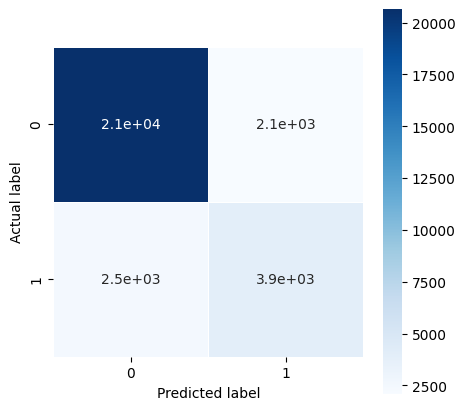

In [71]:

y_pred = rf.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))


from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [72]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

C:\Users\Sammitha S Poojary\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy Score : 77.15 %
F-1 Score :  0.5935933488201492
Precision Score :  0.48632675548432336
Recall Score :  0.7615686274509804


Text(0.5, 63.222222222222186, 'Predicted label')

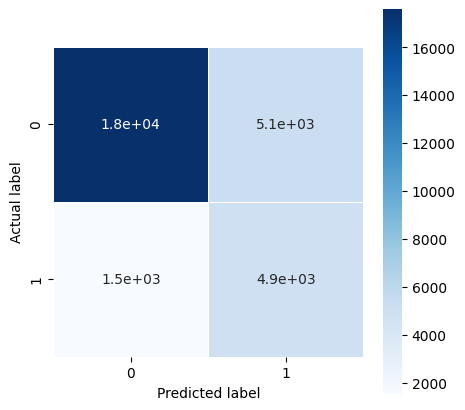

In [73]:

y_pred = logreg.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))


from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [74]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=3)

Accuracy Score : 75.31 %
F-1 Score :  0.5618594436310395
Precision Score :  0.45971847858640313
Recall Score :  0.7223529411764706


Text(0.5, 63.222222222222186, 'Predicted label')

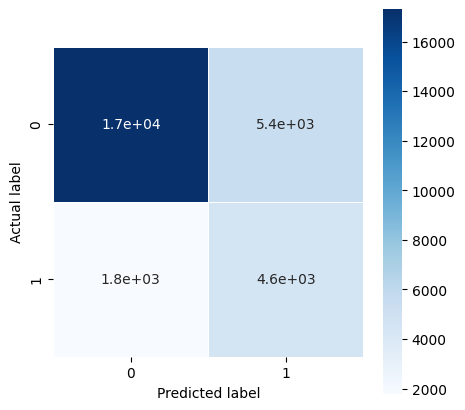

In [75]:

y_pred = knn.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))


from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [76]:
xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Accuracy Score : 85.64 %
F-1 Score :  0.6296854231280461
Precision Score :  0.7236252545824847
Recall Score :  0.5573333333333333


Text(0.5, 63.222222222222186, 'Predicted label')

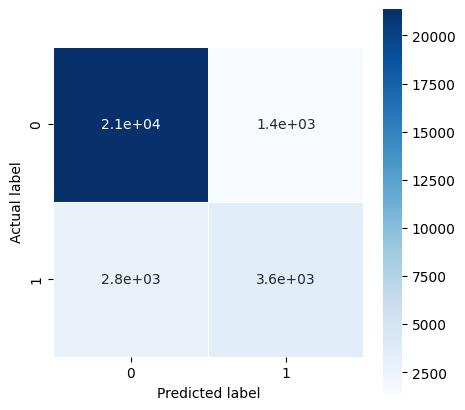

In [77]:

y_pred = xgb.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))


from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [78]:
joblib.dump(cat, "cat.pkl")
joblib.dump(xgb, "xgb.pkl")